In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import ast
from datetime import datetime
import warnings
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
#from wrappers import technical_analysis as ta

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def run_trading_simulation(prediction_outcome):
    
    capital = 10000
    #print('we have $%s to start' % capital)
    
    outcomes = {'correct_overpredict': 0,
                'correct_underpredict': 0,
                'incorrect': 0
               }
    
    overall_accuracy = {'correct': 0,
                        'incorrect': 0
                       }

    for prediction in prediction_outcome:

        actual_change = prediction[0]
        predicted_change = prediction[1]

        #print('the predicted change is %s but it was actually %s.' % (predicted_change, actual_change))

        if predicted_change > 0:
            
            if actual_change > 0:
                
                if predicted_change < actual_change:
                    capital += ((capital * predicted_change) / 2)
                    outcomes['correct_underpredict'] += 1
                    
                elif predicted_change > actual_change:
                    capital += ((capital * actual_change) / 2)
                    outcomes['correct_overpredict'] += 1
                    
            elif actual_change < 0:
                capital *= (1 + actual_change)
                outcomes['incorrect'] += 1
                
        elif predicted_change < 0:
            
            pass

        #print('we now have $%.2f' % capital)
        
        if np.sign(actual_change) == np.sign(predicted_change):
            overall_accuracy['correct'] += 1
        else:
            overall_accuracy['incorrect'] += 1
    
    accuracy = overall_accuracy['correct'] / (overall_accuracy['correct'] + overall_accuracy['incorrect'])
    
    return capital, outcomes, accuracy

# used for quickly judging ensemble performance
def mini_trading_simulation(prediction_outcome):
    
    capital = 1000
    
    for actual_change, predicted_change in prediction_outcome:

        #actual_change = prediction[0]
        #predicted_change = prediction[1]

        #print('the predicted change is %s but it was actually %s.' % (predicted_change, actual_change))

        if predicted_change > 0:
            
            if actual_change > 0:
                
                if predicted_change < actual_change:
                    capital *= (1 + predicted_change)
                    
                elif predicted_change > actual_change:
                    capital *= (1 + actual_change)
                    
            elif actual_change < 0:
                capital *= (1 + actual_change)
                
        elif predicted_change < 0:
            
            pass
    
    return capital

# plotting
def plot_results(results_dict):
    
    for i, k in enumerate(results_dict):

        if i <= 1:
            # plot test results
            pd.Series([i[0][0] for i in results_dict[k]]).plot(figsize = (14, 8))
            pd.Series([i[0][1] for i in results_dict[k]]).plot()
            pd.Series([0 for i in results_dict[k]]).plot()
        else:
            pd.Series([i[0][1] for i in results_dict[k]]).plot();

# reshape data for a stateful model (with no repeating / overlapping data)
def reshape_stateful_timestep(arr, timestep):
    
    # get the shape of the input array
    s = arr.shape
    
    # check if it is divisible by the timestep. it needs to be for reshape to work properly
    remainder = s[0] % timestep
    
    # if there is no remainder, just reshape it to a 3D array with timesteps
    if remainder == 0:
        print('divisible')
        return np.reshape(arr, (int(s[0] / timestep), timestep, s[1]))
    
    # if there is a remainder, remove rows in the beginning so it can be reshaped without issue
    elif remainder != 0:
        print('not divisible')
        print('remainder:', remainder)
        return np.reshape(arr[remainder:,:], (int(s[0] / timestep), timestep, s[1]))
    
    else: print('wtf')

# helper for removing dups from repeats in ensembles
def return_sorted_str_list(unsorted_list):
    
    slist = ast.literal_eval(unsorted_list)
    slist.sort()
    
    return slist

# get a summary table of model performance
def get_model_summaries(iter_results):
    
    results = dict(iter_results.copy())
    
    outcomes = {}
    rmses = {}

    for k in results:
        _app1 = []
        _app2 = []
        for wfi in results[k]:
            _app1.append(wfi[0])
            _app2.append(wfi[1])
        outcomes[k] = _app1
        rmses[k] = _app2

    trade_simulations = []

    for k in outcomes:
        capital, cor_inc, accuracy = run_trading_simulation(outcomes[k])

        trade_simulations.append({'model': k,
                                  'features': float(k.split('_')[0].replace('features', '')),
                                  'layers': float(k.split('_')[1].replace('layers', '')),
                                  'epochs': float(k.split('_')[2].replace('epochs', '')),
                                  'timesteps': float(k.split('_')[3].replace('timesteps','')),
                                  'dropout': float(k.split('_')[4].replace('dropout','')),
                                  'units': float(k.split('_')[5].replace('units','')),
                                  'correct_over': cor_inc['correct_overpredict'],
                                  'correct_under': cor_inc['correct_underpredict'],
                                  'incorrect': cor_inc['incorrect'],
                                  'accuracy': accuracy,
                                  'rmse_mean': np.array(rmses[k]).mean(),
                                  'rmse_std': np.array(rmses[k]).std()
                                 })

    return pd.DataFrame(trade_simulations).sort_values('accuracy', ascending = False).reset_index()

# in order to simulate the time it takes to get the data, process it, and train it, we'll use
# a "lag" accuracy, where it calculates the accuracy from one time period after
def get_lag_accuracy(y_true, y_pred):
    
    # init a df with both y values and the init price and lag values
    df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_true, 'price': 1, 'y_lag': 1})

    # loop through each row and get a simulated price, starting from 1
    for i, row in df.iterrows():

        prev_index = row.name - 4

        if i == 4:
            df.price.ix[i] = 1 * (1 + df.y_true.ix[prev_index])

        elif i >= 5:
            df.price.ix[i] = df.price.ix[prev_index] * (1 + df.y_true.ix[prev_index])

    # cut out the first few rows because we don't have that data
    df = df.ix[3:,:]

    # shift down the price by one row so that it simulates what the lag price would be at the time period
    df['lag_price'] = df.price.shift(-1)
    df.dropna(inplace = True)

    # loop through each row and calculate the lag price's rate of change from the future price
    for i, row in df.iterrows():

        sample_count = df.shape[0]

        if i < sample_count - 1:
            predict_index = row.name + 4
            future_price = df.ix[predict_index].price

            lag_roc = (future_price - row.lag_price) / row.lag_price

            df['y_lag'].ix[i] = lag_roc

    # remove last four rows, which still have the init 1s (ones)
    df = df.iloc[:-4]

    # add a row to specify whether or not the p
    df['lag_accurate'] = np.sign(df.y_pred) == np.sign(df.y_lag)
    df['pred_accurate'] = np.sign(df.y_pred) == np.sign(df.y_true)
    
    return df.lag_accurate.mean()

# trading simulation for target strategies
def target_trading_simulation(prediction_outcome, strategy_type, capital, percent_target):
    
    init_capital = int(capital)
    margin_return = 0
    profit_count = 0
    loss_count = 0
    
    if strategy_type == 'static_target_threshold':
        
        '''
        THIS MEANS THAT TRADES WILL ONLY BE PLACED IF THE PREDICTED INCREASE
        IS ABOVE A CERTAIN LEVEL. THIS IS GOING BOTH WITH AND AGAINST THE TREND.
        ONCE THE THRESHOLD IS HIT, EITHER CORRECTLY OR INCORRECTLY, THE POSITION
        WILL BE CLOSED.
        '''
    
        for actual_change, predicted_change in prediction_outcome:
            
            # check if the predicted change is larger then our target
            if abs(predicted_change) >= abs(percent_target):
                
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):
                    
                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1
                
                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):
                    
                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    if strategy_type == 'static_target_always':
        
        '''
        THIS MEANS THAT TRADES WILL BE PLACED REGARDLESS OF THE PREDICTED INCREASE.
        IF THE PREDICTED INCREASE IS POSITIVE, THEN A TRADE WILL BE PLACED IN THAT
        DIRECTION AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION. IF THE
        PREDICTED INCREASE IS NEGATIVE, THEN A TRADE WILL BE PLACED IN THAT DIRECTION
        AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            # potentially add profits if actual and predicted directions matched
            if np.sign(actual_change) == np.sign(predicted_change):
                
                # add profit if the actual change reached our target
                if abs(actual_change) >= percent_target:
                    capital += (capital * percent_target)
                    margin_return += (init_capital * percent_target)
                    profit_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
            # potentially take a loss if actual and predicted directions did NOT match
            elif np.sign(actual_change) != np.sign(predicted_change):

                # take a loss if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital -= (capital * percent_target)
                    margin_return -= (init_capital * percent_target)
                    loss_count += 1
                
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'variable_target_threshold':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        BUT IT ALSO HAS A THRESHOLD, OR MININUM PREDICTED CHANGE. I.E., ASSUMING A
        THRESHOLD OF 2%, IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%, THEN THE
        POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. HOWEVER, IF THE PREDICTED
        CHANGE IS -1.5%, THEN THE POSITION WILL NOT BE OPENED BECAUSE IT IS NOT ABOVE THE
        THRESHOLD. NOTE: THE TARGET WILL ALWAYS BE ROUNDED DOWN.
        '''
        
        # this is a bit of a lazy hack, in order for easier looping during analysis, the
        # 'threshold' will be the initial 'percent_target'. essentially, just noting that
        # the percent target isn't really what it is in other strategies since it is variable.
        threshold = float(percent_target)
        
        for actual_change, predicted_change in prediction_outcome:
            
            # set the new percent target, based off of the predicted change, rounded
            # down to the closest percentage
            percent_target = int(abs((predicted_change * 100))) / 100
            
            # check if the predicted change is larger then our threshold
            if abs(predicted_change) >= abs(threshold):
                
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1
                    
                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
        
        
    if strategy_type == 'variable_target_always':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        THERE IS NO THRESHOLD. I.E. IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%,
        THEN THE POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. THIS IS
        REGARDLESS OF HOW BIG OR SMALL THE PREDICTION IS. NOTE: THE TARGET WILL ALWAYS
        BE ROUNDED DOWN.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            percent_target = int(abs((predicted_change * 100))) / 100
            
            # potentially add profits if actual and predicted directions matched
            if np.sign(actual_change) == np.sign(predicted_change):

                # add profit if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital += (capital * percent_target)
                    margin_return += (init_capital * percent_target)
                    profit_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
            # potentially take a loss if actual and predicted directions did NOT match
            elif np.sign(actual_change) != np.sign(predicted_change):

                # take a loss if the actual change reached our target
                if abs(actual_change) > percent_target:
                    capital -= (capital * percent_target)
                    margin_return -= (init_capital * percent_target)
                    loss_count += 1
                    
                # more realistic version of the "if it does not reach target" scenario
                elif abs(actual_change) < percent_target:
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'no_target_threshold':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. THAT IS, IF THE MODEL
        PREDICTS ABOVE THE THRESHOLD.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
            
            # is the predicted change above the threshold?
            if abs(predicted_change) >= abs(percent_target):
                
                # add profit if the direction of the predicted change was CORRECT
                if np.sign(actual_change) == np.sign(predicted_change):
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1
            
                # take a loss if the direction of the predicted change was INCORRECT
                elif np.sign(actual_change) != np.sign(predicted_change):
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    
    if strategy_type == 'no_target_always':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. ALWAYS. NO THRESHOLD.
        '''
        
        for actual_change, predicted_change in prediction_outcome:
                
            # add profit if the direction of the predicted change was CORRECT
            if np.sign(actual_change) == np.sign(predicted_change):
                capital += (capital * actual_change)
                margin_return += (init_capital * actual_change)
                profit_count += 1

            # take a loss if the direction of the predicted change was INCORRECT
            elif np.sign(actual_change) != np.sign(predicted_change):
                capital -= (capital * actual_change)
                margin_return -= (init_capital * actual_change)
                loss_count += 1
    
    return capital, margin_return, profit_count, loss_count

# trading simulation for target strategies
def trend_trading_simulation(prediction_outcome, strategy_type, capital, percent_target, trend):
    
    # init vars
    init_capital = int(capital)
    margin_return = 0
    profit_count = 0
    loss_count = 0
    
    # slight hack so that this can work with both trend and non-trend trade strategies
    # unzip the prediction outcome and rezip it with the market trend / cycle (bull/bear)
    unzip_true = []
    unzip_pred = []
    
    for true, pred in prediction_outcome:
        unzip_true.append(true)
        unzip_pred.append(pred)
    
    prediction_outcome = zip(unzip_true, unzip_pred, trend)
    
    
    if strategy_type == 'static_target_threshold':
        
        '''
        THIS MEANS THAT TRADES WILL ONLY BE PLACED IF THE PREDICTED INCREASE
        IS ABOVE A CERTAIN LEVEL. THIS IS GOING BOTH WITH AND AGAINST THE TREND.
        ONCE THE THRESHOLD IS HIT, EITHER CORRECTLY OR INCORRECTLY, THE POSITION
        WILL BE CLOSED.
        '''
    
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # check if the predicted change is larger then our target
                if abs(predicted_change) >= abs(percent_target):

                    # potentially add profits if actual and predicted directions matched
                    if np.sign(actual_change) == np.sign(predicted_change):

                        # add profit if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital += (capital * percent_target)
                            margin_return += (init_capital * percent_target)
                            profit_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital += (capital * actual_change)
                            margin_return += (init_capital * actual_change)
                            profit_count += 1

                    # potentially take a loss if actual and predicted directions did NOT match
                    elif np.sign(actual_change) != np.sign(predicted_change):

                        # take a loss if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital -= (capital * percent_target)
                            margin_return -= (init_capital * percent_target)
                            loss_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital -= (capital * actual_change)
                            margin_return -= (init_capital * actual_change)
                            loss_count += 1
    
    if strategy_type == 'static_target_always':
        
        '''
        THIS MEANS THAT TRADES WILL BE PLACED REGARDLESS OF THE PREDICTED INCREASE.
        IF THE PREDICTED INCREASE IS POSITIVE, THEN A TRADE WILL BE PLACED IN THAT
        DIRECTION AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION. IF THE
        PREDICTED INCREASE IS NEGATIVE, THEN A TRADE WILL BE PLACED IN THAT DIRECTION
        AND CLOSED WHEN PERCENT TARGET IS HIT IN EITHER DIRECTION.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) >= percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'variable_target_threshold':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        BUT IT ALSO HAS A THRESHOLD, OR MININUM PREDICTED CHANGE. I.E., ASSUMING A
        THRESHOLD OF 2%, IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%, THEN THE
        POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. HOWEVER, IF THE PREDICTED
        CHANGE IS -1.5%, THEN THE POSITION WILL NOT BE OPENED BECAUSE IT IS NOT ABOVE THE
        THRESHOLD. NOTE: THE TARGET WILL ALWAYS BE ROUNDED DOWN.
        '''
        
        # this is a bit of a lazy hack, in order for easier looping during analysis, the
        # 'threshold' will be the initial 'percent_target'. essentially, just noting that
        # the percent target isn't really what it is in other strategies since it is variable.
        threshold = float(percent_target)
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # set the new percent target, based off of the predicted change, rounded
                # down to the closest percentage
                percent_target = int(abs((predicted_change * 100))) / 100

                # check if the predicted change is larger then our threshold
                if abs(predicted_change) >= abs(threshold):

                    # potentially add profits if actual and predicted directions matched
                    if np.sign(actual_change) == np.sign(predicted_change):

                        # add profit if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital += (capital * percent_target)
                            margin_return += (init_capital * percent_target)
                            profit_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital += (capital * actual_change)
                            margin_return += (init_capital * actual_change)
                            profit_count += 1

                    # potentially take a loss if actual and predicted directions did NOT match
                    elif np.sign(actual_change) != np.sign(predicted_change):

                        # take a loss if the actual change reached our target
                        if abs(actual_change) > percent_target:
                            capital -= (capital * percent_target)
                            margin_return -= (init_capital * percent_target)
                            loss_count += 1

                        # more realistic version of the "if it does not reach target" scenario
                        elif abs(actual_change) < percent_target:
                            capital -= (capital * actual_change)
                            margin_return -= (init_capital * actual_change)
                            loss_count += 1
        
        
    if strategy_type == 'variable_target_always':
        
        '''
        IN THIS STRATEGY, THE TRADE TARGET IS VARIABLE, DEPENDENT ON THE PREDICTION.
        THERE IS NO THRESHOLD. I.E. IF THE PREDICTED CHANGE IS AN INCREASE OF +3.5%,
        THEN THE POSITION WILL BE CLOSED IF THE PRICE GOES UP OR DOWN 3%. THIS IS
        REGARDLESS OF HOW BIG OR SMALL THE PREDICTION IS. NOTE: THE TARGET WILL ALWAYS
        BE ROUNDED DOWN.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                percent_target = int(abs((predicted_change * 100))) / 100

                # potentially add profits if actual and predicted directions matched
                if np.sign(actual_change) == np.sign(predicted_change):

                    # add profit if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital += (capital * percent_target)
                        margin_return += (init_capital * percent_target)
                        profit_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                # potentially take a loss if actual and predicted directions did NOT match
                elif np.sign(actual_change) != np.sign(predicted_change):

                    # take a loss if the actual change reached our target
                    if abs(actual_change) > percent_target:
                        capital -= (capital * percent_target)
                        margin_return -= (init_capital * percent_target)
                        loss_count += 1

                    # more realistic version of the "if it does not reach target" scenario
                    elif abs(actual_change) < percent_target:
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'no_target_threshold':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. THAT IS, IF THE MODEL
        PREDICTS ABOVE THE THRESHOLD.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # is the predicted change above the threshold?
                if abs(predicted_change) >= abs(percent_target):

                    # add profit if the direction of the predicted change was CORRECT
                    if np.sign(actual_change) == np.sign(predicted_change):
                        capital += (capital * actual_change)
                        margin_return += (init_capital * actual_change)
                        profit_count += 1

                    # take a loss if the direction of the predicted change was INCORRECT
                    elif np.sign(actual_change) != np.sign(predicted_change):
                        capital -= (capital * actual_change)
                        margin_return -= (init_capital * actual_change)
                        loss_count += 1
    
    
    if strategy_type == 'no_target_always':
        
        '''
        THIS STRATEGY IS PROBABLY THE SIMPLEST: BASICALLY, YOU HOLD UNTIL THE TRADING
        PERIOD CLOSES. IF THE MODEL PREDICTS UPWARDS MOVEMENT, THEN OPEN A LONG. IF
        IT PREDICTS THE PRICE TO GO DOWN, THEN OPEN A SHORT. ALWAYS. NO THRESHOLD.
        '''
        
        for actual_change, predicted_change, market_trend in prediction_outcome:
            
            # check to see if the predicted change aligns with the current market trend
            if np.sign(predicted_change) == np.sign(market_trend):
            
                # add profit if the direction of the predicted change was CORRECT
                if np.sign(actual_change) == np.sign(predicted_change):
                    capital += (capital * actual_change)
                    margin_return += (init_capital * actual_change)
                    profit_count += 1

                # take a loss if the direction of the predicted change was INCORRECT
                elif np.sign(actual_change) != np.sign(predicted_change):
                    capital -= (capital * actual_change)
                    margin_return -= (init_capital * actual_change)
                    loss_count += 1
    
    return capital, margin_return, profit_count, loss_count

# Ensemble Finder 3.0

In [27]:
iter_results = {
    
#     '24hrs_1steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_128units': [((-0.033892851, 0.029718732), ([-0.03389285132288933], [0.029718732461333275])), ((0.032751158, -0.016317757), ([0.03275115787982941], [-0.016317756846547127])), ((-0.054339226, -0.01273651), ([-0.054339226335287094], [-0.01273651048541069])), ((-0.060591973, -0.10193963), ([-0.06059197336435318], [-0.10193963348865509])), ((0.017551962, -0.1068776), ([0.017551962286233902], [-0.10687759518623352])), ((-0.0036638351, -0.094816856), ([-0.0036638351157307625], [-0.09481685608625412])), ((-0.033193402, -0.048639115), ([-0.033193401992321014], [-0.04863911494612694])), ((-0.0079437206, -0.094913267), ([-0.007943720556795597], [-0.09491326659917831])), ((-0.040850949, -0.039544638), ([-0.04085094854235649], [-0.039544638246297836])), ((0.077683166, -0.1025382), ([0.07768316566944122], [-0.10253819823265076])), ((-0.032464292, -0.049895789), ([-0.03246429190039635], [-0.049895789474248886])), ((0.0048174788, -0.10481039), ([0.004817478824406862], [-0.10481038689613342])), ((-0.00060773856, -0.091331549), ([-0.0006077385623939335], [-0.09133154898881912])), ((-0.009358108, -0.081489809), ([-0.009358108043670654], [-0.08148980885744095])), ((0.044060975, -0.08267051), ([0.044060975313186646], [-0.08267050981521606])), ((0.0060101259, 0.0016521043), ([0.006010125856846571], [0.001652104314416647])), ((-0.0028897042, 0.0015858547), ([-0.002889704192057252], [0.001585854683071375])), ((-0.030901985, -0.012780934), ([-0.030901985242962837], [-0.012780933640897274])), ((-0.045058969, -0.06268765), ([-0.0450589694082737], [-0.06268765032291412])), ((0.045394089, -0.088656314), ([0.045394089072942734], [-0.08865631371736526])), ((0.0025546867, -0.054585818), ([0.002554686740040779], [-0.05458581820130348])), ((-0.0024508159, -0.034685917), ([-0.0024508158676326275], [-0.03468591719865799])), ((0.0069666477, -0.073259406), ([0.006966647692024708], [-0.07325940579175949])), ((-0.024331551, -0.080708027), ([-0.024331551045179367], [-0.08070802688598633])), ((0.034495752, -0.032901242), ([0.034495752304792404], [-0.03290124237537384])), ((0.050067883, 0.010741075), ([0.05006788298487663], [0.010741074569523335])), ((-0.044495601, 0.014281322), ([-0.0444956012070179], [0.014281322248280048])), ((-0.003580977, 0.01095145), ([-0.003580976976081729], [0.01095145009458065])), ((0.010516325, 0.012204216), ([0.010516325011849403], [0.012204215861856937])), ((0.020321872, 0.031929921), ([0.02032187208533287], [0.031929921358823776])), ((0.046259116, 0.0095416047), ([0.046259116381406784], [0.009541604667901993])), ((0.019112499, 0.027002739), ([0.019112499430775642], [0.027002738788723946])), ((-0.010739956, 0.025475033), ([-0.010739956051111221], [0.02547503262758255])), ((0.007156997, 0.010281764), ([0.007156996987760067], [0.010281763970851898])), ((0.0097792586, -0.049809925), ([0.009779258631169796], [-0.04980992525815964])), ((0.070570827, -0.0070162578), ([0.07057082653045654], [-0.007016257848590612])), ((0.012503496, 0.020538747), ([0.012503496371209621], [0.020538747310638428])), ((0.0083487583, 0.039829008), ([0.008348758332431316], [0.039829008281230927])), ((0.0041315989, 0.0075257695), ([0.004131598863750696], [0.007525769528001547])), ((0.089795358, 0.017021067), ([0.08979535847902298], [0.017021067440509796])), ((0.098956339, 0.082956061), ([0.09895633906126022], [0.08295606076717377])), ((0.064874992, 0.050356127), ([0.06487499177455902], [0.05035612732172012])), ((-0.021201942, 0.11804886), ([-0.02120194211602211], [0.11804886162281036])), ((0.035693988, 0.060395204), ([0.03569398820400238], [0.06039520353078842])), ((-0.01019353, 0.09632434), ([-0.010193529538810253], [0.09632433950901031])), ((0.0015991471, 0.070570603), ([0.0015991471009328961], [0.07057060301303864])), ((-0.095263436, 0.027318666), ([-0.09526343643665314], [0.027318665757775307])), ((0.049495801, -0.10213022), ([0.04949580132961273], [-0.1021302193403244])), ((0.032226756, -0.03784791), ([0.03222675621509552], [-0.037847910076379776])), ((0.011055363, -0.072989658), ([0.011055363342165947], [-0.07298965752124786])), ((-0.011815255, -0.051244278), ([-0.01181525457650423], [-0.05124427750706673])), ((-0.003369563, -0.072318427), ([-0.003369563026353717], [-0.0723184272646904])), ((-0.04700622, -0.061981574), ([-0.04700621962547302], [-0.061981573700904846])), ((-0.059098188, -0.067791671), ([-0.05909818783402443], [-0.06779167056083679])), ((0.055390678, -0.052350849), ([0.055390678346157074], [-0.05235084891319275])), ((0.069079176, -0.0019878463), ([0.06907917559146881], [-0.0019878463353961706])), ((-0.061439782, 0.038982), ([-0.06143978238105774], [0.038982000201940536])), ((0.071686998, 0.042303655), ([0.0716869980096817], [0.0423036552965641])), ((0.19921757, -0.054263316), ([0.19921757280826569], [-0.054263316094875336])), ((0.18604903, 0.11249719), ([0.18604902923107147], [0.11249718815088272])), ((0.055051539, 0.12794133), ([0.055051539093256], [0.1279413253068924])), ((-0.054621547, 0.18490008), ([-0.05462154746055603], [0.18490007519721985])), ((0.038966533, 0.020657737), ([0.03896653279662132], [0.0206577368080616])), ((0.035469141, 0.17850138), ([0.035469140857458115], [0.17850138247013092])), ((0.022358609, 0.17743546), ([0.0223586093634367], [0.17743545770645142])), ((0.11690363, -0.0092623411), ([0.1169036328792572], [-0.00926234107464552])), ((-0.038189534, 0.11790932), ([-0.03818953409790993], [0.11790931969881058])), ((0.016286815, -0.13670655), ([0.016286814585328102], [-0.13670654594898224])), ((-0.19364448, 0.10316486), ([-0.1936444789171219], [0.10316485911607742])), ((0.07226453, -0.17081894), ([0.07226452976465225], [-0.17081893980503082])), ((-0.093356617, -0.19037506), ([-0.09335661679506302], [-0.19037505984306335])), ((0.12764046, -0.03071934), ([0.12764045596122742], [-0.030719339847564697])), ((0.048866935, -0.064731203), ([0.048866935074329376], [-0.06473120301961899])), ((0.0045599514, 0.11960031), ([0.004559951368719339], [0.119600310921669])), ((-0.066291995, -0.013166249), ([-0.06629199534654617], [-0.013166248798370361])), ((0.045301478, -0.038976535), ([0.04530147835612297], [-0.03897653520107269]))],
#     '24hrs_1steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_96units': [((-0.033892851, 0.020349557), ([-0.03389285132288933], [0.02034955658018589])), ((0.032751158, -0.021114809), ([0.03275115787982941], [-0.021114809438586235])), ((-0.054339226, -0.026249871), ([-0.054339226335287094], [-0.026249870657920837])), ((-0.060591973, 0.00023939178), ([-0.06059197336435318], [0.00023939178208820522])), ((0.017551962, -0.079109631), ([0.017551962286233902], [-0.07910963147878647])), ((-0.0036638351, -0.098308265), ([-0.0036638351157307625], [-0.098308265209198])), ((-0.033193402, -0.084405035), ([-0.033193401992321014], [-0.08440503478050232])), ((-0.0079437206, -0.009458893), ([-0.007943720556795597], [-0.009458892978727818])), ((-0.040850949, -0.038802538), ([-0.04085094854235649], [-0.03880253806710243])), ((0.077683166, -0.095292568), ([0.07768316566944122], [-0.09529256820678711])), ((-0.032464292, 0.040329549), ([-0.03246429190039635], [0.040329549461603165])), ((0.0048174788, -0.089899138), ([0.004817478824406862], [-0.08989913761615753])), ((-0.00060773856, -0.069168136), ([-0.0006077385623939335], [-0.06916813552379608])), ((-0.009358108, -0.036233582), ([-0.009358108043670654], [-0.036233581602573395])), ((0.044060975, -0.080793381), ([0.044060975313186646], [-0.08079338073730469])), ((0.0060101259, -0.054316413), ([0.006010125856846571], [-0.05431641265749931])), ((-0.0028897042, -0.031359397), ([-0.002889704192057252], [-0.03135939687490463])), ((-0.030901985, -0.11060167), ([-0.030901985242962837], [-0.11060167104005814])), ((-0.045058969, -0.084734201), ([-0.0450589694082737], [-0.08473420143127441])), ((0.045394089, -0.11469976), ([0.045394089072942734], [-0.11469975858926773])), ((0.0025546867, -0.018647837), ([0.002554686740040779], [-0.01864783652126789])), ((-0.0024508159, -0.023011284), ([-0.0024508158676326275], [-0.023011283949017525])), ((0.0069666477, -0.10506915), ([0.006966647692024708], [-0.10506915301084518])), ((-0.024331551, -0.057904281), ([-0.024331551045179367], [-0.057904280722141266])), ((0.034495752, -0.020976717), ([0.034495752304792404], [-0.02097671665251255])), ((0.050067883, -0.0044976869), ([0.05006788298487663], [-0.004497686866670847])), ((-0.044495601, 0.016971808), ([-0.0444956012070179], [0.016971807926893234])), ((-0.003580977, 0.001790153), ([-0.003580976976081729], [0.0017901529790833592])), ((0.010516325, 0.0084826229), ([0.010516325011849403], [0.008482622914016247])), ((0.020321872, 0.0041137696), ([0.02032187208533287], [0.0041137696243822575])), ((0.046259116, 0.0012533653), ([0.046259116381406784], [0.0012533653061836958])), ((0.019112499, 0.0013962071), ([0.019112499430775642], [0.0013962071388959885])), ((-0.010739956, 0.027175011), ([-0.010739956051111221], [0.02717501111328602])), ((0.007156997, 0.014079021), ([0.007156996987760067], [0.014079021289944649])), ((0.0097792586, 0.017480964), ([0.009779258631169796], [0.017480963841080666])), ((0.070570827, -0.016171806), ([0.07057082653045654], [-0.016171805560588837])), ((0.012503496, 0.08426331), ([0.012503496371209621], [0.08426330983638763])), ((0.0083487583, 0.017510764), ([0.008348758332431316], [0.01751076430082321])), ((0.0041315989, 0.014166499), ([0.004131598863750696], [0.014166498556733131])), ((0.089795358, -0.018165302), ([0.08979535847902298], [-0.01816530153155327])), ((0.098956339, 0.078046888), ([0.09895633906126022], [0.07804688811302185])), ((0.064874992, -0.051043347), ([0.06487499177455902], [-0.051043346524238586])), ((-0.021201942, 0.10747954), ([-0.02120194211602211], [0.1074795350432396])), ((0.035693988, 0.04345572), ([0.03569398820400238], [0.04345571994781494])), ((-0.01019353, 0.019813769), ([-0.010193529538810253], [0.019813768565654755])), ((0.0015991471, -0.046471991), ([0.0015991471009328961], [-0.04647199064493179])), ((-0.095263436, 0.02759669), ([-0.09526343643665314], [0.027596689760684967])), ((0.049495801, -0.11130888), ([0.04949580132961273], [-0.11130888015031815])), ((0.032226756, -0.10174529), ([0.03222675621509552], [-0.10174529254436493])), ((0.011055363, -0.075504228), ([0.011055363342165947], [-0.07550422847270966])), ((-0.011815255, -0.0036386237), ([-0.01181525457650423], [-0.003638623747974634])), ((-0.003369563, -0.078225337), ([-0.003369563026353717], [-0.07822533696889877])), ((-0.04700622, -0.072814278), ([-0.04700621962547302], [-0.07281427830457687])), ((-0.059098188, -0.019603835), ([-0.05909818783402443], [-0.01960383541882038])), ((0.055390678, -0.11157013), ([0.055390678346157074], [-0.11157013475894928])), ((0.069079176, 0.021265041), ([0.06907917559146881], [0.021265041083097458])), ((-0.061439782, 0.0099863652), ([-0.06143978238105774], [0.009986365213990211])), ((0.071686998, 0.011703149), ([0.0716869980096817], [0.011703149415552616])), ((0.19921757, -0.017181542), ([0.19921757280826569], [-0.01718154177069664])), ((0.18604903, 0.1582925), ([0.18604902923107147], [0.1582925021648407])), ((0.055051539, 0.12553544), ([0.055051539093256], [0.12553544342517853])), ((-0.054621547, 0.048306413), ([-0.05462154746055603], [0.0483064129948616])), ((0.038966533, 0.095253535), ([0.03896653279662132], [0.09525353461503983])), ((0.035469141, 0.1422473), ([0.035469140857458115], [0.1422473043203354])), ((0.022358609, 0.10189728), ([0.0223586093634367], [0.10189727693796158])), ((0.11690363, -0.0053596739), ([0.1169036328792572], [-0.005359673872590065])), ((-0.038189534, 0.09719532), ([-0.03818953409790993], [0.09719531983137131])), ((0.016286815, 0.11742956), ([0.016286814585328102], [0.11742956191301346])), ((-0.19364448, -0.00015295624), ([-0.1936444789171219], [-0.00015295624325517565])), ((0.07226453, -0.19244245), ([0.07226452976465225], [-0.19244244694709778])), ((-0.093356617, -0.17341654), ([-0.09335661679506302], [-0.17341654002666473])), ((0.12764046, 0.0035916755), ([0.12764045596122742], [0.0035916755441576242])), ((0.048866935, -0.034733336), ([0.048866935074329376], [-0.03473333641886711])), ((0.0045599514, 0.04536321), ([0.004559951368719339], [0.04536321014165878])), ((-0.066291995, 0.06715475), ([-0.06629199534654617], [0.06715475022792816])), ((0.045301478, 0.017541237), ([0.04530147835612297], [0.01754123717546463]))],
#     '24hrs_1steps_0bidir_40features_2layers_300epochs_1timesteps_0.2dropout_64units': [((-0.033892851, 0.018984277), ([-0.03389285132288933], [0.018984276801347733])), ((0.032751158, -0.035874557), ([0.03275115787982941], [-0.03587455675005913])), ((-0.054339226, -0.012411496), ([-0.054339226335287094], [-0.012411495670676231])), ((-0.060591973, -0.011404085), ([-0.06059197336435318], [-0.011404084973037243])), ((0.017551962, -0.026055701), ([0.017551962286233902], [-0.026055701076984406])), ((-0.0036638351, -0.05630894), ([-0.0036638351157307625], [-0.056308940052986145])), ((-0.033193402, -0.021010399), ([-0.033193401992321014], [-0.021010398864746094])), ((-0.0079437206, -0.13250321), ([-0.007943720556795597], [-0.1325032114982605])), ((-0.040850949, -0.11198333), ([-0.04085094854235649], [-0.11198332905769348])), ((0.077683166, -0.03948535), ([0.07768316566944122], [-0.039485350251197815])), ((-0.032464292, -0.067675248), ([-0.03246429190039635], [-0.06767524778842926])), ((0.0048174788, -0.10599823), ([0.004817478824406862], [-0.10599823296070099])), ((-0.00060773856, -0.062274016), ([-0.0006077385623939335], [-0.0622740164399147])), ((-0.009358108, -0.038600992), ([-0.009358108043670654], [-0.038600992411375046])), ((0.044060975, -0.07403893), ([0.044060975313186646], [-0.07403893023729324])), ((0.0060101259, 0.0010211063), ([0.006010125856846571], [0.0010211062617599964])), ((-0.0028897042, -0.049728837), ([-0.002889704192057252], [-0.04972883686423302])), ((-0.030901985, -0.069882169), ([-0.030901985242962837], [-0.06988216936588287])), ((-0.045058969, -0.043772332), ([-0.0450589694082737], [-0.04377233237028122])), ((0.045394089, -0.11333731), ([0.045394089072942734], [-0.11333730816841125])), ((0.0025546867, -0.029994929), ([0.002554686740040779], [-0.02999492920935154])), ((-0.0024508159, -0.043878783), ([-0.0024508158676326275], [-0.04387878254055977])), ((0.0069666477, -0.047013871), ([0.006966647692024708], [-0.04701387137174606])), ((-0.024331551, -0.062793531), ([-0.024331551045179367], [-0.06279353052377701])), ((0.034495752, -0.053544201), ([0.034495752304792404], [-0.05354420095682144])), ((0.050067883, 0.01984819), ([0.05006788298487663], [0.019848190248012543])), ((-0.044495601, 0.017384943), ([-0.0444956012070179], [0.01738494262099266])), ((-0.003580977, -0.0065071597), ([-0.003580976976081729], [-0.006507159676402807])), ((0.010516325, 0.058924101), ([0.010516325011849403], [0.058924101293087006])), ((0.020321872, 0.021435728), ([0.02032187208533287], [0.021435728296637535])), ((0.046259116, 0.033380382), ([0.046259116381406784], [0.033380381762981415])), ((0.019112499, 0.051114347), ([0.019112499430775642], [0.05111434683203697])), ((-0.010739956, 0.054130331), ([-0.010739956051111221], [0.05413033068180084])), ((0.007156997, 0.034320716), ([0.007156996987760067], [0.03432071581482887])), ((0.0097792586, 0.0050549884), ([0.009779258631169796], [0.0050549884326756])), ((0.070570827, 0.016625568), ([0.07057082653045654], [0.01662556827068329])), ((0.012503496, 0.04681123), ([0.012503496371209621], [0.04681123048067093])), ((0.0083487583, 0.016567135), ([0.008348758332431316], [0.016567135229706764])), ((0.0041315989, 0.033552997), ([0.004131598863750696], [0.033552996814250946])), ((0.089795358, 0.027651755), ([0.08979535847902298], [0.027651755139231682])), ((0.098956339, 0.05166737), ([0.09895633906126022], [0.05166736990213394])), ((0.064874992, 0.036326595), ([0.06487499177455902], [0.03632659465074539])), ((-0.021201942, 0.065082155), ([-0.02120194211602211], [0.06508215516805649])), ((0.035693988, 0.044218663), ([0.03569398820400238], [0.04421866312623024])), ((-0.01019353, 0.10880581), ([-0.010193529538810253], [0.108805812895298])), ((0.0015991471, 0.020574855), ([0.0015991471009328961], [0.02057485468685627])), ((-0.095263436, 0.0239546), ([-0.09526343643665314], [0.0239546000957489])), ((0.049495801, -0.075546086), ([0.04949580132961273], [-0.07554608583450317])), ((0.032226756, -0.019241387), ([0.03222675621509552], [-0.019241387024521828])), ((0.011055363, -0.042565744), ([0.011055363342165947], [-0.04256574437022209])), ((-0.011815255, -0.013397666), ([-0.01181525457650423], [-0.013397665694355965])), ((-0.003369563, 0.049518991), ([-0.003369563026353717], [0.04951899126172066])), ((-0.04700622, -0.079473078), ([-0.04700621962547302], [-0.07947307825088501])), ((-0.059098188, -0.068577118), ([-0.05909818783402443], [-0.0685771182179451])), ((0.055390678, -0.071793325), ([0.055390678346157074], [-0.0717933252453804])), ((0.069079176, -0.068305336), ([0.06907917559146881], [-0.06830533593893051])), ((-0.061439782, 0.020659164), ([-0.06143978238105774], [0.02065916359424591])), ((0.071686998, 0.027735937), ([0.0716869980096817], [0.027735937386751175])), ((0.19921757, -0.043367088), ([0.19921757280826569], [-0.043367087841033936])), ((0.18604903, 0.02709852), ([0.18604902923107147], [0.0270985197275877])), ((0.055051539, 0.22325128), ([0.055051539093256], [0.22325128316879272])), ((-0.054621547, 0.23113474), ([-0.05462154746055603], [0.23113474249839783])), ((0.038966533, 0.03410241), ([0.03896653279662132], [0.034102410078048706])), ((0.035469141, 0.26747054), ([0.035469140857458115], [0.2674705386161804])), ((0.022358609, 0.13838606), ([0.0223586093634367], [0.1383860558271408])), ((0.11690363, 0.052202985), ([0.1169036328792572], [0.0522029846906662])), ((-0.038189534, 0.036942426), ([-0.03818953409790993], [0.03694242611527443])), ((0.016286815, 0.010968212), ([0.016286814585328102], [0.01096821203827858])), ((-0.19364448, 0.17690347), ([-0.1936444789171219], [0.17690347135066986])), ((0.07226453, -0.19354004), ([0.07226452976465225], [-0.1935400366783142])), ((-0.093356617, -0.027632268), ([-0.09335661679506302], [-0.027632268145680428])), ((0.12764046, -0.043534596), ([0.12764045596122742], [-0.043534595519304276])), ((0.048866935, -0.06165887), ([0.048866935074329376], [-0.06165887042880058])), ((0.0045599514, 0.020850038), ([0.004559951368719339], [0.020850038155913353])), ((-0.066291995, -0.00035213318), ([-0.06629199534654617], [-0.00035213318187743425])), ((0.045301478, -0.049771149), ([0.04530147835612297], [-0.04977114871144295]))],
#     '24hrs_1steps_0bidir_80features_1layers_300epochs_1timesteps_0.1dropout_52units': [((-0.033892851, 0.053901255), ([-0.03389285132288933], [0.05390125513076782])), ((0.032751158, -0.015073393), ([0.03275115787982941], [-0.01507339347153902])), ((-0.054339226, -0.028338561), ([-0.054339226335287094], [-0.028338560834527016])), ((-0.060591973, -0.11577457), ([-0.06059197336435318], [-0.11577457189559937])), ((0.017551962, -0.056239922), ([0.017551962286233902], [-0.05623992159962654])), ((-0.0036638351, -0.042460192), ([-0.0036638351157307625], [-0.04246019199490547])), ((-0.033193402, -0.028717171), ([-0.033193401992321014], [-0.028717171400785446])), ((-0.0079437206, -0.094283722), ([-0.007943720556795597], [-0.09428372234106064])), ((-0.040850949, -0.070461571), ([-0.04085094854235649], [-0.07046157121658325])), ((0.077683166, -0.035316143), ([0.07768316566944122], [-0.035316143184900284])), ((-0.032464292, -0.0049255849), ([-0.03246429190039635], [-0.004925584886223078])), ((0.0048174788, -0.057831213), ([0.004817478824406862], [-0.057831212878227234])), ((-0.00060773856, -0.017119173), ([-0.0006077385623939335], [-0.01711917296051979])), ((-0.009358108, -0.080634117), ([-0.009358108043670654], [-0.08063411712646484])), ((0.044060975, -0.074879907), ([0.044060975313186646], [-0.07487990707159042])), ((0.0060101259, 0.0043179253), ([0.006010125856846571], [0.004317925311625004])), ((-0.0028897042, 0.0063228905), ([-0.002889704192057252], [0.006322890520095825])), ((-0.030901985, -0.049229257), ([-0.030901985242962837], [-0.04922925680875778])), ((-0.045058969, -0.085697964), ([-0.0450589694082737], [-0.0856979638338089])), ((0.045394089, -0.094230004), ([0.045394089072942734], [-0.09423000365495682])), ((0.0025546867, -0.047861222), ([0.002554686740040779], [-0.04786122217774391])), ((-0.0024508159, -0.058196455), ([-0.0024508158676326275], [-0.058196455240249634])), ((0.0069666477, -0.095582053), ([0.006966647692024708], [-0.09558205306529999])), ((-0.024331551, -0.029617289), ([-0.024331551045179367], [-0.02961728908121586])), ((0.034495752, -0.093850575), ([0.034495752304792404], [-0.09385057538747787])), ((0.050067883, -0.066071145), ([0.05006788298487663], [-0.06607114523649216])), ((-0.044495601, -0.089870982), ([-0.0444956012070179], [-0.08987098187208176])), ((-0.003580977, 0.012121547), ([-0.003580976976081729], [0.012121547013521194])), ((0.010516325, -0.043145616), ([0.010516325011849403], [-0.043145615607500076])), ((0.020321872, 0.029035395), ([0.02032187208533287], [0.02903539501130581])), ((0.046259116, 0.017466269), ([0.046259116381406784], [0.017466269433498383])), ((0.019112499, 0.0058087707), ([0.019112499430775642], [0.005808770656585693])), ((-0.010739956, 0.035117209), ([-0.010739956051111221], [0.03511720895767212])), ((0.007156997, -0.041611817), ([0.007156996987760067], [-0.041611816734075546])), ((0.0097792586, 0.0028187488), ([0.009779258631169796], [0.0028187488205730915])), ((0.070570827, -0.016228126), ([0.07057082653045654], [-0.016228126361966133])), ((0.012503496, 0.044171501), ([0.012503496371209621], [0.04417150095105171])), ((0.0083487583, 0.0076197945), ([0.008348758332431316], [0.007619794458150864])), ((0.0041315989, -0.0045109252), ([0.004131598863750696], [-0.004510925151407719])), ((0.089795358, -0.055306435), ([0.08979535847902298], [-0.055306434631347656])), ((0.098956339, 0.034894794), ([0.09895633906126022], [0.03489479422569275])), ((0.064874992, 0.17010371), ([0.06487499177455902], [0.17010371387004852])), ((-0.021201942, 0.028547566), ([-0.02120194211602211], [0.028547566384077072])), ((0.035693988, -0.037500672), ([0.03569398820400238], [-0.03750067204236984])), ((-0.01019353, -0.016359312), ([-0.010193529538810253], [-0.01635931245982647])), ((0.0015991471, -0.076082237), ([0.0015991471009328961], [-0.07608223706483841])), ((-0.095263436, -0.012348427), ([-0.09526343643665314], [-0.012348427437245846])), ((0.049495801, -0.086570077), ([0.04949580132961273], [-0.08657007664442062])), ((0.032226756, 0.039620358), ([0.03222675621509552], [0.03962035849690437])), ((0.011055363, -0.074368916), ([0.011055363342165947], [-0.074368916451931])), ((-0.011815255, -0.020674443), ([-0.01181525457650423], [-0.020674442872405052])), ((-0.003369563, -0.073850334), ([-0.003369563026353717], [-0.07385033369064331])), ((-0.04700622, -0.039892491), ([-0.04700621962547302], [-0.039892490953207016])), ((-0.059098188, -0.13874654), ([-0.05909818783402443], [-0.13874654471874237])), ((0.055390678, -0.059667997), ([0.055390678346157074], [-0.05966799706220627])), ((0.069079176, 0.059406225), ([0.06907917559146881], [0.05940622463822365])), ((-0.061439782, 0.044008728), ([-0.06143978238105774], [0.04400872811675072])), ((0.071686998, -0.028392427), ([0.0716869980096817], [-0.028392426669597626])), ((0.19921757, -0.039742272), ([0.19921757280826569], [-0.03974227234721184])), ((0.18604903, 0.21624064), ([0.18604902923107147], [0.21624064445495605])), ((0.055051539, 0.20756519), ([0.055051539093256], [0.20756518840789795])), ((-0.054621547, 0.14888622), ([-0.05462154746055603], [0.14888621866703033])), ((0.038966533, -0.090937994), ([0.03896653279662132], [-0.09093799442052841])), ((0.035469141, 0.088306822), ([0.035469140857458115], [0.08830682188272476])), ((0.022358609, 0.10261538), ([0.0223586093634367], [0.10261537879705429])), ((0.11690363, 0.027757933), ([0.1169036328792572], [0.027757933363318443])), ((-0.038189534, 0.14318156), ([-0.03818953409790993], [0.14318156242370605])), ((0.016286815, -0.053020064), ([0.016286814585328102], [-0.053020063787698746])), ((-0.19364448, 0.068097711), ([-0.1936444789171219], [0.06809771060943604])), ((0.07226453, -0.19192168), ([0.07226452976465225], [-0.1919216811656952])), ((-0.093356617, -0.035104629), ([-0.09335661679506302], [-0.03510462865233421])), ((0.12764046, -0.13556941), ([0.12764045596122742], [-0.13556940853595734])), ((0.048866935, 0.095649064), ([0.048866935074329376], [0.09564906358718872])), ((0.0045599514, 0.0088497354), ([0.004559951368719339], [0.008849735371768475])), ((-0.066291995, -0.05798424), ([-0.06629199534654617], [-0.05798424035310745])), ((0.045301478, -0.040801499), ([0.04530147835612297], [-0.04080149903893471]))],
#     '24hrs_1steps_0bidir_80features_1layers_300epochs_1timesteps_0.2dropout_52units': [((-0.033892851, 0.02889074), ([-0.03389285132288933], [0.028890740126371384])), ((0.032751158, 0.0060687196), ([0.03275115787982941], [0.0060687195509672165])), ((-0.054339226, -0.050578501), ([-0.054339226335287094], [-0.05057850107550621])), ((-0.060591973, -0.11992363), ([-0.06059197336435318], [-0.11992362886667252])), ((0.017551962, -0.071686633), ([0.017551962286233902], [-0.07168663293123245])), ((-0.0036638351, -0.11861765), ([-0.0036638351157307625], [-0.11861764639616013])), ((-0.033193402, -0.022705343), ([-0.033193401992321014], [-0.02270534262061119])), ((-0.0079437206, -0.059816319), ([-0.007943720556795597], [-0.05981631949543953])), ((-0.040850949, -0.063181229), ([-0.04085094854235649], [-0.06318122893571854])), ((0.077683166, -0.058533125), ([0.07768316566944122], [-0.05853312462568283])), ((-0.032464292, 0.016668849), ([-0.03246429190039635], [0.01666884869337082])), ((0.0048174788, -0.034959745), ([0.004817478824406862], [-0.03495974466204643])), ((-0.00060773856, -0.010421253), ([-0.0006077385623939335], [-0.010421252809464931])), ((-0.009358108, -0.072739378), ([-0.009358108043670654], [-0.072739377617836])), ((0.044060975, -0.031850077), ([0.044060975313186646], [-0.03185007721185684])), ((0.0060101259, 0.025858277), ([0.006010125856846571], [0.025858277454972267])), ((-0.0028897042, -0.053318217), ([-0.002889704192057252], [-0.053318217396736145])), ((-0.030901985, -0.023844926), ([-0.030901985242962837], [-0.023844925686717033])), ((-0.045058969, -0.091339409), ([-0.0450589694082737], [-0.09133940935134888])), ((0.045394089, -0.069270477), ([0.045394089072942734], [-0.06927047669887543])), ((0.0025546867, -0.024039108), ([0.002554686740040779], [-0.02403910830616951])), ((-0.0024508159, -0.066984445), ([-0.0024508158676326275], [-0.06698444485664368])), ((0.0069666477, -0.11226091), ([0.006966647692024708], [-0.11226090788841248])), ((-0.024331551, -0.03456711), ([-0.024331551045179367], [-0.03456711024045944])), ((0.034495752, -0.058948584), ([0.034495752304792404], [-0.0589485839009285])), ((0.050067883, 0.050399095), ([0.05006788298487663], [0.05039909482002258])), ((-0.044495601, -0.07402648), ([-0.0444956012070179], [-0.07402648031711578])), ((-0.003580977, -0.034202069), ([-0.003580976976081729], [-0.03420206904411316])), ((0.010516325, -0.074797899), ([0.010516325011849403], [-0.07479789853096008])), ((0.020321872, 0.036878031), ([0.02032187208533287], [0.03687803074717522])), ((0.046259116, 0.011325795), ([0.046259116381406784], [0.011325795203447342])), ((0.019112499, 0.068724774), ([0.019112499430775642], [0.06872477382421494])), ((-0.010739956, 0.0089999381), ([-0.010739956051111221], [0.008999938145279884])), ((0.007156997, -0.041955348), ([0.007156996987760067], [-0.04195534810423851])), ((0.0097792586, -0.040769756), ([0.009779258631169796], [-0.040769755840301514])), ((0.070570827, -0.0076502371), ([0.07057082653045654], [-0.007650237064808607])), ((0.012503496, 0.010354775), ([0.012503496371209621], [0.010354775004088879])), ((0.0083487583, 0.022988316), ([0.008348758332431316], [0.022988315671682358])), ((0.0041315989, -0.019280376), ([0.004131598863750696], [-0.01928037591278553])), ((0.089795358, 0.0045448774), ([0.08979535847902298], [0.0045448774471879005])), ((0.098956339, -0.031102642), ([0.09895633906126022], [-0.03110264241695404])), ((0.064874992, 0.13015281), ([0.06487499177455902], [0.13015280663967133])), ((-0.021201942, 0.031407341), ([-0.02120194211602211], [0.03140734136104584])), ((0.035693988, 0.022478433), ([0.03569398820400238], [0.022478433325886726])), ((-0.01019353, -0.0069197365), ([-0.010193529538810253], [-0.006919736508280039])), ((0.0015991471, -0.081689484), ([0.0015991471009328961], [-0.08168948441743851])), ((-0.095263436, 0.078442156), ([-0.09526343643665314], [0.07844215631484985])), ((0.049495801, -0.09000092), ([0.04949580132961273], [-0.09000091999769211])), ((0.032226756, 0.023636961), ([0.03222675621509552], [0.023636961355805397])), ((0.011055363, -0.039265759), ([0.011055363342165947], [-0.03926575928926468])), ((-0.011815255, 0.01880038), ([-0.01181525457650423], [0.01880037970840931])), ((-0.003369563, -0.05913087), ([-0.003369563026353717], [-0.059130869805812836])), ((-0.04700622, -0.02450812), ([-0.04700621962547302], [-0.024508120492100716])), ((-0.059098188, -0.10944238), ([-0.05909818783402443], [-0.10944238305091858])), ((0.055390678, -0.076793812), ([0.055390678346157074], [-0.07679381221532822])), ((0.069079176, 0.012230651), ([0.06907917559146881], [0.012230650521814823])), ((-0.061439782, 0.023392819), ([-0.06143978238105774], [0.023392818868160248])), ((0.071686998, -0.070440188), ([0.0716869980096817], [-0.07044018805027008])), ((0.19921757, 0.0042835306), ([0.19921757280826569], [0.00428353063762188])), ((0.18604903, 0.24616072), ([0.18604902923107147], [0.24616071581840515])), ((0.055051539, 0.21218805), ([0.055051539093256], [0.21218805015087128])), ((-0.054621547, 0.12047474), ([-0.05462154746055603], [0.12047474086284637])), ((0.038966533, -0.0083172275), ([0.03896653279662132], [-0.008317227475345135])), ((0.035469141, 0.14965685), ([0.035469140857458115], [0.14965684711933136])), ((0.022358609, 0.10894228), ([0.0223586093634367], [0.10894227772951126])), ((0.11690363, 0.020735642), ([0.1169036328792572], [0.020735641941428185])), ((-0.038189534, 0.13442519), ([-0.03818953409790993], [0.13442519307136536])), ((0.016286815, -0.043314777), ([0.016286814585328102], [-0.04331477731466293])), ((-0.19364448, 0.013150228), ([-0.1936444789171219], [0.013150228187441826])), ((0.07226453, -0.19150521), ([0.07226452976465225], [-0.19150520861148834])), ((-0.093356617, -0.056123387), ([-0.09335661679506302], [-0.056123387068510056])), ((0.12764046, -0.12917975), ([0.12764045596122742], [-0.12917974591255188])), ((0.048866935, 0.034624331), ([0.048866935074329376], [0.03462433069944382])), ((0.0045599514, 0.011981444), ([0.004559951368719339], [0.011981443502008915])), ((-0.066291995, -0.058498815), ([-0.06629199534654617], [-0.058498814702034])), ((0.045301478, -0.05959386), ([0.04530147835612297], [-0.05959386005997658]))],
#     '24hrs_1steps_0bidir_40features_1layers_300epochs_1timesteps_0.4dropout_52units': [((-0.033892851, 0.048272744), ([-0.03389285132288933], [0.048272743821144104])), ((0.032751158, -0.010993035), ([0.03275115787982941], [-0.010993034578859806])), ((-0.054339226, -0.021035805), ([-0.054339226335287094], [-0.021035805344581604])), ((-0.060591973, -0.064431638), ([-0.06059197336435318], [-0.06443163752555847])), ((0.017551962, -0.032212909), ([0.017551962286233902], [-0.03221290931105614])), ((-0.0036638351, -0.032681748), ([-0.0036638351157307625], [-0.032681748270988464])), ((-0.033193402, -0.019225938), ([-0.033193401992321014], [-0.019225938245654106])), ((-0.0079437206, -0.052341878), ([-0.007943720556795597], [-0.05234187841415405])), ((-0.040850949, -0.10774564), ([-0.04085094854235649], [-0.10774563997983932])), ((0.077683166, -0.066546068), ([0.07768316566944122], [-0.06654606759548187])), ((-0.032464292, -0.024979614), ([-0.03246429190039635], [-0.024979613721370697])), ((0.0048174788, -0.10369459), ([0.004817478824406862], [-0.10369458794593811])), ((-0.00060773856, -0.058834542), ([-0.0006077385623939335], [-0.05883454158902168])), ((-0.009358108, -0.014457503), ([-0.009358108043670654], [-0.014457503333687782])), ((0.044060975, -0.068373069), ([0.044060975313186646], [-0.06837306916713715])), ((0.0060101259, -0.042241558), ([0.006010125856846571], [-0.04224155843257904])), ((-0.0028897042, -0.038030669), ([-0.002889704192057252], [-0.03803066909313202])), ((-0.030901985, -0.032808229), ([-0.030901985242962837], [-0.03280822932720184])), ((-0.045058969, -0.045198314), ([-0.0450589694082737], [-0.045198313891887665])), ((0.045394089, -0.098099731), ([0.045394089072942734], [-0.0980997309088707])), ((0.0025546867, -0.043599419), ([0.002554686740040779], [-0.04359941929578781])), ((-0.0024508159, -0.064227998), ([-0.0024508158676326275], [-0.06422799825668335])), ((0.0069666477, -0.087686427), ([0.006966647692024708], [-0.08768642693758011])), ((-0.024331551, -0.080573194), ([-0.024331551045179367], [-0.0805731937289238])), ((0.034495752, -0.089323618), ([0.034495752304792404], [-0.08932361751794815])), ((0.050067883, -0.032145247), ([0.05006788298487663], [-0.03214524686336517])), ((-0.044495601, -0.025114253), ([-0.0444956012070179], [-0.025114253163337708])), ((-0.003580977, -0.10525778), ([-0.003580976976081729], [-0.1052577793598175])), ((0.010516325, -0.10610192), ([0.010516325011849403], [-0.10610192269086838])), ((0.020321872, -0.0091029359), ([0.02032187208533287], [-0.009102935902774334])), ((0.046259116, 0.033863172), ([0.046259116381406784], [0.03386317193508148])), ((0.019112499, 0.012133145), ([0.019112499430775642], [0.012133144773542881])), ((-0.010739956, 0.059322458), ([-0.010739956051111221], [0.059322457760572433])), ((0.007156997, -0.045856845), ([0.007156996987760067], [-0.04585684463381767])), ((0.0097792586, -0.042133395), ([0.009779258631169796], [-0.0421333946287632])), ((0.070570827, -0.063983455), ([0.07057082653045654], [-0.06398345530033112])), ((0.012503496, 0.063861355), ([0.012503496371209621], [0.06386135518550873])), ((0.0083487583, 0.037585679), ([0.008348758332431316], [0.037585679441690445])), ((0.0041315989, -0.005307205), ([0.004131598863750696], [-0.005307205021381378])), ((0.089795358, -0.083715357), ([0.08979535847902298], [-0.08371535688638687])), ((0.098956339, 0.024497522), ([0.09895633906126022], [0.02449752204120159])), ((0.064874992, 0.052739661), ([0.06487499177455902], [0.05273966118693352])), ((-0.021201942, 0.090101667), ([-0.02120194211602211], [0.09010166674852371])), ((0.035693988, 0.041621286), ([0.03569398820400238], [0.041621286422014236])), ((-0.01019353, 0.02873439), ([-0.010193529538810253], [0.028734389692544937])), ((0.0015991471, -0.01941794), ([0.0015991471009328961], [-0.019417939707636833])), ((-0.095263436, -0.0091214105), ([-0.09526343643665314], [-0.009121410548686981])), ((0.049495801, -0.087688774), ([0.04949580132961273], [-0.08768877387046814])), ((0.032226756, -0.011655117), ([0.03222675621509552], [-0.011655117385089397])), ((0.011055363, -0.0043742033), ([0.011055363342165947], [-0.004374203272163868])), ((-0.011815255, -0.034272339), ([-0.01181525457650423], [-0.034272339195013046])), ((-0.003369563, -0.043427646), ([-0.003369563026353717], [-0.04342764616012573])), ((-0.04700622, -0.052424289), ([-0.04700621962547302], [-0.05242428928613663])), ((-0.059098188, -0.090944156), ([-0.05909818783402443], [-0.09094415605068207])), ((0.055390678, -0.13367383), ([0.055390678346157074], [-0.13367383182048798])), ((0.069079176, 0.028258087), ([0.06907917559146881], [0.02825808711349964])), ((-0.061439782, 0.013394213), ([-0.06143978238105774], [0.013394213281571865])), ((0.071686998, 0.0075269248), ([0.0716869980096817], [0.007526924833655357])), ((0.19921757, -0.050541695), ([0.19921757280826569], [-0.05054169520735741])), ((0.18604903, 0.19532278), ([0.18604902923107147], [0.19532278180122375])), ((0.055051539, 0.17338496), ([0.055051539093256], [0.17338496446609497])), ((-0.054621547, 0.13249837), ([-0.05462154746055603], [0.1324983686208725])), ((0.038966533, 0.072053), ([0.03896653279662132], [0.07205300033092499])), ((0.035469141, 0.14299075), ([0.035469140857458115], [0.14299075305461884])), ((0.022358609, 0.10060327), ([0.0223586093634367], [0.10060326755046844])), ((0.11690363, 0.096841589), ([0.1169036328792572], [0.09684158861637115])), ((-0.038189534, 0.011288476), ([-0.03818953409790993], [0.011288476176559925])), ((0.016286815, 0.0069990107), ([0.016286814585328102], [0.006999010685831308])), ((-0.19364448, -0.072398745), ([-0.1936444789171219], [-0.07239874452352524])), ((0.07226453, -0.18264881), ([0.07226452976465225], [-0.18264880776405334])), ((-0.093356617, -0.086337209), ([-0.09335661679506302], [-0.08633720874786377])), ((0.12764046, -0.11725947), ([0.12764045596122742], [-0.11725947260856628])), ((0.048866935, -0.082941815), ([0.048866935074329376], [-0.08294181525707245])), ((0.0045599514, 0.070339754), ([0.004559951368719339], [0.07033975422382355])), ((-0.066291995, 0.011265636), ([-0.06629199534654617], [0.011265636421740055])), ((0.045301478, -0.095494233), ([0.04530147835612297], [-0.09549423307180405]))],
#    '24hrs_2steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_128units': [((0.0024274054, 0.070184976), ([0.11645825952291489, 0.002427405444905162], [0.07410059124231339, 0.07018497586250305])), ((-0.0022517254, 0.10078242), ([0.002427405444905162, -0.002251725411042571], [0.10221586376428604, 0.10078241676092148])), ((-0.023367738, 0.040230319), ([-0.002251725411042571, -0.023367738351225853], [0.03945836424827576, 0.040230318903923035])), ((-0.11163868, -0.016015856), ([-0.023367738351225853, -0.11163868010044098], [-0.003915947396308184, -0.016015855595469475])), ((-0.044103518, 0.010148106), ([-0.11163868010044098, -0.04410351812839508], [0.012703491374850273, 0.010148106142878532])), ((0.01382382, -0.054218877), ([-0.04410351812839508, 0.013823820278048515], [-0.06643807888031006, -0.054218877106904984])), ((-0.03673562, -0.073973499), ([0.013823820278048515, -0.036735620349645615], [-0.08774131536483765, -0.07397349923849106])), ((-0.040873442, 0.0099912751), ([-0.036735620349645615, -0.040873441845178604], [-0.00543179688975215, 0.009991275146603584])), ((-0.048470162, -0.042842831), ([-0.040873441845178604, -0.048470161855220795], [-0.07700882852077484, -0.04284283146262169])), ((0.033658788, -0.062095225), ([-0.048470161855220795, 0.03365878760814667], [-0.08737091720104218, -0.06209522485733032])), ((0.042696945, -0.026566921), ([0.03365878760814667, 0.04269694536924362], [-0.018025359138846397, -0.026566920801997185])), ((-0.027803209, -0.0063304864), ([0.04269694536924362, -0.0278032086789608], [-0.011380491778254509, -0.006330486387014389])), ((0.0042068125, -0.06205279), ([-0.0278032086789608, 0.004206812474876642], [-0.06393086910247803, -0.06205279007554054])), ((-0.0099601597, -0.087231152), ([0.004206812474876642, -0.009960159659385681], [-0.08880691975355148, -0.08723115175962448])), ((0.034290541, -0.02120389), ([-0.009960159659385681, 0.03429054096341133], [-0.016350766643881798, -0.021203890442848206])), ((0.050335914, -0.061311796), ([0.03429054096341133, 0.05033591389656067], [-0.03479979932308197, -0.06131179630756378])), ((0.0031030541, -0.050019201), ([0.05033591389656067, 0.003103054128587246], [-0.053584787994623184, -0.05001920089125633])), ((-0.033702392, -0.041582365), ([0.003103054128587246, -0.033702392131090164], [-0.05247778072953224, -0.041582364588975906])), ((-0.074568547, -0.037689909), ([-0.033702392131090164, -0.07456854730844498], [-0.02407018095254898, -0.03768990933895111])), ((-0.0017102922, -0.066597536), ([-0.07456854730844498, -0.0017102921847254038], [-0.061994679272174835, -0.06659753620624542])), ((0.048064742, -0.13642013), ([-0.0017102921847254038, 0.04806474223732948], [-0.13339197635650635, -0.1364201307296753])), ((9.7609904e-05, -0.068667702), ([0.04806474223732948, 9.760990360518917e-05], [-0.05644859001040459, -0.0686677023768425])), ((0.0044987579, -0.0896869), ([9.760990360518917e-05, 0.004498757887631655], [-0.07777111977338791, -0.08968690037727356])), ((-0.017534412, -0.094203934), ([0.004498757887631655, -0.017534412443637848], [-0.06334225833415985, -0.09420393407344818])), ((0.0093248663, -0.040605467), ([-0.017534412443637848, 0.009324866347014904], [-0.04819798097014427, -0.040605466812849045])), ((0.086290762, -0.0071668671), ([0.009324866347014904, 0.08629076182842255], [-0.05653543770313263, -0.007166867144405842])), ((0.0033444816, 0.0068216305), ([0.08629076182842255, 0.0033444815780967474], [-0.009280252270400524, 0.006821630522608757])), ((-0.047917239, -0.0025044528), ([0.0033444815780967474, -0.047917239367961884], [0.01018998771905899, -0.0025044528301805258])), ((0.0068976898, 0.028714636), ([-0.047917239367961884, 0.006897689774632454], [0.020826173946261406, 0.028714636340737343])), ((0.03105191, -0.061216615), ([0.006897689774632454, 0.031051909551024437], [-0.027523454278707504, -0.06121661514043808])), ((0.067521058, 0.025525264), ([0.031051909551024437, 0.06752105802297592], [-0.03160812333226204, 0.02552526444196701])), ((0.066255741, -0.00063174445), ([0.06752105802297592, 0.06625574082136154], [0.021374111995100975, -0.0006317444494925439])), ((0.0081672752, 0.020931823), ([0.06625574082136154, 0.008167275227606297], [0.04918193444609642, 0.020931823179125786])), ((-0.0036598251, 0.05641041), ([0.008167275227606297, -0.003659825073555112], [0.06041787564754486, 0.05641040951013565])), ((0.017006246, -0.063388422), ([-0.003659825073555112, 0.017006246373057365], [-0.041223715990781784, -0.06338842213153839])), ((0.081040218, -0.045579627), ([0.017006246373057365, 0.08104021847248077], [-0.007335093803703785, -0.04557962715625763])), ((0.083956704, -0.048723251), ([0.08104021847248077, 0.08395670354366302], [-0.029703939333558083, -0.0487232506275177])), ((0.020956643, 0.026208354), ([0.08395670354366302, 0.02095664292573929], [0.015002032741904259, 0.02620835416018963])), ((0.01251485, 0.020624848), ([0.02095664292573929, 0.012514850124716759], [0.03172950819134712, 0.02062484808266163])), ((0.09429796, -0.058422137), ([0.012514850124716759, 0.09429796040058136], [0.0014955666847527027, -0.058422137051820755])), ((0.19763751, -0.060730964), ([0.09429796040058136, 0.19763751327991486], [-0.04283633083105087, -0.060730963945388794])), ((0.17025112, 0.016809696), ([0.19763751327991486, 0.17025111615657806], [0.025353766977787018, 0.016809696331620216])), ((0.042297576, 0.07593175), ([0.17025111615657806, 0.04229757562279701], [0.09604998677968979, 0.07593175023794174])), ((0.013735265, 0.13046601), ([0.04229757562279701, 0.013735264539718628], [0.15572111308574677, 0.1304660141468048])), ((0.025136612, 0.075214021), ([0.013735264539718628, 0.025136612355709076], [0.10325103998184204, 0.07521402090787888])), ((-0.0086106835, 0.032982323), ([0.025136612355709076, -0.008610683493316174], [0.051801420748233795, 0.032982323318719864])), ((-0.093816631, 0.080099009), ([-0.008610683493316174, -0.09381663054227829], [0.10413230210542679, 0.08009900897741318])), ((-0.05048278, 0.0475109), ([-0.09381663054227829, -0.05048277974128723], [0.021075941622257233, 0.04751089960336685])), ((0.083317645, 0.043292072), ([-0.05048277974128723, 0.08331764489412308], [0.03504205867648125, 0.04329207167029381])), ((0.043638401, -0.11466829), ([0.08331764489412308, 0.04363840073347092], [-0.10300669074058533, -0.11466828733682632])), ((-0.00089051278, 0.082299717), ([0.04363840073347092, -0.0008905127760954201], [0.04345573112368584, 0.08229971677064896])), ((-0.015145005, -0.090945058), ([-0.0008905127760954201, -0.015145004726946354], [-0.08317019790410995, -0.0909450575709343])), ((-0.050217394, -0.094964854), ([-0.015145004726946354, -0.0502173937857151], [-0.06032409518957138, -0.09496485441923141])), ((-0.10332642, -0.046970326), ([-0.0502173937857151, -0.10332642495632172], [-0.02352738380432129, -0.04697032645344734])), ((-0.0069809994, -0.043014079), ([-0.10332642495632172, -0.006980999372899532], [-0.04834063723683357, -0.043014079332351685])), ((0.1282962, -0.097063303), ([-0.006980999372899532, 0.12829619646072388], [-0.11436378210783005, -0.09706330299377441])), ((0.0033951837, -0.11204141), ([0.12829619646072388, 0.0033951837103813887], [-0.11614146828651428, -0.1120414137840271])), ((0.005842784, -0.03869145), ([0.0033951837103813887, 0.0058427839539945126], [-0.015633901581168175, -0.0386914499104023])), ((0.28518587, -0.077348985), ([0.0058427839539945126, 0.28518587350845337], [-0.05715412274003029, -0.0773489847779274])), ((0.42233083, -0.063665524), ([0.28518587350845337, 0.4223308265209198], [-0.048084575682878494, -0.06366552412509918])), ((0.25134286, -0.022083635), ([0.4223308265209198, 0.25134286284446716], [-0.013643507845699787, -0.02208363451063633])), ((-0.0025770089, 0.41934538), ([0.25134286284446716, -0.0025770089123398066], [0.43445470929145813, 0.4193453788757324])), ((-0.017783428, 0.30561584), ([-0.0025770089123398066, -0.017783427610993385], [0.24930481612682343, 0.3056158423423767])), ((0.075817786, -0.10511432), ([-0.017783427610993385, 0.0758177861571312], [-0.08295473456382751, -0.10511431843042374])), ((0.058620788, 0.042004082), ([0.0758177861571312, 0.05862078815698624], [0.06742162257432938, 0.04200408235192299])), ((0.14187604, 0.17512065), ([0.05862078815698624, 0.14187604188919067], [0.15699627995491028, 0.17512065172195435])), ((0.074249603, 0.054255288), ([0.14187604188919067, 0.07424960285425186], [0.056866709142923355, 0.05425528809428215])), ((-0.022524705, 0.02682434), ([0.07424960285425186, -0.022524705156683922], [0.04113014042377472, 0.026824340224266052])), ((-0.1805115, 0.1377729), ([-0.022524705156683922, -0.1805115044116974], [0.12722346186637878, 0.13777290284633636])), ((-0.13537358, -0.10812873), ([-0.1805115044116974, -0.1353735774755478], [-0.06294146180152893, -0.10812872648239136])), ((-0.027838461, -0.11380886), ([-0.1353735774755478, -0.027838461101055145], [-0.10963486135005951, -0.11380886286497116])), ((0.022367751, -0.096907765), ([-0.027838461101055145, 0.022367751225829124], [-0.010460717603564262, -0.09690776467323303])), ((0.18274479, -0.093838103), ([0.022367751225829124, 0.18274478614330292], [-0.0852375254034996, -0.09383810311555862])), ((0.05364972, 0.023113482), ([0.18274478614330292, 0.053649719804525375], [0.03725901618599892, 0.02311348170042038])), ((-0.062034335, 0.11827417), ([0.053649719804525375, -0.06203433498740196], [0.11594405770301819, 0.11827417463064194])), ((-0.023993647, 0.017832715), ([-0.06203433498740196, -0.02399364672601223], [0.07254580408334732, 0.017832715064287186]))],
#    '24hrs_2steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_96units': [((0.0024274054, -0.0036970554), ([0.11645825952291489, 0.002427405444905162], [0.0019522756338119507, -0.0036970553919672966])), ((-0.0022517254, 0.05075464), ([0.002427405444905162, -0.002251725411042571], [0.05149650201201439, 0.05075464025139809])), ((-0.023367738, 0.05415326), ([-0.002251725411042571, -0.023367738351225853], [0.04998651519417763, 0.054153259843587875])), ((-0.11163868, -0.032488111), ([-0.023367738351225853, -0.11163868010044098], [-0.018436463549733162, -0.03248811140656471])), ((-0.044103518, 0.022130247), ([-0.11163868010044098, -0.04410351812839508], [0.034656502306461334, 0.022130247205495834])), ((0.01382382, -0.1123769), ([-0.04410351812839508, 0.013823820278048515], [-0.0887514054775238, -0.11237689852714539])), ((-0.03673562, -0.02493968), ([0.013823820278048515, -0.036735620349645615], [-0.027292897924780846, -0.024939680472016335])), ((-0.040873442, -0.042644631), ([-0.036735620349645615, -0.040873441845178604], [-0.09478550404310226, -0.04264463111758232])), ((-0.048470162, -0.022952827), ([-0.040873441845178604, -0.048470161855220795], [-0.04388617351651192, -0.02295282669365406])), ((0.033658788, -0.10220864), ([-0.048470161855220795, 0.03365878760814667], [-0.10991460829973221, -0.10220864415168762])), ((0.042696945, -0.11430473), ([0.03365878760814667, 0.04269694536924362], [-0.13285337388515472, -0.11430472880601883])), ((-0.027803209, -0.034806401), ([0.04269694536924362, -0.0278032086789608], [-0.04145209118723869, -0.034806400537490845])), ((0.0042068125, 0.052390911), ([-0.0278032086789608, 0.004206812474876642], [0.047795310616493225, 0.05239091068506241])), ((-0.0099601597, -0.029083675), ([0.004206812474876642, -0.009960159659385681], [-0.021013222634792328, -0.029083674773573875])), ((0.034290541, -0.086529538), ([-0.009960159659385681, 0.03429054096341133], [-0.08745782822370529, -0.08652953803539276])), ((0.050335914, -0.072370909), ([0.03429054096341133, 0.05033591389656067], [-0.053435876965522766, -0.07237090915441513])), ((0.0031030541, -0.055720266), ([0.05033591389656067, 0.003103054128587246], [-0.043637268245220184, -0.055720265954732895])), ((-0.033702392, -0.089964882), ([0.003103054128587246, -0.033702392131090164], [-0.08399953693151474, -0.08996488153934479])), ((-0.074568547, -0.065244921), ([-0.033702392131090164, -0.07456854730844498], [-0.05884239450097084, -0.06524492055177689])), ((-0.0017102922, -0.072157122), ([-0.07456854730844498, -0.0017102921847254038], [-0.07538268715143204, -0.072157122194767])), ((0.048064742, -0.14628033), ([-0.0017102921847254038, 0.04806474223732948], [-0.13874073326587677, -0.14628033339977264])), ((9.7609904e-05, -0.056749314), ([0.04806474223732948, 9.760990360518917e-05], [-0.04075923189520836, -0.056749314069747925])), ((0.0044987579, -0.095666416), ([9.760990360518917e-05, 0.004498757887631655], [-0.058728866279125214, -0.09566641598939896])), ((-0.017534412, -0.16923282), ([0.004498757887631655, -0.017534412443637848], [-0.14273233711719513, -0.1692328155040741])), ((0.0093248663, -0.10811079), ([-0.017534412443637848, 0.009324866347014904], [-0.11602657288312912, -0.10811078548431396])), ((0.086290762, -0.040246777), ([0.009324866347014904, 0.08629076182842255], [-0.08287609368562698, -0.04024677723646164])), ((0.0033444816, -0.0050355857), ([0.08629076182842255, 0.0033444815780967474], [-0.026673413813114166, -0.0050355857238173485])), ((-0.047917239, 0.04409552), ([0.0033444815780967474, -0.047917239367961884], [0.0508352592587471, 0.04409551993012428])), ((0.0068976898, -0.0055595404), ([-0.047917239367961884, 0.006897689774632454], [-0.008157116360962391, -0.00555954035371542])), ((0.03105191, -0.08753024), ([0.006897689774632454, 0.031051909551024437], [-0.05052803456783295, -0.0875302404165268])), ((0.067521058, -0.011369466), ([0.031051909551024437, 0.06752105802297592], [-0.07778530567884445, -0.011369465850293636])), ((0.066255741, -0.073611893), ([0.06752105802297592, 0.06625574082136154], [-0.00022387009812518954, -0.07361189275979996])), ((0.0081672752, -0.1000241), ([0.06625574082136154, 0.008167275227606297], [-0.050829581916332245, -0.10002409666776657])), ((-0.0036598251, 0.007395674), ([0.008167275227606297, -0.003659825073555112], [0.01734255813062191, 0.007395674008876085])), ((0.017006246, -0.064719155), ([-0.003659825073555112, 0.017006246373057365], [-0.042588308453559875, -0.06471915543079376])), ((0.081040218, -0.022904074), ([0.017006246373057365, 0.08104021847248077], [-0.001835784176364541, -0.02290407381951809])), ((0.083956704, -0.033621408), ([0.08104021847248077, 0.08395670354366302], [-0.0028766165487468243, -0.0336214080452919])), ((0.020956643, 0.035041399), ([0.08395670354366302, 0.02095664292573929], [0.02531147375702858, 0.03504139930009842])), ((0.01251485, 0.036019184), ([0.02095664292573929, 0.012514850124716759], [0.02971906028687954, 0.036019183695316315])), ((0.09429796, 0.020114573), ([0.012514850124716759, 0.09429796040058136], [0.03501996397972107, 0.02011457271873951])), ((0.19763751, -0.047784675), ([0.09429796040058136, 0.19763751327991486], [-0.024620383977890015, -0.047784674912691116])), ((0.17025112, -0.019918926), ([0.19763751327991486, 0.17025111615657806], [0.004364181309938431, -0.019918926060199738])), ((0.042297576, 0.19460098), ([0.17025111615657806, 0.04229757562279701], [0.2227666974067688, 0.19460098445415497])), ((0.013735265, 0.073623769), ([0.04229757562279701, 0.013735264539718628], [0.09742984175682068, 0.07362376898527145])), ((0.025136612, 0.09113235), ([0.013735264539718628, 0.025136612355709076], [0.11396466940641403, 0.09113235026597977])), ((-0.0086106835, -0.053755321), ([0.025136612355709076, -0.008610683493316174], [-0.026302916929125786, -0.053755320608615875])), ((-0.093816631, 0.030283477), ([-0.008610683493316174, -0.09381663054227829], [0.04512098431587219, 0.030283477157354355])), ((-0.05048278, 0.043540791), ([-0.09381663054227829, -0.05048277974128723], [-0.024814529344439507, 0.04354079067707062])), ((0.083317645, 0.053569812), ([-0.05048277974128723, 0.08331764489412308], [0.05088775232434273, 0.05356981232762337])), ((0.043638401, -0.048206948), ([0.08331764489412308, 0.04363840073347092], [-0.03165697678923607, -0.04820694774389267])), ((-0.00089051278, 0.069433078), ([0.04363840073347092, -0.0008905127760954201], [0.08105874806642532, 0.06943307816982269])), ((-0.015145005, -0.0040516518), ([-0.0008905127760954201, -0.015145004726946354], [-0.003929647617042065, -0.004051651805639267])), ((-0.050217394, -0.055962197), ([-0.015145004726946354, -0.0502173937857151], [-0.028024040162563324, -0.05596219748258591])), ((-0.10332642, -0.079310834), ([-0.0502173937857151, -0.10332642495632172], [-0.05543258786201477, -0.0793108344078064])), ((-0.0069809994, 0.0011978274), ([-0.10332642495632172, -0.006980999372899532], [0.02545960247516632, 0.0011978273978456855])), ((0.1282962, -0.038650494), ([-0.006980999372899532, 0.12829619646072388], [-0.062455255538225174, -0.03865049406886101])), ((0.0033951837, -0.0084210373), ([0.12829619646072388, 0.0033951837103813887], [-0.011528127826750278, -0.008421037346124649])), ((0.005842784, -0.014177768), ([0.0033951837103813887, 0.0058427839539945126], [-0.0076642646454274654, -0.014177767559885979])), ((0.28518587, -0.097507492), ([0.0058427839539945126, 0.28518587350845337], [-0.07113151997327805, -0.09750749170780182])), ((0.42233083, -0.051011629), ([0.28518587350845337, 0.4223308265209198], [-0.04856220260262489, -0.05101162940263748])), ((0.25134286, -0.0018672984), ([0.4223308265209198, 0.25134286284446716], [-0.025364113971590996, -0.0018672983860597014])), ((-0.0025770089, 0.44484645), ([0.25134286284446716, -0.0025770089123398066], [0.44919368624687195, 0.4448464512825012])), ((-0.017783428, 0.34413263), ([-0.0025770089123398066, -0.017783427610993385], [0.39123985171318054, 0.3441326320171356])), ((0.075817786, 0.17858581), ([-0.017783427610993385, 0.0758177861571312], [0.24895742535591125, 0.17858581244945526])), ((0.058620788, -0.028793545), ([0.0758177861571312, 0.05862078815698624], [0.0016963359666988254, -0.028793545439839363])), ((0.14187604, 0.2335369), ([0.05862078815698624, 0.14187604188919067], [0.22063492238521576, 0.23353689908981323])), ((0.074249603, 0.12049688), ([0.14187604188919067, 0.07424960285425186], [0.12474824488162994, 0.12049687653779984])), ((-0.022524705, -0.05495619), ([0.07424960285425186, -0.022524705156683922], [-0.0514690987765789, -0.054956190288066864])), ((-0.1805115, -0.01932748), ([-0.022524705156683922, -0.1805115044116974], [0.006198073271661997, -0.019327480345964432])), ((-0.13537358, -0.13790976), ([-0.1805115044116974, -0.1353735774755478], [-0.11062518507242203, -0.13790975511074066])), ((-0.027838461, 0.046498787), ([-0.1353735774755478, -0.027838461101055145], [0.007905866950750351, 0.04649878665804863])), ((0.022367751, -0.18961716), ([-0.027838461101055145, 0.022367751225829124], [-0.1114339679479599, -0.18961715698242188])), ((0.18274479, -0.091804728), ([0.022367751225829124, 0.18274478614330292], [-0.07162146270275116, -0.09180472791194916])), ((0.05364972, -0.032828432), ([0.18274478614330292, 0.053649719804525375], [-0.0321500338613987, -0.0328284315764904])), ((-0.062034335, 0.061409116), ([0.053649719804525375, -0.06203433498740196], [0.0681295171380043, 0.0614091157913208])), ((-0.023993647, 0.066913709), ([-0.06203433498740196, -0.02399364672601223], [0.0718836784362793, 0.06691370904445648]))],
#    '24hrs_2steps_0bidir_40features_2layers_300epochs_1timesteps_0.2dropout_64units': [((0.0024274054, -0.0079908445), ([0.11645825952291489, 0.002427405444905162], [-0.0023411426227539778, -0.007990844547748566])), ((-0.0022517254, 0.10421566), ([0.002427405444905162, -0.002251725411042571], [0.09631682932376862, 0.10421565920114517])), ((-0.023367738, 0.026201401), ([-0.002251725411042571, -0.023367738351225853], [0.040568478405475616, 0.02620140090584755])), ((-0.11163868, -0.022776535), ([-0.023367738351225853, -0.11163868010044098], [-0.0015219793422147632, -0.022776534780859947])), ((-0.044103518, 0.0011324951), ([-0.11163868010044098, -0.04410351812839508], [0.02873891033232212, 0.0011324951192364097])), ((0.01382382, -0.064643249), ([-0.04410351812839508, 0.013823820278048515], [-0.049381058663129807, -0.0646432489156723])), ((-0.03673562, 0.00034503109), ([0.013823820278048515, -0.036735620349645615], [-0.024731198325753212, 0.00034503109054639935])), ((-0.040873442, -0.092355117), ([-0.036735620349645615, -0.040873441845178604], [-0.11156230419874191, -0.09235511720180511])), ((-0.048470162, -0.040844087), ([-0.040873441845178604, -0.048470161855220795], [-0.062315333634614944, -0.040844086557626724])), ((0.033658788, -0.057292026), ([-0.048470161855220795, 0.03365878760814667], [-0.0852404311299324, -0.05729202553629875])), ((0.042696945, -0.15014903), ([0.03365878760814667, 0.04269694536924362], [-0.15689051151275635, -0.15014903247356415])), ((-0.027803209, 0.022438211), ([0.04269694536924362, -0.0278032086789608], [0.00834432989358902, 0.022438211366534233])), ((0.0042068125, 0.027853798), ([-0.0278032086789608, 0.004206812474876642], [0.026609789580106735, 0.027853798121213913])), ((-0.0099601597, 0.064197093), ([0.004206812474876642, -0.009960159659385681], [0.06883405894041061, 0.06419709324836731])), ((0.034290541, -0.055715926), ([-0.009960159659385681, 0.03429054096341133], [-0.04604294151067734, -0.05571592599153519])), ((0.050335914, -0.048003137), ([0.03429054096341133, 0.05033591389656067], [-0.04947710409760475, -0.04800313711166382])), ((0.0031030541, -0.014512), ([0.05033591389656067, 0.003103054128587246], [0.0013539791107177734, -0.014511999674141407])), ((-0.033702392, -0.033805352), ([0.003103054128587246, -0.033702392131090164], [-0.01928923837840557, -0.033805351704359055])), ((-0.074568547, -0.094068207), ([-0.033702392131090164, -0.07456854730844498], [-0.08333473652601242, -0.09406820684671402])), ((-0.0017102922, -0.084941424), ([-0.07456854730844498, -0.0017102921847254038], [-0.08472824096679688, -0.08494142442941666])), ((0.048064742, -0.13197391), ([-0.0017102921847254038, 0.04806474223732948], [-0.12911128997802734, -0.13197390735149384])), ((9.7609904e-05, -0.069540836), ([0.04806474223732948, 9.760990360518917e-05], [-0.04523083195090294, -0.069540835916996])), ((0.0044987579, -0.096912891), ([9.760990360518917e-05, 0.004498757887631655], [-0.06200779974460602, -0.09691289067268372])), ((-0.017534412, -0.090239011), ([0.004498757887631655, -0.017534412443637848], [-0.06796415150165558, -0.0902390107512474])), ((0.0093248663, -0.12439559), ([-0.017534412443637848, 0.009324866347014904], [-0.1249319314956665, -0.12439558655023575])), ((0.086290762, -0.057108928), ([0.009324866347014904, 0.08629076182842255], [-0.06885752081871033, -0.05710892751812935])), ((0.0033444816, -0.011091639), ([0.08629076182842255, 0.0033444815780967474], [-0.029336178675293922, -0.011091639287769794])), ((-0.047917239, 0.020842958), ([0.0033444815780967474, -0.047917239367961884], [0.016213560476899147, 0.020842958241701126])), ((0.0068976898, -0.015281382), ([-0.047917239367961884, 0.006897689774632454], [-0.032406941056251526, -0.015281382016837597])), ((0.03105191, -0.090629138), ([0.006897689774632454, 0.031051909551024437], [-0.07151017338037491, -0.09062913805246353])), ((0.067521058, -0.12085661), ([0.031051909551024437, 0.06752105802297592], [-0.14796994626522064, -0.12085661292076111])), ((0.066255741, -0.037548836), ([0.06752105802297592, 0.06625574082136154], [-0.025252601131796837, -0.03754883632063866])), ((0.0081672752, -0.054281846), ([0.06625574082136154, 0.008167275227606297], [-0.044875435531139374, -0.054281845688819885])), ((-0.0036598251, -0.0040561156), ([0.008167275227606297, -0.003659825073555112], [-0.000568757182918489, -0.004056115634739399])), ((0.017006246, -0.062660962), ([-0.003659825073555112, 0.017006246373057365], [-0.03520028665661812, -0.06266096234321594])), ((0.081040218, -0.029830202), ([0.017006246373057365, 0.08104021847248077], [0.010074113495647907, -0.029830202460289])), ((0.083956704, -0.058008976), ([0.08104021847248077, 0.08395670354366302], [-0.05573548749089241, -0.05800897628068924])), ((0.020956643, -0.045823865), ([0.08395670354366302, 0.02095664292573929], [-0.03208211064338684, -0.04582386463880539])), ((0.01251485, 0.064788498), ([0.02095664292573929, 0.012514850124716759], [0.05879518389701843, 0.06478849798440933])), ((0.09429796, -0.087858021), ([0.012514850124716759, 0.09429796040058136], [-0.024246739223599434, -0.08785802125930786])), ((0.19763751, -0.033002071), ([0.09429796040058136, 0.19763751327991486], [-0.01690995879471302, -0.03300207108259201])), ((0.17025112, -0.0026761971), ([0.19763751327991486, 0.17025111615657806], [0.02384328655898571, -0.0026761970948427916])), ((0.042297576, 0.07744725), ([0.17025111615657806, 0.04229757562279701], [0.09397841989994049, 0.07744725048542023])), ((0.013735265, 0.067009114), ([0.04229757562279701, 0.013735264539718628], [0.09551382809877396, 0.06700911372900009])), ((0.025136612, 0.01312774), ([0.013735264539718628, 0.025136612355709076], [0.047043949365615845, 0.01312774047255516])), ((-0.0086106835, 0.051066738), ([0.025136612355709076, -0.008610683493316174], [0.07882475852966309, 0.05106673762202263])), ((-0.093816631, -0.020720337), ([-0.008610683493316174, -0.09381663054227829], [-0.0012157239252701402, -0.020720336586236954])), ((-0.05048278, -0.034747321), ([-0.09381663054227829, -0.05048277974128723], [0.013820230029523373, -0.03474732115864754])), ((0.083317645, 0.051174857), ([-0.05048277974128723, 0.08331764489412308], [0.0468350313603878, 0.05117485672235489])), ((0.043638401, -0.09347602), ([0.08331764489412308, 0.04363840073347092], [-0.0735769122838974, -0.09347601979970932])), ((-0.00089051278, -0.090886183), ([0.04363840073347092, -0.0008905127760954201], [-0.051823101937770844, -0.0908861830830574])), ((-0.015145005, -0.080611721), ([-0.0008905127760954201, -0.015145004726946354], [-0.06047339737415314, -0.08061172068119049])), ((-0.050217394, -0.049461018), ([-0.015145004726946354, -0.0502173937857151], [-0.03494704142212868, -0.04946101829409599])), ((-0.10332642, -0.087316439), ([-0.0502173937857151, -0.10332642495632172], [-0.06727620214223862, -0.08731643855571747])), ((-0.0069809994, -0.078168206), ([-0.10332642495632172, -0.006980999372899532], [-0.06137153133749962, -0.07816820591688156])), ((0.1282962, -0.020971196), ([-0.006980999372899532, 0.12829619646072388], [-0.07486032694578171, -0.02097119577229023])), ((0.0033951837, -0.13642359), ([0.12829619646072388, 0.0033951837103813887], [-0.13480889797210693, -0.13642358779907227])), ((0.005842784, 0.13398276), ([0.0033951837103813887, 0.0058427839539945126], [0.1149999126791954, 0.13398276269435883])), ((0.28518587, -0.033719387), ([0.0058427839539945126, 0.28518587350845337], [-0.018471062183380127, -0.03371938690543175])), ((0.42233083, -0.078213587), ([0.28518587350845337, 0.4223308265209198], [-0.0679612085223198, -0.07821358740329742])), ((0.25134286, -0.031656113), ([0.4223308265209198, 0.25134286284446716], [0.0019138086354359984, -0.031656112521886826])), ((-0.0025770089, 0.43265697), ([0.25134286284446716, -0.0025770089123398066], [0.4455791711807251, 0.4326569736003876])), ((-0.017783428, 0.028960621), ([-0.0025770089123398066, -0.017783427610993385], [0.21931025385856628, 0.02896062098443508])), ((0.075817786, 0.028347287), ([-0.017783427610993385, 0.0758177861571312], [0.2461959719657898, 0.028347287327051163])), ((0.058620788, 0.072811104), ([0.0758177861571312, 0.05862078815698624], [0.0851932018995285, 0.07281110435724258])), ((0.14187604, 0.078956559), ([0.05862078815698624, 0.14187604188919067], [0.04748563840985298, 0.07895655930042267])), ((0.074249603, 0.050080378), ([0.14187604188919067, 0.07424960285425186], [0.048138201236724854, 0.050080377608537674])), ((-0.022524705, 0.02946423), ([0.07424960285425186, -0.022524705156683922], [0.024160301312804222, 0.029464229941368103])), ((-0.1805115, 0.039388612), ([-0.022524705156683922, -0.1805115044116974], [0.048611223697662354, 0.039388611912727356])), ((-0.13537358, -0.06396281), ([-0.1805115044116974, -0.1353735774755478], [-0.06542902439832687, -0.06396280974149704])), ((-0.027838461, -0.057153609), ([-0.1353735774755478, -0.027838461101055145], [0.012278296984732151, -0.0571536086499691])), ((0.022367751, -0.11291964), ([-0.027838461101055145, 0.022367751225829124], [-0.06966934353113174, -0.1129196360707283])), ((0.18274479, -0.19201976), ([0.022367751225829124, 0.18274478614330292], [-0.19799195230007172, -0.1920197606086731])), ((0.05364972, 0.0032206192), ([0.18274478614330292, 0.053649719804525375], [0.0029251016676425934, 0.0032206191681325436])), ((-0.062034335, 0.094771951), ([0.053649719804525375, -0.06203433498740196], [0.05709347873926163, 0.09477195143699646])), ((-0.023993647, -0.014843413), ([-0.06203433498740196, -0.02399364672601223], [0.011190666817128658, -0.014843412674963474]))],
#    '24hrs_2steps_0bidir_80features_1layers_300epochs_1timesteps_0.1dropout_52units': [((0.0024274054, -0.035198558), ([0.11645825952291489, 0.002427405444905162], [-0.037576813250780106, -0.03519855812191963])), ((-0.0022517254, 0.15701409), ([0.002427405444905162, -0.002251725411042571], [0.10013442486524582, 0.15701408684253693])), ((-0.023367738, 0.065952525), ([-0.002251725411042571, -0.023367738351225853], [0.06447802484035492, 0.06595252454280853])), ((-0.11163868, -0.0087219039), ([-0.023367738351225853, -0.11163868010044098], [-0.011990184895694256, -0.008721903897821903])), ((-0.044103518, -0.049420618), ([-0.11163868010044098, -0.04410351812839508], [-0.02102036029100418, -0.049420617520809174])), ((0.01382382, -0.1373091), ([-0.04410351812839508, 0.013823820278048515], [-0.19110970199108124, -0.13730910420417786])), ((-0.03673562, -0.032195639), ([0.013823820278048515, -0.036735620349645615], [-0.04059164226055145, -0.03219563886523247])), ((-0.040873442, -0.028430352), ([-0.036735620349645615, -0.040873441845178604], [-0.07418438047170639, -0.028430351987481117])), ((-0.048470162, -0.10971682), ([-0.040873441845178604, -0.048470161855220795], [-0.10973897576332092, -0.10971681773662567])), ((0.033658788, -0.10145943), ([-0.048470161855220795, 0.03365878760814667], [-0.13231676816940308, -0.10145942866802216])), ((0.042696945, -0.065916345), ([0.03365878760814667, 0.04269694536924362], [-0.10202322155237198, -0.06591634452342987])), ((-0.027803209, -0.067834862), ([0.04269694536924362, -0.0278032086789608], [0.015540221706032753, -0.06783486157655716])), ((0.0042068125, -0.076232478), ([-0.0278032086789608, 0.004206812474876642], [-0.10369013249874115, -0.07623247802257538])), ((-0.0099601597, -0.069073983), ([0.004206812474876642, -0.009960159659385681], [-0.08981091529130936, -0.06907398253679276])), ((0.034290541, -0.029818147), ([-0.009960159659385681, 0.03429054096341133], [0.0003885790938511491, -0.02981814742088318])), ((0.050335914, -0.12032668), ([0.03429054096341133, 0.05033591389656067], [-0.09555067121982574, -0.12032667547464371])), ((0.0031030541, -0.065199152), ([0.05033591389656067, 0.003103054128587246], [-0.08655888587236404, -0.06519915163516998])), ((-0.033702392, -0.023530839), ([0.003103054128587246, -0.033702392131090164], [0.008719147183001041, -0.023530839011073112])), ((-0.074568547, -0.092709623), ([-0.033702392131090164, -0.07456854730844498], [-0.12213451415300369, -0.09270962327718735])), ((-0.0017102922, -0.12520209), ([-0.07456854730844498, -0.0017102921847254038], [-0.06458336859941483, -0.12520208954811096])), ((0.048064742, -0.14127417), ([-0.0017102921847254038, 0.04806474223732948], [-0.09359090775251389, -0.14127416908740997])), ((9.7609904e-05, -0.18676659), ([0.04806474223732948, 9.760990360518917e-05], [-0.17207197844982147, -0.1867665946483612])), ((0.0044987579, -0.10176025), ([9.760990360518917e-05, 0.004498757887631655], [-0.08114257454872131, -0.10176025331020355])), ((-0.017534412, -0.11349942), ([0.004498757887631655, -0.017534412443637848], [-0.060469839721918106, -0.11349941790103912])), ((0.0093248663, -0.10938775), ([-0.017534412443637848, 0.009324866347014904], [-0.14178194105625153, -0.10938774794340134])), ((0.086290762, -0.092017315), ([0.009324866347014904, 0.08629076182842255], [-0.08625822514295578, -0.09201731532812119])), ((0.0033444816, -0.036759354), ([0.08629076182842255, 0.0033444815780967474], [-0.055452849715948105, -0.036759354174137115])), ((-0.047917239, -0.037167229), ([0.0033444815780967474, -0.047917239367961884], [0.005728281103074551, -0.037167228758335114])), ((0.0068976898, -0.015393245), ([-0.047917239367961884, 0.006897689774632454], [-0.09521500021219254, -0.015393245033919811])), ((0.03105191, -0.091777198), ([0.006897689774632454, 0.031051909551024437], [-0.05185006931424141, -0.09177719801664352])), ((0.067521058, -0.060921304), ([0.031051909551024437, 0.06752105802297592], [-0.13017836213111877, -0.06092130392789841])), ((0.066255741, -0.022496404), ([0.06752105802297592, 0.06625574082136154], [-0.0014001806266605854, -0.022496404126286507])), ((0.0081672752, -0.012896486), ([0.06625574082136154, 0.008167275227606297], [-0.03012724220752716, -0.01289648562669754])), ((-0.0036598251, -0.023059074), ([0.008167275227606297, -0.003659825073555112], [0.004822988528758287, -0.023059073835611343])), ((0.017006246, -0.10607735), ([-0.003659825073555112, 0.017006246373057365], [-0.009263384155929089, -0.10607735067605972])), ((0.081040218, -0.14043549), ([0.017006246373057365, 0.08104021847248077], [-0.12148010730743408, -0.14043548703193665])), ((0.083956704, -0.06462276), ([0.08104021847248077, 0.08395670354366302], [-0.0837056040763855, -0.06462275981903076])), ((0.020956643, 0.0031641324), ([0.08395670354366302, 0.02095664292573929], [0.029784372076392174, 0.003164132358506322])), ((0.01251485, -0.01086275), ([0.02095664292573929, 0.012514850124716759], [0.029363291338086128, -0.010862750001251698])), ((0.09429796, -0.067007802), ([0.012514850124716759, 0.09429796040058136], [-0.04627300053834915, -0.06700780242681503])), ((0.19763751, -0.11708403), ([0.09429796040058136, 0.19763751327991486], [-0.09645892679691315, -0.11708403378725052])), ((0.17025112, -0.10539536), ([0.19763751327991486, 0.17025111615657806], [-0.08895643055438995, -0.1053953617811203])), ((0.042297576, 0.1416343), ([0.17025111615657806, 0.04229757562279701], [0.2167583405971527, 0.14163430035114288])), ((0.013735265, 0.020844234), ([0.04229757562279701, 0.013735264539718628], [0.12850534915924072, 0.02084423415362835])), ((0.025136612, -0.025861533), ([0.013735264539718628, 0.025136612355709076], [0.02578461915254593, -0.025861533358693123])), ((-0.0086106835, 0.0567986), ([0.025136612355709076, -0.008610683493316174], [0.07741425186395645, 0.056798599660396576])), ((-0.093816631, 0.020207861), ([-0.008610683493316174, -0.09381663054227829], [0.1068587526679039, 0.020207861438393593])), ((-0.05048278, -0.11939858), ([-0.09381663054227829, -0.05048277974128723], [-0.09534689784049988, -0.1193985790014267])), ((0.083317645, -0.065999448), ([-0.05048277974128723, 0.08331764489412308], [-0.13070453703403473, -0.06599944829940796])), ((0.043638401, -0.1058706), ([0.08331764489412308, 0.04363840073347092], [-0.12536020576953888, -0.10587059706449509])), ((-0.00089051278, -0.058049932), ([0.04363840073347092, -0.0008905127760954201], [0.011764525435864925, -0.05804993212223053])), ((-0.015145005, -0.055820014), ([-0.0008905127760954201, -0.015145004726946354], [-0.07462064921855927, -0.05582001432776451])), ((-0.050217394, -0.12579298), ([-0.015145004726946354, -0.0502173937857151], [-0.07007387280464172, -0.1257929801940918])), ((-0.10332642, -0.15611061), ([-0.0502173937857151, -0.10332642495632172], [-0.12440091371536255, -0.15611061453819275])), ((-0.0069809994, -0.16359892), ([-0.10332642495632172, -0.006980999372899532], [-0.12381342798471451, -0.1635989248752594])), ((0.1282962, -0.1505432), ([-0.006980999372899532, 0.12829619646072388], [-0.1341710239648819, -0.1505431979894638])), ((0.0033951837, -0.079664476), ([0.12829619646072388, 0.0033951837103813887], [-0.10166531056165695, -0.07966447621583939])), ((0.005842784, -0.056580428), ([0.0033951837103813887, 0.0058427839539945126], [-0.029867662116885185, -0.056580428034067154])), ((0.28518587, -0.067280032), ([0.0058427839539945126, 0.28518587350845337], [-0.1419045776128769, -0.06728003174066544])), ((0.42233083, -0.15029788), ([0.28518587350845337, 0.4223308265209198], [-0.04625307023525238, -0.1502978801727295])), ((0.25134286, 0.068384841), ([0.4223308265209198, 0.25134286284446716], [0.13648995757102966, 0.06838484108448029])), ((-0.0025770089, 0.4118323), ([0.25134286284446716, -0.0025770089123398066], [0.44559648633003235, 0.4118323028087616])), ((-0.017783428, -0.053277854), ([-0.0025770089123398066, -0.017783427610993385], [0.09703424572944641, -0.05327785387635231])), ((0.075817786, -0.13021074), ([-0.017783427610993385, 0.0758177861571312], [0.030595986172556877, -0.130210742354393])), ((0.058620788, 0.019648978), ([0.0758177861571312, 0.05862078815698624], [0.09482987970113754, 0.019648978486657143])), ((0.14187604, 0.061476503), ([0.05862078815698624, 0.14187604188919067], [0.0516786128282547, 0.06147650256752968])), ((0.074249603, 0.10194974), ([0.14187604188919067, 0.07424960285425186], [0.13665789365768433, 0.10194974392652512])), ((-0.022524705, 0.12951718), ([0.07424960285425186, -0.022524705156683922], [0.18646587431430817, 0.12951718270778656])), ((-0.1805115, 0.029996557), ([-0.022524705156683922, -0.1805115044116974], [0.06061399728059769, 0.029996557161211967])), ((-0.13537358, -0.086394452), ([-0.1805115044116974, -0.1353735774755478], [-0.04391079396009445, -0.08639445155858994])), ((-0.027838461, -0.22667199), ([-0.1353735774755478, -0.027838461101055145], [-0.21008573472499847, -0.2266719937324524])), ((0.022367751, -0.19078489), ([-0.027838461101055145, 0.022367751225829124], [-0.21310074627399445, -0.19078488647937775])), ((0.18274479, -0.17613482), ([0.022367751225829124, 0.18274478614330292], [-0.20241761207580566, -0.17613482475280762])), ((0.05364972, -0.069939189), ([0.18274478614330292, 0.053649719804525375], [-0.07830634713172913, -0.06993918865919113])), ((-0.062034335, 0.075185649), ([0.053649719804525375, -0.06203433498740196], [0.21061702072620392, 0.07518564909696579])), ((-0.023993647, -0.024194058), ([-0.06203433498740196, -0.02399364672601223], [0.09240995347499847, -0.024194058030843735]))],
#    '24hrs_2steps_0bidir_80features_1layers_300epochs_1timesteps_0.2dropout_52units': [((0.0024274054, 0.0084258514), ([0.11645825952291489, 0.002427405444905162], [0.025688163936138153, 0.008425851352512836])), ((-0.0022517254, 0.10168491), ([0.002427405444905162, -0.002251725411042571], [0.03242570161819458, 0.10168491303920746])), ((-0.023367738, 0.076115817), ([-0.002251725411042571, -0.023367738351225853], [0.059693772345781326, 0.07611581683158875])), ((-0.11163868, 0.00056133117), ([-0.023367738351225853, -0.11163868010044098], [0.013049386441707611, 0.0005613311659544706])), ((-0.044103518, -0.10551669), ([-0.11163868010044098, -0.04410351812839508], [-0.07841111719608307, -0.10551668703556061])), ((0.01382382, -0.1296887), ([-0.04410351812839508, 0.013823820278048515], [-0.18280231952667236, -0.12968869507312775])), ((-0.03673562, -0.025767546), ([0.013823820278048515, -0.036735620349645615], [-0.037696510553359985, -0.025767546147108078])), ((-0.040873442, -0.083624132), ([-0.036735620349645615, -0.040873441845178604], [-0.10630116611719131, -0.08362413197755814])), ((-0.048470162, -0.095034085), ([-0.040873441845178604, -0.048470161855220795], [-0.08668156713247299, -0.09503408521413803])), ((0.033658788, -0.11794272), ([-0.048470161855220795, 0.03365878760814667], [-0.14046567678451538, -0.11794272065162659])), ((0.042696945, -0.083617419), ([0.03365878760814667, 0.04269694536924362], [-0.12447836250066757, -0.08361741900444031])), ((-0.027803209, -0.067236975), ([0.04269694536924362, -0.0278032086789608], [-0.038188107311725616, -0.06723697483539581])), ((0.0042068125, -0.073419437), ([-0.0278032086789608, 0.004206812474876642], [-0.10314436256885529, -0.07341943681240082])), ((-0.0099601597, -0.048903819), ([0.004206812474876642, -0.009960159659385681], [-0.06214188039302826, -0.04890381917357445])), ((0.034290541, -0.067962505), ([-0.009960159659385681, 0.03429054096341133], [-0.05883994698524475, -0.06796250492334366])), ((0.050335914, -0.10595322), ([0.03429054096341133, 0.05033591389656067], [-0.12474897503852844, -0.10595321655273438])), ((0.0031030541, -0.080658957), ([0.05033591389656067, 0.003103054128587246], [-0.08670151978731155, -0.08065895736217499])), ((-0.033702392, -0.0042615752), ([0.003103054128587246, -0.033702392131090164], [-0.032382380217313766, -0.004261575173586607])), ((-0.074568547, -0.029489821), ([-0.033702392131090164, -0.07456854730844498], [-0.03519292175769806, -0.029489820823073387])), ((-0.0017102922, -0.11011059), ([-0.07456854730844498, -0.0017102921847254038], [-0.07246752828359604, -0.11011058837175369])), ((0.048064742, -0.15770556), ([-0.0017102921847254038, 0.04806474223732948], [-0.15429341793060303, -0.15770556032657623])), ((9.7609904e-05, -0.15701519), ([0.04806474223732948, 9.760990360518917e-05], [-0.14199784398078918, -0.15701518952846527])), ((0.0044987579, -0.085206747), ([9.760990360518917e-05, 0.004498757887631655], [-0.08517701178789139, -0.08520674705505371])), ((-0.017534412, -0.13192792), ([0.004498757887631655, -0.017534412443637848], [-0.08869912475347519, -0.13192792236804962])), ((0.0093248663, -0.047085419), ([-0.017534412443637848, 0.009324866347014904], [-0.09603220969438553, -0.04708541929721832])), ((0.086290762, -0.060790945), ([0.009324866347014904, 0.08629076182842255], [-0.07511088997125626, -0.06079094484448433])), ((0.0033444816, -0.067601323), ([0.08629076182842255, 0.0033444815780967474], [-0.057033516466617584, -0.06760132312774658])), ((-0.047917239, -0.083580784), ([0.0033444815780967474, -0.047917239367961884], [-0.06501802802085876, -0.08358078449964523])), ((0.0068976898, -0.054941978), ([-0.047917239367961884, 0.006897689774632454], [-0.08822200447320938, -0.05494197830557823])), ((0.03105191, -0.10648595), ([0.006897689774632454, 0.031051909551024437], [-0.05307381600141525, -0.10648594796657562])), ((0.067521058, -0.077483661), ([0.031051909551024437, 0.06752105802297592], [-0.11835639923810959, -0.0774836614727974])), ((0.066255741, 0.022123974), ([0.06752105802297592, 0.06625574082136154], [-0.0019147342536598444, 0.022123973816633224])), ((0.0081672752, -0.013738297), ([0.06625574082136154, 0.008167275227606297], [-0.006398184224963188, -0.013738296926021576])), ((-0.0036598251, 0.050246567), ([0.008167275227606297, -0.003659825073555112], [0.08160856366157532, 0.05024656653404236])), ((0.017006246, -0.11433779), ([-0.003659825073555112, 0.017006246373057365], [-0.018803155049681664, -0.11433779448270798])), ((0.081040218, -0.16379057), ([0.017006246373057365, 0.08104021847248077], [-0.15518401563167572, -0.16379056870937347])), ((0.083956704, 0.006785776), ([0.08104021847248077, 0.08395670354366302], [-0.01888718642294407, 0.006785776000469923])), ((0.020956643, -0.0058379844), ([0.08395670354366302, 0.02095664292573929], [0.03184137120842934, -0.005837984383106232])), ((0.01251485, -0.013552688), ([0.02095664292573929, 0.012514850124716759], [0.030364813283085823, -0.01355268806219101])), ((0.09429796, -0.087482348), ([0.012514850124716759, 0.09429796040058136], [-0.017055433243513107, -0.08748234808444977])), ((0.19763751, -0.093988188), ([0.09429796040058136, 0.19763751327991486], [-0.07857480645179749, -0.09398818761110306])), ((0.17025112, -0.09033668), ([0.19763751327991486, 0.17025111615657806], [-0.060059867799282074, -0.09033668041229248])), ((0.042297576, 0.076349393), ([0.17025111615657806, 0.04229757562279701], [0.14433062076568604, 0.07634939253330231])), ((0.013735265, 0.099735007), ([0.04229757562279701, 0.013735264539718628], [0.1639053374528885, 0.09973500669002533])), ((0.025136612, 0.015310674), ([0.013735264539718628, 0.025136612355709076], [0.06818153709173203, 0.015310673974454403])), ((-0.0086106835, 0.10381301), ([0.025136612355709076, -0.008610683493316174], [0.16345398128032684, 0.10381300747394562])), ((-0.093816631, -0.063649073), ([-0.008610683493316174, -0.09381663054227829], [-0.00226653297431767, -0.06364907324314117])), ((-0.05048278, -0.054403685), ([-0.09381663054227829, -0.05048277974128723], [-0.08172367513179779, -0.05440368503332138])), ((0.083317645, 0.041483276), ([-0.05048277974128723, 0.08331764489412308], [-0.07228101789951324, 0.04148327559232712])), ((0.043638401, -0.12046243), ([0.08331764489412308, 0.04363840073347092], [-0.1481473743915558, -0.12046243250370026])), ((-0.00089051278, -0.055180207), ([0.04363840073347092, -0.0008905127760954201], [0.0025765118189156055, -0.05518020689487457])), ((-0.015145005, -0.040124647), ([-0.0008905127760954201, -0.015145004726946354], [-0.06960926204919815, -0.040124647319316864])), ((-0.050217394, -0.05208046), ([-0.015145004726946354, -0.0502173937857151], [0.05031060427427292, -0.052080459892749786])), ((-0.10332642, -0.16672626), ([-0.0502173937857151, -0.10332642495632172], [-0.1444377303123474, -0.1667262613773346])), ((-0.0069809994, -0.13978311), ([-0.10332642495632172, -0.006980999372899532], [-0.13556472957134247, -0.13978311419487])), ((0.1282962, -0.15020077), ([-0.006980999372899532, 0.12829619646072388], [-0.1579928994178772, -0.1502007693052292])), ((0.0033951837, -0.12215393), ([0.12829619646072388, 0.0033951837103813887], [-0.14522624015808105, -0.12215393036603928])), ((0.005842784, -0.014145821), ([0.0033951837103813887, 0.0058427839539945126], [0.026456722989678383, -0.014145821332931519])), ((0.28518587, -0.13490565), ([0.0058427839539945126, 0.28518587350845337], [-0.15325188636779785, -0.1349056512117386])), ((0.42233083, -0.11831921), ([0.28518587350845337, 0.4223308265209198], [-0.0466281957924366, -0.11831920593976974])), ((0.25134286, -0.05275273), ([0.4223308265209198, 0.25134286284446716], [0.04672771692276001, -0.05275272950530052])), ((-0.0025770089, 0.32348701), ([0.25134286284446716, -0.0025770089123398066], [0.4402936100959778, 0.3234870135784149])), ((-0.017783428, -0.050611243), ([-0.0025770089123398066, -0.017783427610993385], [0.22726640105247498, -0.05061124265193939])), ((0.075817786, -0.086732149), ([-0.017783427610993385, 0.0758177861571312], [0.03057415969669819, -0.08673214912414551])), ((0.058620788, -0.10562534), ([0.0758177861571312, 0.05862078815698624], [-0.021793629974126816, -0.10562533885240555])), ((0.14187604, 0.16220492), ([0.05862078815698624, 0.14187604188919067], [0.1804785132408142, 0.16220492124557495])), ((0.074249603, 0.11329827), ([0.14187604188919067, 0.07424960285425186], [0.12416926771402359, 0.11329826712608337])), ((-0.022524705, 0.24835286), ([0.07424960285425186, -0.022524705156683922], [0.28254595398902893, 0.24835285544395447])), ((-0.1805115, 0.07891126), ([-0.022524705156683922, -0.1805115044116974], [0.06973733752965927, 0.07891125977039337])), ((-0.13537358, 0.0080247037), ([-0.1805115044116974, -0.1353735774755478], [0.04475634917616844, 0.008024703711271286])), ((-0.027838461, -0.21750109), ([-0.1353735774755478, -0.027838461101055145], [-0.20393571257591248, -0.21750108897686005])), ((0.022367751, -0.1997178), ([-0.027838461101055145, 0.022367751225829124], [-0.2202785313129425, -0.19971780478954315])), ((0.18274479, -0.11865807), ([0.022367751225829124, 0.18274478614330292], [-0.14726535975933075, -0.11865807324647903])), ((0.05364972, -0.09111771), ([0.18274478614330292, 0.053649719804525375], [-0.1253991574048996, -0.09111770987510681])), ((-0.062034335, 0.060918052), ([0.053649719804525375, -0.06203433498740196], [0.11991945654153824, 0.06091805174946785])), ((-0.023993647, -0.069995157), ([-0.06203433498740196, -0.02399364672601223], [0.014786000363528728, -0.06999515742063522]))],
#    '24hrs_2steps_0bidir_40features_1layers_300epochs_1timesteps_0.4dropout_52units': [((0.0024274054, -0.078351751), ([0.11645825952291489, 0.002427405444905162], [-0.06828341633081436, -0.07835175096988678])), ((-0.0022517254, 0.021219669), ([0.002427405444905162, -0.002251725411042571], [-0.03278722986578941, 0.02121966890990734])), ((-0.023367738, 0.042118374), ([-0.002251725411042571, -0.023367738351225853], [0.08614835143089294, 0.0421183742582798])), ((-0.11163868, 0.010525927), ([-0.023367738351225853, -0.11163868010044098], [0.012285599485039711, 0.010525926947593689])), ((-0.044103518, -0.10227013), ([-0.11163868010044098, -0.04410351812839508], [-0.08408468961715698, -0.10227012634277344])), ((0.01382382, -0.099343508), ([-0.04410351812839508, 0.013823820278048515], [-0.13923582434654236, -0.09934350848197937])), ((-0.03673562, -0.10679676), ([0.013823820278048515, -0.036735620349645615], [-0.12067072838544846, -0.1067967563867569])), ((-0.040873442, -0.081377521), ([-0.036735620349645615, -0.040873441845178604], [-0.09145864099264145, -0.08137752115726471])), ((-0.048470162, -0.11201007), ([-0.040873441845178604, -0.048470161855220795], [-0.12297062575817108, -0.11201006919145584])), ((0.033658788, -0.14319493), ([-0.048470161855220795, 0.03365878760814667], [-0.1442263126373291, -0.14319492876529694])), ((0.042696945, -0.1269092), ([0.03365878760814667, 0.04269694536924362], [-0.15101860463619232, -0.12690919637680054])), ((-0.027803209, -0.077625863), ([0.04269694536924362, -0.0278032086789608], [-0.07160213589668274, -0.07762586325407028])), ((0.0042068125, -0.061773051), ([-0.0278032086789608, 0.004206812474876642], [-0.08499930799007416, -0.06177305057644844])), ((-0.0099601597, -0.063651375), ([0.004206812474876642, -0.009960159659385681], [-0.06458766758441925, -0.06365137547254562])), ((0.034290541, -0.052773196), ([-0.009960159659385681, 0.03429054096341133], [-0.061964068561792374, -0.05277319625020027])), ((0.050335914, -0.10270164), ([0.03429054096341133, 0.05033591389656067], [-0.08422358334064484, -0.10270164161920547])), ((0.0031030541, -0.092773035), ([0.05033591389656067, 0.003103054128587246], [-0.09656521677970886, -0.09277303516864777])), ((-0.033702392, -0.030570354), ([0.003103054128587246, -0.033702392131090164], [-0.0562606155872345, -0.03057035431265831])), ((-0.074568547, -0.045351665), ([-0.033702392131090164, -0.07456854730844498], [-0.03602880984544754, -0.04535166546702385])), ((-0.0017102922, -0.1020863), ([-0.07456854730844498, -0.0017102921847254038], [-0.05568611994385719, -0.10208629816770554])), ((0.048064742, -0.15761501), ([-0.0017102921847254038, 0.04806474223732948], [-0.149680495262146, -0.15761500597000122])), ((9.7609904e-05, -0.087754264), ([0.04806474223732948, 9.760990360518917e-05], [-0.07975096255540848, -0.0877542644739151])), ((0.0044987579, -0.081110612), ([9.760990360518917e-05, 0.004498757887631655], [-0.05191982164978981, -0.08111061155796051])), ((-0.017534412, -0.16329683), ([0.004498757887631655, -0.017534412443637848], [-0.11344967782497406, -0.16329683363437653])), ((0.0093248663, -0.15569332), ([-0.017534412443637848, 0.009324866347014904], [-0.14219635725021362, -0.15569332242012024])), ((0.086290762, -0.1585802), ([0.009324866347014904, 0.08629076182842255], [-0.14583778381347656, -0.15858019888401031])), ((0.0033444816, -0.14224344), ([0.08629076182842255, 0.0033444815780967474], [-0.13467971980571747, -0.14224344491958618])), ((-0.047917239, -0.079880014), ([0.0033444815780967474, -0.047917239367961884], [-0.1147419661283493, -0.0798800140619278])), ((0.0068976898, -0.043484181), ([-0.047917239367961884, 0.006897689774632454], [-0.048548318445682526, -0.04348418116569519])), ((0.03105191, -0.10081622), ([0.006897689774632454, 0.031051909551024437], [-0.09899827092885971, -0.10081622004508972])), ((0.067521058, -0.16117063), ([0.031051909551024437, 0.06752105802297592], [-0.12726444005966187, -0.16117063164710999])), ((0.066255741, -0.064506307), ([0.06752105802297592, 0.06625574082136154], [-0.11126167327165604, -0.06450630724430084])), ((0.0081672752, 0.09964145), ([0.06625574082136154, 0.008167275227606297], [0.06803884357213974, 0.09964144974946976])), ((-0.0036598251, 0.0075326129), ([0.008167275227606297, -0.003659825073555112], [0.043535053730010986, 0.007532612886279821])), ((0.017006246, -0.086800091), ([-0.003659825073555112, 0.017006246373057365], [-0.011420954950153828, -0.08680009096860886])), ((0.081040218, -0.10385904), ([0.017006246373057365, 0.08104021847248077], [-0.08263176679611206, -0.10385904461145401])), ((0.083956704, -0.099659339), ([0.08104021847248077, 0.08395670354366302], [-0.10056494921445847, -0.09965933859348297])), ((0.020956643, -0.10376797), ([0.08395670354366302, 0.02095664292573929], [-0.043063778430223465, -0.10376796871423721])), ((0.01251485, 0.024745803), ([0.02095664292573929, 0.012514850124716759], [0.04392418637871742, 0.024745803326368332])), ((0.09429796, -0.11924879), ([0.012514850124716759, 0.09429796040058136], [-0.03750896826386452, -0.11924879252910614])), ((0.19763751, -0.13635892), ([0.09429796040058136, 0.19763751327991486], [-0.10250062495470047, -0.13635891675949097])), ((0.17025112, -0.11755249), ([0.19763751327991486, 0.17025111615657806], [-0.03550393134355545, -0.1175524890422821])), ((0.042297576, -0.036388632), ([0.17025111615657806, 0.04229757562279701], [0.1082107424736023, -0.03638863191008568])), ((0.013735265, 0.036509793), ([0.04229757562279701, 0.013735264539718628], [0.07136175781488419, 0.03650979325175285])), ((0.025136612, 0.057112303), ([0.013735264539718628, 0.025136612355709076], [0.0957430899143219, 0.057112302631139755])), ((-0.0086106835, 0.0061421623), ([0.025136612355709076, -0.008610683493316174], [0.040564943104982376, 0.006142162252217531])), ((-0.093816631, -0.021804307), ([-0.008610683493316174, -0.09381663054227829], [0.03372909873723984, -0.021804306656122208])), ((-0.05048278, -0.166945), ([-0.09381663054227829, -0.05048277974128723], [-0.04466462507843971, -0.16694499552249908])), ((0.083317645, -0.18809003), ([-0.05048277974128723, 0.08331764489412308], [-0.2069627344608307, -0.1880900263786316])), ((0.043638401, -0.13608073), ([0.08331764489412308, 0.04363840073347092], [-0.13011351227760315, -0.13608072698116302])), ((-0.00089051278, -0.062746368), ([0.04363840073347092, -0.0008905127760954201], [-0.014723341912031174, -0.06274636834859848])), ((-0.015145005, -0.077064648), ([-0.0008905127760954201, -0.015145004726946354], [-0.08107946813106537, -0.077064648270607])), ((-0.050217394, -0.12697861), ([-0.015145004726946354, -0.0502173937857151], [-0.05867095664143562, -0.12697860598564148])), ((-0.10332642, -0.15107532), ([-0.0502173937857151, -0.10332642495632172], [-0.12426745146512985, -0.1510753184556961])), ((-0.0069809994, -0.07380572), ([-0.10332642495632172, -0.006980999372899532], [-0.13131183385849, -0.07380571961402893])), ((0.1282962, -0.13603462), ([-0.006980999372899532, 0.12829619646072388], [-0.13864219188690186, -0.13603462278842926])), ((0.0033951837, -0.13553753), ([0.12829619646072388, 0.0033951837103813887], [-0.1169315055012703, -0.1355375349521637])), ((0.005842784, -0.11195559), ([0.0033951837103813887, 0.0058427839539945126], [-0.04739278554916382, -0.11195559054613113])), ((0.28518587, 0.022639392), ([0.0058427839539945126, 0.28518587350845337], [-0.05916880816221237, 0.02263939194381237])), ((0.42233083, -0.078220971), ([0.28518587350845337, 0.4223308265209198], [-0.016307424753904343, -0.07822097092866898])), ((0.25134286, -0.051327329), ([0.4223308265209198, 0.25134286284446716], [0.1388351321220398, -0.05132732912898064])), ((-0.0025770089, 0.28872758), ([0.25134286284446716, -0.0025770089123398066], [0.4251890778541565, 0.2887275815010071])), ((-0.017783428, -0.13669069), ([-0.0025770089123398066, -0.017783427610993385], [0.1025412529706955, -0.13669069111347198])), ((0.075817786, -0.11950963), ([-0.017783427610993385, 0.0758177861571312], [-8.798055932857096e-05, -0.11950962990522385])), ((0.058620788, 0.035743084), ([0.0758177861571312, 0.05862078815698624], [0.030281851068139076, 0.03574308380484581])), ((0.14187604, 0.19740093), ([0.05862078815698624, 0.14187604188919067], [0.1705903708934784, 0.19740092754364014])), ((0.074249603, -0.0107939), ([0.14187604188919067, 0.07424960285425186], [-0.026680346578359604, -0.010793900117278099])), ((-0.022524705, 0.16140272), ([0.07424960285425186, -0.022524705156683922], [0.2724182605743408, 0.16140271723270416])), ((-0.1805115, 0.11602408), ([-0.022524705156683922, -0.1805115044116974], [0.11810537427663803, 0.11602407693862915])), ((-0.13537358, -0.076394543), ([-0.1805115044116974, -0.1353735774755478], [0.014819488860666752, -0.07639454305171967])), ((-0.027838461, -0.22289918), ([-0.1353735774755478, -0.027838461101055145], [-0.18716195225715637, -0.2228991836309433])), ((0.022367751, -0.23438661), ([-0.027838461101055145, 0.022367751225829124], [-0.2274065613746643, -0.23438660800457])), ((0.18274479, -0.2286589), ([0.022367751225829124, 0.18274478614330292], [-0.23062987625598907, -0.22865889966487885])), ((0.05364972, -0.11240156), ([0.18274478614330292, 0.053649719804525375], [-0.11017600446939468, -0.1124015599489212])), ((-0.062034335, -0.036343437), ([0.053649719804525375, -0.06203433498740196], [0.005413447972387075, -0.03634343668818474])), ((-0.023993647, 0.0087952996), ([-0.06203433498740196, -0.02399364672601223], [0.03636042773723602, 0.0087952995672822]))],
#    '24hrs_3steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_128units': [((0.078618303, 0.041331995), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [0.04052852466702461, 0.03542274981737137, 0.04133199527859688])), ((0.035258062, 0.051336784), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [0.06577080488204956, 0.061661481857299805, 0.05133678391575813])), ((-0.056468591, -0.0026347521), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [0.021116670221090317, -0.0006862643640488386, -0.0026347520761191845])), ((-0.082543813, 0.068687581), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.08773668855428696, 0.0834873840212822, 0.06868758052587509])), ((-0.096046194, 0.029988172), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.05769703909754753, 0.03222498670220375, 0.02998817153275013])), ((-0.047605764, -0.085916877), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.05755588784813881, -0.0829772800207138, -0.08591687679290771])), ((-0.019828439, -0.052172307), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.04474066570401192, -0.054245930165052414, -0.052172306925058365])), ((-0.044387523, -0.1366051), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.1569807529449463, -0.14359328150749207, -0.13660509884357452])), ((-0.080054671, -0.052528538), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.09691616147756577, -0.07630255073308945, -0.052528537809848785])), ((0.025447691, 0.03342998), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.01863286830484867, 0.01444363035261631, 0.03342998027801514])), ((0.00010178808, -0.0050948686), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.06582067161798477, -0.043046608567237854, -0.0050948685966432095])), ((0.047720116, -0.10990049), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.15352585911750793, -0.14139293134212494, -0.10990048944950104])), ((-0.028394051, 0.030528715), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.023596012964844704, 0.013117175549268723, 0.030528714880347252])), ((-0.0051906635, -0.033980262), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.05039180442690849, -0.03410065174102783, -0.03398026153445244])), ((0.033661962, -0.031653885), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [-0.050333861261606216, -0.04107293114066124, -0.031653884798288345])), ((0.040506758, -0.035596263), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.04447254538536072, -0.03771600127220154, -0.03559626266360283])), ((0.047300752, -0.044286393), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.06495025753974915, -0.05746687948703766, -0.044286392629146576])), ((-0.027894823, -0.032855164), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.01999013125896454, -0.02240048721432686, -0.032855164259672165])), ((-0.077242769, -0.038889412), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [-0.03575391322374344, -0.0473800003528595, -0.038889411836862564])), ((-0.032559428, -0.025715003), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.022526631131768227, -0.018433352932333946, -0.025715002790093422])), ((0.00084002531, -0.12642415), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.10174546390771866, -0.12671314179897308, -0.1264241486787796])), ((0.045496128, -0.1677295), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.1564873307943344, -0.15340740978717804, -0.16772949695587158])), ((0.0070649376, -0.052185059), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.027598787099123, -0.032868463546037674, -0.05218505859375])), ((-0.019942254, -0.16743381), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [-0.11701267212629318, -0.14369849860668182, -0.16743381321430206])), ((0.016356478, -0.10484914), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.04071523994207382, -0.07671725749969482, -0.10484914481639862])), ((0.059859626, -0.018216576), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.03488626331090927, -0.040419090539216995, -0.018216576427221298])), ((0.037955604, 0.047014404), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.06040257215499878, -0.01900188997387886, 0.04701440408825874])), ((-0.0002484718, 0.067036711), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [0.02750912681221962, 0.058404747396707535, 0.0670367106795311])), ((-0.037904829, 0.064871103), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [0.056468088179826736, 0.07908926159143448, 0.06487110257148743])), ((0.027359735, 0.067601986), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [0.0642004981637001, 0.04555405676364899, 0.06760198622941971])), ((0.078747459, -0.017965134), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [-0.035080499947071075, -0.018279338255524635, -0.017965134233236313])), ((0.087924056, -0.0064263535), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [-0.005060001276433468, -0.02152050845324993, -0.006426353473216295])), ((0.054804202, 0.020598143), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [0.012195631861686707, 0.03110557049512863, 0.020598143339157104])), ((0.015382726, -0.011358541), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [0.011081146076321602, 0.009122546762228012, -0.011358541436493397])), ((0.0060836435, 0.06308385), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [0.06919480115175247, 0.06923875957727432, 0.06308384984731674])), ((0.088777222, 0.030753611), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [0.07570259273052216, 0.06174185127019882, 0.030753610655665398])), ((0.094557002, -0.040612258), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [0.018050285056233406, -0.014419322833418846, -0.04061225801706314])), ((0.093006402, -0.08686161), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.04836548864841461, -0.08406366407871246, -0.08686161041259766])), ((0.025174826, -0.038230989), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [-0.04517853632569313, -0.03623533248901367, -0.03823098912835121])), ((0.10343399, -0.0062196646), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [0.005496565718203783, -0.0012699190992861986, -0.006219664588570595])), ((0.20258567, -0.048070297), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [-0.0319838784635067, -0.034490395337343216, -0.04807029664516449])), ((0.27533424, -0.091136932), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [-0.02188945561647415, -0.05479328706860542, -0.09113693237304688])), ((0.14543952, 0.01428715), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [0.05932880565524101, 0.03940731659531593, 0.014287150464951992])), ((0.079501331, -0.0021895955), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [0.056834444403648376, 0.04302331060171127, -0.0021895954851061106])), ((0.0034017244, 0.053166252), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.11398468911647797, 0.1037919670343399, 0.05316625162959099])), ((0.026775956, 0.017179921), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [0.10732962936162949, 0.06160977855324745, 0.01717992126941681])), ((-0.10305384, -0.032456234), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.008564992807805538, -0.009960135444998741, -0.032456234097480774])), ((-0.048964359, -0.084898688), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [0.06738819926977158, 0.014021187089383602, -0.0848986878991127])), ((-0.019882916, -0.01814891), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [0.017901500687003136, -0.048762403428554535, -0.018148910254240036])), ((0.095294118, -0.076705553), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.12452670931816101, -0.07530651241540909, -0.07670555263757706])), ((0.031307548, -0.094068177), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [-0.09542074799537659, -0.09002436697483063, -0.09406817704439163])), ((-0.004257075, -0.1016705), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [-0.05975239723920822, -0.05418834835290909, -0.10167049616575241])), ((-0.061439317, 0.0055105374), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [0.01741856336593628, 0.012340057641267776, 0.0055105374194681644])), ((-0.10634782, -0.11920254), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [-0.08040130883455276, -0.08443635702133179, -0.11920253932476044])), ((-0.05365907, -0.082068764), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [-0.02457653358578682, -0.059232164174318314, -0.08206876367330551])), ((0.061615933, -0.1868919), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.14076168835163116, -0.15576359629631042, -0.18689189851284027])), ((0.058973923, -0.14364076), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.16148073971271515, -0.195334330201149, -0.14364075660705566])), ((0.075325571, -0.093201138), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.16291320323944092, -0.09826718270778656, -0.09320113807916641])), ((0.20622434, -0.096355729), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.08198948949575424, -0.07712610810995102, -0.09635572880506516])), ((0.52429348, -0.025056757), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [0.01172863319516182, -0.030686989426612854, -0.025056757032871246])), ((0.50063235, -0.037098002), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [-0.03349993750452995, -0.03185860812664032, -0.037098001688718796])), ((0.18299256, 0.11776922), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [0.05706902965903282, 0.10931931436061859, 0.11776921898126602])), ((0.036289107, 0.053286791), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.12535695731639862, 0.0927179679274559, 0.05328679084777832])), ((0.017054951, 0.21414506), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.3401128649711609, 0.32972997426986694, 0.21414506435394287])), ((0.099871576, 0.15703294), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.3023548126220703, 0.2741270959377289, 0.15703293681144714])), ((0.18237741, -0.086158432), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.06108956038951874, -0.02814657799899578, -0.08615843206644058])), ((0.09826833, 0.072761483), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [0.19319157302379608, 0.13253940641880035, 0.07276148349046707])), ((0.091745712, 0.053731374), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.09284912049770355, 0.07253793627023697, 0.05373137444257736])), ((-0.21180739, 0.15511082), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.13076241314411163, 0.1458762288093567, 0.15511082112789154])), ((-0.12129156, 0.24052851), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.20752429962158203, 0.20450812578201294, 0.24052850902080536])), ((-0.21609217, 0.060387082), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.06801598519086838, 0.05177230387926102, 0.060387082397937775])), ((0.096248671, -0.22709665), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [0.03709137439727783, -0.08623401075601578, -0.22709664702415466])), ((0.072327733, -0.21389624), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [-0.05465778708457947, -0.20911744236946106, -0.213896244764328])), ((0.18813804, -0.24277875), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24804890155792236, -0.24870148301124573, -0.2427787482738495])), ((-0.016198827, -0.030053798), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [0.017100149765610695, 0.008825676515698433, -0.030053798109292984])), ((-0.019543106, 0.010038911), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [0.03329917788505554, 0.013245313428342342, 0.010038911364972591]))],
#    '24hrs_3steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_96units': [((0.078618303, 0.019594835), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [0.026570025831460953, 0.01652815006673336, 0.019594835117459297])), ((0.035258062, 0.038876932), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [0.04535471647977829, 0.04687535762786865, 0.03887693211436272])), ((-0.056468591, -0.055683374), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [-0.05123598128557205, -0.058688193559646606, -0.05568337440490723])), ((-0.082543813, 0.011977287), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.044652264565229416, 0.038435064256191254, 0.011977287009358406])), ((-0.096046194, 0.02862299), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.061349596828222275, 0.03818967193365097, 0.02862299047410488])), ((-0.047605764, -0.08375819), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.06664580851793289, -0.08387413620948792, -0.08375819027423859])), ((-0.019828439, -0.12086596), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.11765556037425995, -0.1382317990064621, -0.12086596339941025])), ((-0.044387523, -0.16678619), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.19150051474571228, -0.17822088301181793, -0.16678619384765625])), ((-0.080054671, -0.010327787), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.06020719185471535, -0.06517496705055237, -0.010327787138521671])), ((0.025447691, -0.013322147), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.07333941012620926, -0.025001391768455505, -0.013322146609425545])), ((0.00010178808, -0.049929015), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.10456140339374542, -0.08512251079082489, -0.04992901533842087])), ((0.047720116, -0.056209747), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.15870380401611328, -0.11073373258113861, -0.056209746748209])), ((-0.028394051, -0.014294946), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.07612181454896927, -0.0396350733935833, -0.014294945634901524])), ((-0.0051906635, -0.029341731), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.04987137019634247, -0.037722475826740265, -0.02934173122048378])), ((0.033661962, 0.011749006), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [0.008886594325304031, 0.012063584290444851, 0.011749005876481533])), ((0.040506758, -0.089622766), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.09899045526981354, -0.09671608358621597, -0.08962276577949524])), ((0.047300752, -0.018570954), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.05431966111063957, -0.04390280321240425, -0.018570953980088234])), ((-0.027894823, -0.089825034), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.12273316085338593, -0.10678287595510483, -0.08982503414154053])), ((-0.077242769, -0.028124811), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [-0.028647447004914284, -0.04092160612344742, -0.028124811127781868])), ((-0.032559428, -0.03183841), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.05254098027944565, -0.020110223442316055, -0.03183840960264206])), ((0.00084002531, -0.10835025), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.09724616259336472, -0.10839184373617172, -0.1083502471446991])), ((0.045496128, -0.14586583), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.12015742063522339, -0.13664421439170837, -0.14586582779884338])), ((0.0070649376, -0.11481595), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.09182464331388474, -0.0974695160984993, -0.11481595039367676])), ((-0.019942254, -0.098289385), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [-0.06594441831111908, -0.08181272447109222, -0.0982893854379654])), ((0.016356478, -0.12112931), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.07407631725072861, -0.10139796137809753, -0.12112931162118912])), ((0.059859626, -0.13895135), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.14755721390247345, -0.16595610976219177, -0.1389513462781906])), ((0.037955604, 0.0018046848), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.06496765464544296, -0.05436248704791069, 0.00180468475446105])), ((-0.0002484718, 0.012585076), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [-0.029412386938929558, 0.017967699095606804, 0.012585075572133064])), ((-0.037904829, 0.088650465), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [0.08073746412992477, 0.09886769950389862, 0.08865046501159668])), ((0.027359735, 0.068250045), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [0.051631636917591095, 0.038849785923957825, 0.06825004518032074])), ((0.078747459, -0.033847891), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [-0.04503569379448891, -0.009725179523229599, -0.03384789079427719])), ((0.087924056, -0.036525078), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [-0.014665834605693817, -0.029775181785225868, -0.03652507811784744])), ((0.054804202, -0.024000624), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [-0.04155774787068367, -0.018935393542051315, -0.02400062419474125])), ((0.015382726, 0.00831863), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [0.0284205861389637, 0.028452986851334572, 0.008318630047142506])), ((0.0060836435, 0.019017953), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [0.019866999238729477, 0.02107333578169346, 0.019017953425645828])), ((0.088777222, -0.04355013), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [0.006016537547111511, -0.006140540819615126, -0.04355012997984886])), ((0.094557002, -0.060778294), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [0.01785876415669918, -0.017661189660429955, -0.06077829375863075])), ((0.093006402, -0.099069819), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.036473773419857025, -0.08441685885190964, -0.09906981885433197])), ((0.025174826, -0.0062644193), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [-0.04624300077557564, -0.02221902646124363, -0.006264419294893742])), ((0.10343399, 0.034938838), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [0.04485690966248512, 0.03847302123904228, 0.034938838332891464])), ((0.20258567, -0.052817415), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [-0.033994629979133606, -0.034046582877635956, -0.052817415446043015])), ((0.27533424, -0.047979508), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [0.02993435226380825, -0.013893547467887402, -0.047979507595300674])), ((0.14543952, 0.030177252), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [0.08567304164171219, 0.06008468195796013, 0.030177252367138863])), ((0.079501331, 0.003345299), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [0.08559775352478027, 0.06956317275762558, 0.003345299046486616])), ((0.0034017244, 0.11724536), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.17626705765724182, 0.1778850108385086, 0.11724536120891571])), ((0.026775956, -0.066235423), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [0.0753474235534668, -0.00036593296681530774, -0.06623542308807373])), ((-0.10305384, 0.066160291), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.1389930248260498, 0.11242116242647171, 0.06616029143333435])), ((-0.048964359, -0.027224809), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [0.059093575924634933, 0.024704696610569954, -0.027224808931350708])), ((-0.019882916, -0.063772269), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [-0.054357629269361496, -0.12327954173088074, -0.06377226859331131])), ((0.095294118, -0.042445544), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.13901396095752716, -0.07248573005199432, -0.04244554415345192])), ((0.031307548, 0.019169876), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [0.013270542956888676, 0.0130632808431983, 0.019169876351952553])), ((-0.004257075, -0.070406355), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [-0.00900825671851635, -0.015042202547192574, -0.07040635496377945])), ((-0.061439317, -0.02999796), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [-0.009898021817207336, -0.014354842714965343, -0.02999795973300934])), ((-0.10634782, -0.05813678), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [0.016077987849712372, 0.013405205681920052, -0.05813677981495857])), ((-0.05365907, -0.082806185), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [-0.008270861580967903, -0.05150365084409714, -0.08280618488788605])), ((0.061615933, -0.16846007), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.07065536081790924, -0.08357340097427368, -0.16846007108688354])), ((0.058973923, -0.045400865), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.03988136351108551, -0.13903331756591797, -0.045400865375995636])), ((0.075325571, -0.08757782), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.1260519027709961, -0.08162727952003479, -0.08757781982421875])), ((0.20622434, -0.084737711), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.10482670366764069, -0.09115668386220932, -0.08473771065473557])), ((0.52429348, -0.050164655), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [-0.0042534940876066685, -0.046109359711408615, -0.05016465485095978])), ((0.50063235, 0.020238437), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [0.044401492923498154, 0.02529158815741539, 0.02023843675851822])), ((0.18299256, 0.22635712), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [0.16681191325187683, 0.2264963835477829, 0.2263571172952652])), ((0.036289107, 0.031901844), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.01643657311797142, 0.019668305292725563, 0.03190184384584427])), ((0.017054951, 0.12064117), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.21999168395996094, 0.16108842194080353, 0.12064117193222046])), ((0.099871576, 0.091394052), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.3073432445526123, 0.2564224898815155, 0.09139405190944672])), ((0.18237741, -0.16019432), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.0413045734167099, -0.08097155392169952, -0.16019432246685028])), ((0.09826833, -0.009578363), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [0.0928545743227005, 0.037542808800935745, -0.009578363038599491])), ((0.091745712, 0.043179467), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.12431484460830688, 0.07994431257247925, 0.0431794673204422])), ((-0.21180739, 0.22530088), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.2228085696697235, 0.22719842195510864, 0.2253008782863617])), ((-0.12129156, 0.12629153), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.1541678011417389, 0.14773637056350708, 0.12629152834415436])), ((-0.21609217, 0.17749733), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.14089125394821167, 0.1516834795475006, 0.17749732732772827])), ((0.096248671, -0.22751015), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [0.10931532829999924, 0.020110398530960083, -0.22751015424728394])), ((0.072327733, -0.09171351), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [0.09183256328105927, -0.06973616778850555, -0.09171351045370102])), ((0.18813804, -0.24849814), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24996326863765717, -0.2494879961013794, -0.24849814176559448])), ((-0.016198827, -0.15642285), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [-0.14710944890975952, -0.14690367877483368, -0.15642285346984863])), ((-0.019543106, 0.034014456), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [0.04889567196369171, 0.0446087047457695, 0.03401445597410202]))],
#    '24hrs_3steps_0bidir_40features_2layers_300epochs_1timesteps_0.2dropout_64units': [((0.078618303, -0.070506215), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [-0.057998158037662506, -0.06303378939628601, -0.07050621509552002])), ((0.035258062, 0.06225697), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [0.08887521177530289, 0.07805223017930984, 0.06225696951150894])), ((-0.056468591, 0.060222957), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [0.07193736732006073, 0.06885870546102524, 0.06022295728325844])), ((-0.082543813, 0.048129611), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.07479522377252579, 0.08216506242752075, 0.0481296107172966])), ((-0.096046194, -0.021655919), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.011383146978914738, -0.01554045733064413, -0.021655919030308723])), ((-0.047605764, -0.1146109), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.08846113830804825, -0.11133738607168198, -0.11461089551448822])), ((-0.019828439, -0.19144073), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.15966910123825073, -0.18434083461761475, -0.19144073128700256])), ((-0.044387523, -0.15887278), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.1614997684955597, -0.1705895960330963, -0.1588727831840515])), ((-0.080054671, -0.048056699), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.14492537081241608, -0.1102820634841919, -0.048056699335575104])), ((0.025447691, -0.056688912), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.13901689648628235, -0.07124298810958862, -0.05668891221284866])), ((0.00010178808, 0.0082797529), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.04448964446783066, -0.022688863798975945, 0.008279752917587757])), ((0.047720116, -0.11551234), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.18831224739551544, -0.15787023305892944, -0.11551234126091003])), ((-0.028394051, 0.018397689), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.022481204941868782, 0.0103111257776618, 0.01839768886566162])), ((-0.0051906635, -0.024418809), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.03374871611595154, -0.022302933037281036, -0.02441880851984024])), ((0.033661962, 0.054947052), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [0.04175560921430588, 0.05356226861476898, 0.05494705215096474])), ((0.040506758, -0.092648022), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.09989240020513535, -0.09605874866247177, -0.09264802187681198])), ((0.047300752, -0.012803245), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.021283386275172234, -0.01574542745947838, -0.012803245335817337])), ((-0.027894823, -0.065823339), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.05580904707312584, -0.06372325122356415, -0.06582333892583847])), ((-0.077242769, 0.021594079), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [0.02421891875565052, 0.016966184601187706, 0.021594079211354256])), ((-0.032559428, -0.039268319), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.022719746455550194, -0.023286690935492516, -0.03926831856369972])), ((0.00084002531, -0.1233388), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.0903138518333435, -0.12588196992874146, -0.12333880364894867])), ((0.045496128, -0.15989459), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.13564975559711456, -0.1369198113679886, -0.15989458560943604])), ((0.0070649376, -0.15760049), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.10192439705133438, -0.11843684315681458, -0.1576004922389984])), ((-0.019942254, -0.10761496), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [0.0014451027382165194, -0.05084146931767464, -0.10761495679616928])), ((0.016356478, -0.1181114), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.044544149190187454, -0.08383030444383621, -0.11811140179634094])), ((0.059859626, -0.02497457), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.022470520809292793, -0.04936372861266136, -0.02497456967830658])), ((0.037955604, 0.005843496), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.09451504051685333, -0.07008395344018936, 0.005843495950102806])), ((-0.0002484718, 0.0818519), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [0.03549480065703392, 0.07319339364767075, 0.08185189962387085])), ((-0.037904829, 0.083023347), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [0.0794677734375, 0.08470447361469269, 0.08302334696054459])), ((0.027359735, 0.061618075), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [0.06333623826503754, 0.05400729924440384, 0.061618074774742126])), ((0.078747459, 0.018010287), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [0.02372586913406849, 0.03304870426654816, 0.01801028661429882])), ((0.087924056, -0.012452006), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [0.017501896247267723, 0.0017972381319850683, -0.012452006340026855])), ((0.054804202, -0.060917042), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [-0.06044553592801094, -0.049691345542669296, -0.06091704219579697])), ((0.015382726, -0.029884143), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [-0.006898108869791031, -0.01774688996374607, -0.02988414280116558])), ((0.0060836435, -0.015451671), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [-0.01810906082391739, -0.024006128311157227, -0.015451670624315739])), ((0.088777222, -0.034518689), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [-0.021380964666604996, -0.022022798657417297, -0.034518688917160034])), ((0.094557002, -0.04426764), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [-0.0029562043491750956, -0.0166761614382267, -0.04426763951778412])), ((0.093006402, -0.070351161), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.04585639387369156, -0.07738438248634338, -0.07035116106271744])), ((0.025174826, -0.028083492), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [-0.06084669381380081, -0.04887377843260765, -0.028083492070436478])), ((0.10343399, 0.046962824), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [0.026504075154662132, 0.038297139108181, 0.04696282371878624])), ((0.20258567, 0.044899523), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [0.038251012563705444, 0.051308516412973404, 0.04489952325820923])), ((0.27533424, -0.023901427), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [0.03215517848730087, 0.01301210094243288, -0.023901427164673805])), ((0.14543952, 0.057600882), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [0.08129549026489258, 0.07776958495378494, 0.05760088190436363])), ((0.079501331, -0.024753984), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [0.03815692290663719, 0.023088419809937477, -0.024753984063863754])), ((0.0034017244, 0.11415462), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.19608074426651, 0.18961723148822784, 0.1141546219587326])), ((0.026775956, 0.11721717), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [0.16182132065296173, 0.1523398607969284, 0.11721716821193695])), ((-0.10305384, 0.014037276), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.09918498992919922, 0.06673675030469894, 0.014037275686860085])), ((-0.048964359, -0.05419581), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [0.10675913095474243, 0.049061764031648636, -0.05419581010937691])), ((-0.019882916, -0.055659115), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [0.04057340323925018, -0.057642608880996704, -0.05565911531448364])), ((0.095294118, -0.029580448), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.13205458223819733, -0.04145937040448189, -0.02958044782280922])), ((0.031307548, 0.018983211), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [-0.033655744045972824, -0.014355714432895184, 0.018983211368322372])), ((-0.004257075, -0.06991449), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [3.54401818185579e-05, -0.03195673227310181, -0.06991448998451233])), ((-0.061439317, 0.049077481), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [0.03888781741261482, 0.0377015545964241, 0.04907748103141785])), ((-0.10634782, -0.028505288), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [0.021488007158041, 0.01789659447968006, -0.028505288064479828])), ((-0.05365907, -0.090238899), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [0.02498169243335724, -0.034592606127262115, -0.09023889899253845])), ((0.061615933, -0.16398568), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.05911259353160858, -0.09592226147651672, -0.16398568451404572])), ((0.058973923, -0.064471044), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.10771409422159195, -0.17497166991233826, -0.0644710436463356])), ((0.075325571, -0.090703964), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.16605401039123535, -0.10550720244646072, -0.09070396423339844])), ((0.20622434, 0.011532629), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.005478633567690849, 0.009489401243627071, 0.011532628908753395])), ((0.52429348, 0.0027855285), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [0.03840455412864685, 0.020032444968819618, 0.0027855285443365574])), ((0.50063235, -0.0038510254), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [-6.632270378759131e-05, 0.00037280679680407047, -0.003851025365293026])), ((0.18299256, 0.046568722), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [-0.038906969130039215, 0.0011444962583482265, 0.046568721532821655])), ((0.036289107, 0.1062275), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.1196807473897934, 0.15073087811470032, 0.10622750222682953])), ((0.017054951, 0.54889333), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.57486891746521, 0.5611890554428101, 0.5488933324813843])), ((0.099871576, 0.18470944), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.3249416947364807, 0.26266613602638245, 0.18470944464206696])), ((0.18237741, -0.092365459), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.12128297984600067, 0.021917274221777916, -0.09236545860767365])), ((0.09826833, -0.031508412), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [0.058166131377220154, 0.007738287560641766, -0.03150841221213341])), ((0.091745712, 0.12104605), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.11509177833795547, 0.12292622774839401, 0.1210460513830185])), ((-0.21180739, 0.26694924), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.2784971594810486, 0.276048868894577, 0.26694923639297485])), ((-0.12129156, 0.3591513), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.3718995153903961, 0.37383604049682617, 0.35915130376815796])), ((-0.21609217, 0.24752465), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.22812654078006744, 0.24824918806552887, 0.24752464890480042])), ((0.096248671, -0.24960659), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [-0.07094879448413849, -0.21446838974952698, -0.24960659444332123])), ((0.072327733, -0.22501181), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [-0.08564991503953934, -0.21618904173374176, -0.22501181066036224])), ((0.18813804, -0.25000402), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24887022376060486, -0.25002479553222656, -0.25000402331352234])), ((-0.016198827, -0.15394497), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [-0.18902505934238434, -0.17267854511737823, -0.1539449691772461])), ((-0.019543106, 0.022386191), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [0.0274922177195549, 0.029955944046378136, 0.02238619141280651]))],
#    '24hrs_3steps_0bidir_80features_1layers_300epochs_1timesteps_0.1dropout_52units': [((0.078618303, -0.013505548), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [0.021381063386797905, 0.06430557370185852, -0.013505548238754272])), ((0.035258062, 0.01842232), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [0.06557171046733856, 0.001026818878017366, 0.01842232048511505])), ((-0.056468591, 0.013393201), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [0.006605447269976139, -0.0028774538077414036, 0.013393200933933258])), ((-0.082543813, 0.046947829), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.06877967715263367, 0.056025050580501556, 0.04694782942533493])), ((-0.096046194, 0.059629191), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.07062246650457382, 0.08540904521942139, 0.05962919071316719])), ((-0.047605764, -0.15352926), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.0872466042637825, -0.11276306211948395, -0.15352925658226013])), ((-0.019828439, -0.15448163), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.18335479497909546, -0.19295194745063782, -0.15448163449764252])), ((-0.044387523, -0.11565499), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.20088768005371094, -0.13284485042095184, -0.11565499007701874])), ((-0.080054671, -0.14620739), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.16234976053237915, -0.1442730873823166, -0.14620739221572876])), ((0.025447691, -0.11897636), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.14492471516132355, -0.1391659677028656, -0.11897636204957962])), ((0.00010178808, -0.1070509), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.1299239546060562, -0.11961115896701813, -0.10705090314149857])), ((0.047720116, -0.18234852), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.19650746881961823, -0.20259304344654083, -0.18234851956367493])), ((-0.028394051, -0.067615941), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.09574410319328308, -0.04679204896092415, -0.06761594116687775])), ((-0.0051906635, -0.12117759), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.09903691709041595, -0.1611701250076294, -0.12117759138345718])), ((0.033661962, -0.10595293), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [-0.16142016649246216, -0.13010726869106293, -0.10595293343067169])), ((0.040506758, -0.0092631122), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.06523630768060684, -0.02959725819528103, -0.009263112209737301])), ((0.047300752, -0.11221799), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.09834360331296921, -0.07145313173532486, -0.1122179850935936])), ((-0.027894823, -0.073941708), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.08202921599149704, -0.08918426185846329, -0.07394170761108398])), ((-0.077242769, -0.10187875), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [-0.108527772128582, -0.08215189725160599, -0.10187875479459763])), ((-0.032559428, -0.079028815), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.09079113602638245, -0.11452089995145798, -0.07902881503105164])), ((0.00084002531, -0.15845448), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.1647738814353943, -0.15782836079597473, -0.15845447778701782])), ((0.045496128, -0.16388108), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.12692447006702423, -0.1456853300333023, -0.1638810783624649])), ((0.0070649376, -0.19395536), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.13989652693271637, -0.16868306696414948, -0.19395536184310913])), ((-0.019942254, -0.17686309), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [-0.1499173939228058, -0.1767675131559372, -0.17686308920383453])), ((0.016356478, -0.2035871), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.15803487598896027, -0.16787239909172058, -0.2035870999097824])), ((0.059859626, -0.13106628), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.12144706398248672, -0.16747450828552246, -0.13106627762317657])), ((0.037955604, -0.14107147), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.1950940191745758, -0.1680050641298294, -0.14107146859169006])), ((-0.0002484718, -0.089175284), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [-0.08895387500524521, -0.03760051354765892, -0.089175283908844])), ((-0.037904829, -0.058540344), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [-0.0452321320772171, -0.039023999124765396, -0.05854034423828125])), ((0.027359735, -0.092650823), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [-0.10056446492671967, -0.08486196398735046, -0.09265082329511642])), ((0.078747459, -0.11611003), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [-0.14536169171333313, -0.08990805596113205, -0.11611003428697586])), ((0.087924056, -0.031095359), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [-0.11125493794679642, -0.14206339418888092, -0.031095359474420547])), ((0.054804202, -0.085439444), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [-0.14637920260429382, -0.08380473405122757, -0.08543944358825684])), ((0.015382726, 0.14723597), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [0.045672159641981125, 0.09633675217628479, 0.14723597466945648])), ((0.0060836435, -0.1059154), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [-0.0781891867518425, -0.060981083661317825, -0.10591539740562439])), ((0.088777222, -0.15109475), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [0.0159407090395689, -0.01748022809624672, -0.15109474956989288])), ((0.094557002, -0.16685745), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [-0.10132236033678055, -0.1621273308992386, -0.16685745120048523])), ((0.093006402, -0.14871776), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.16950765252113342, -0.1888158917427063, -0.1487177610397339])), ((0.025174826, -0.079560518), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [-0.04649415612220764, -0.028963793069124222, -0.07956051826477051])), ((0.10343399, -0.14541019), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [-0.05608285591006279, -0.09524849057197571, -0.1454101949930191])), ((0.20258567, -0.1469377), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [0.029308632016181946, -0.06383457034826279, -0.14693769812583923])), ((0.27533424, -0.19086035), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [-0.11638164520263672, -0.1494925171136856, -0.1908603459596634])), ((0.14543952, -0.11503735), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [-0.053866397589445114, -0.0702274814248085, -0.11503735184669495])), ((0.079501331, -0.16654176), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [-0.015618037432432175, -0.09667980670928955, -0.16654175519943237])), ((0.0034017244, -0.070969239), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.23199884593486786, 0.052088674157857895, -0.07096923887729645])), ((0.026775956, -0.10137129), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [0.041303254663944244, -0.06500877439975739, -0.10137128829956055])), ((-0.10305384, -0.099779114), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.05900907516479492, -0.0035067100543528795, -0.09977911412715912])), ((-0.048964359, -0.17923948), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [-0.06732680648565292, -0.14372439682483673, -0.17923948168754578])), ((-0.019882916, 0.016712027), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [-0.008919843472540379, -0.08022916316986084, 0.016712026670575142])), ((0.095294118, -0.12479575), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.1777728796005249, -0.14643359184265137, -0.12479574978351593])), ((0.031307548, -0.07970573), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [-0.13806641101837158, -0.08843742311000824, -0.07970573008060455])), ((-0.004257075, -0.15232375), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [-0.05316689610481262, -0.09420418739318848, -0.15232375264167786])), ((-0.061439317, -0.086645395), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [-0.052114736288785934, -0.09976858645677567, -0.08664539456367493])), ((-0.10634782, -0.15197933), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [-0.06907117366790771, -0.03989306837320328, -0.15197932720184326])), ((-0.05365907, -0.14099152), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [0.03374570235610008, -0.11784403771162033, -0.14099152386188507])), ((0.061615933, -0.19118753), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.20464752614498138, -0.20186147093772888, -0.1911875307559967])), ((0.058973923, -0.202372), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.1956183761358261, -0.1946076899766922, -0.2023719996213913])), ((0.075325571, -0.17151405), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.17271201312541962, -0.1837107390165329, -0.17151404917240143])), ((0.20622434, -0.1847498), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.11095916479825974, -0.11640184372663498, -0.1847497969865799])), ((0.52429348, -0.05079329), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [-0.08005841076374054, -0.13787901401519775, -0.05079329013824463])), ((0.50063235, -0.022994725), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [-0.032738134264945984, 0.0029300786554813385, -0.02299472503364086])), ((0.18299256, 0.051858973), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [0.15841835737228394, 0.1244707778096199, 0.05185897275805473])), ((0.036289107, -0.049952775), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.41856852173805237, 0.27521559596061707, -0.04995277523994446])), ((0.017054951, 0.27096382), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.5703649520874023, 0.521947979927063, 0.2709638178348541])), ((0.099871576, -0.20156768), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.08082874119281769, -0.12639407813549042, -0.20156767964363098])), ((0.18237741, -0.21378474), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.016834909096360207, -0.14892975986003876, -0.21378473937511444])), ((0.09826833, -0.1515023), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [-0.046138931065797806, -0.14183326065540314, -0.15150229632854462])), ((0.091745712, 0.11240921), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.061557479202747345, 0.10519201308488846, 0.11240921169519424])), ((-0.21180739, 0.12258983), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.15371869504451752, 0.1309196949005127, 0.1225898340344429])), ((-0.12129156, 0.027294369), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.030549760907888412, 0.030284544453024864, 0.027294369414448738])), ((-0.21609217, 0.16991323), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.10591042786836624, 0.1085202768445015, 0.16991323232650757])), ((0.096248671, -0.20810637), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [-0.14674623310565948, -0.17181600630283356, -0.2081063687801361])), ((0.072327733, -0.16374058), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [-0.1971832662820816, -0.20955966413021088, -0.16374057531356812])), ((0.18813804, -0.23495471), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24649155139923096, -0.23305174708366394, -0.23495471477508545])), ((-0.016198827, -0.09388449), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [-0.17338359355926514, -0.16027997434139252, -0.09388449043035507])), ((-0.019543106, -0.18456815), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [-0.11718758195638657, -0.12732884287834167, -0.1845681518316269]))],
#    '24hrs_3steps_0bidir_80features_1layers_300epochs_1timesteps_0.2dropout_52units': [((0.078618303, -0.067107141), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [-0.09806537628173828, -0.07835708558559418, -0.06710714101791382])), ((0.035258062, 0.017914353), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [0.018167315050959587, 0.013867396861314774, 0.01791435293853283])), ((-0.056468591, 0.11610841), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [0.0715179368853569, 0.07390635460615158, 0.11610841006040573])), ((-0.082543813, 0.060059976), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.00448563601821661, 0.07632970809936523, 0.06005997583270073])), ((-0.096046194, 0.046920683), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.08180183917284012, 0.07182073593139648, 0.04692068323493004])), ((-0.047605764, -0.16341496), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.10286661237478256, -0.1383609175682068, -0.16341495513916016])), ((-0.019828439, -0.15715131), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.1930071860551834, -0.20587702095508575, -0.15715131163597107])), ((-0.044387523, -0.15496883), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.21054068207740784, -0.17378683388233185, -0.15496882796287537])), ((-0.080054671, -0.14052059), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.1390896588563919, -0.14098496735095978, -0.1405205875635147])), ((0.025447691, -0.13607086), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.14108221232891083, -0.13244746625423431, -0.1360708624124527])), ((0.00010178808, -0.16180408), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.17042019963264465, -0.16245074570178986, -0.16180408000946045])), ((0.047720116, -0.13298377), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.1685430258512497, -0.17166540026664734, -0.13298377394676208])), ((-0.028394051, -0.1537012), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.1255626231431961, -0.07790958881378174, -0.15370120108127594])), ((-0.0051906635, -0.095115319), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.061799097806215286, -0.13718949258327484, -0.09511531889438629])), ((0.033661962, -0.070009276), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [-0.11563961952924728, -0.07286389172077179, -0.0700092762708664])), ((0.040506758, 0.0052792174), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.02361289970576763, -0.001607335521839559, 0.005279217381030321])), ((0.047300752, -0.051336061), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.06557853519916534, -0.06016908586025238, -0.05133606120944023])), ((-0.027894823, -0.063787349), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.06810451298952103, -0.08946588635444641, -0.06378734856843948])), ((-0.077242769, -0.09293434), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [-0.07921238243579865, -0.07467617094516754, -0.09293434023857117])), ((-0.032559428, -0.098097377), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.06315573304891586, -0.10342896729707718, -0.09809737652540207])), ((0.00084002531, -0.11482266), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.12720733880996704, -0.12266503274440765, -0.11482266336679459])), ((0.045496128, -0.15395674), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.13035738468170166, -0.13735559582710266, -0.15395674109458923])), ((0.0070649376, -0.19215932), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.16224972903728485, -0.18372328579425812, -0.19215932488441467])), ((-0.019942254, -0.17599024), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [-0.1667352020740509, -0.18246491253376007, -0.1759902387857437])), ((0.016356478, -0.18551181), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.11944732069969177, -0.13123680651187897, -0.18551181256771088])), ((0.059859626, -0.13129392), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.13896237313747406, -0.17790493369102478, -0.13129392266273499])), ((0.037955604, -0.096356384), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.17967306077480316, -0.1443435102701187, -0.09635638445615768])), ((-0.0002484718, -0.07469102), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [-0.08026744425296783, -0.06392713636159897, -0.07469101995229721])), ((-0.037904829, -0.032187629), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [0.025186438113451004, 0.014087858609855175, -0.032187629491090775])), ((0.027359735, -0.089549921), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [-0.1122041866183281, -0.1235114261507988, -0.08954992145299911])), ((0.078747459, -0.16474847), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [-0.13084538280963898, -0.11367221921682358, -0.16474847495555878])), ((0.087924056, -0.09640038), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [-0.07411704212427139, -0.14544393122196198, -0.09640038013458252])), ((0.054804202, -0.051358514), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [-0.14580611884593964, -0.047205664217472076, -0.05135851353406906])), ((0.015382726, -0.013984726), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [-0.06371423602104187, -0.03734346851706505, -0.013984725810587406])), ((0.0060836435, -0.074574322), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [-0.028242388740181923, 0.0006126942462287843, -0.07457432150840759])), ((0.088777222, -0.16243763), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [0.05411230027675629, -0.05571140721440315, -0.16243763267993927])), ((0.094557002, -0.1964014), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [-0.07841954380273819, -0.18813671171665192, -0.19640140235424042])), ((0.093006402, -0.14238176), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.1538398414850235, -0.1706862449645996, -0.14238175749778748])), ((0.025174826, -0.0066257203), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [-0.016032909974455833, 0.02508360520005226, -0.006625720299780369])), ((0.10343399, -0.12831992), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [-0.003580803284421563, -0.0555628202855587, -0.12831991910934448])), ((0.20258567, -0.15597171), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [-0.021660426631569862, -0.09705855697393417, -0.1559717059135437])), ((0.27533424, -0.2106566), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [-0.13377636671066284, -0.18240535259246826, -0.21065659821033478])), ((0.14543952, -0.15775603), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [-0.10822831094264984, -0.13254831731319427, -0.1577560305595398])), ((0.079501331, -0.15832619), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [-0.05316515266895294, -0.10061250627040863, -0.1583261936903])), ((0.0034017244, -0.024210077), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.25309765338897705, 0.1267053186893463, -0.02421007677912712])), ((0.026775956, -0.025218964), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [0.09930859506130219, 0.019820252433419228, -0.025218963623046875])), ((-0.10305384, -0.099461928), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.060706913471221924, 0.017371218651533127, -0.09946192800998688])), ((-0.048964359, -0.13241909), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [0.07722139358520508, -0.03401542827486992, -0.13241909444332123])), ((-0.019882916, -0.064718127), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [-0.057164739817380905, -0.1391046643257141, -0.06471812725067139])), ((0.095294118, -0.11035436), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.1975582391023636, -0.14291954040527344, -0.11035436391830444])), ((0.031307548, -0.022248216), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [-0.05137329548597336, -0.0101297153159976, -0.022248215973377228])), ((-0.004257075, -0.10160856), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [-0.07465225458145142, -0.07358645647764206, -0.10160855948925018])), ((-0.061439317, -0.037340477), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [-0.03061526082456112, -0.0615818127989769, -0.03734047710895538])), ((-0.10634782, -0.10791614), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [-0.023760661482810974, -0.008781518787145615, -0.10791613906621933])), ((-0.05365907, -0.17020345), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [-0.10454526543617249, -0.1673080176115036, -0.17020344734191895])), ((0.061615933, -0.16836949), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.16733114421367645, -0.17892645299434662, -0.16836948692798615])), ((0.058973923, -0.21056165), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.1962757706642151, -0.20443189144134521, -0.21056164801120758])), ((0.075325571, -0.16341931), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.15472851693630219, -0.16173286736011505, -0.16341930627822876])), ((0.20622434, -0.14961328), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.11747648566961288, -0.12128271907567978, -0.14961327612400055])), ((0.52429348, -0.10098275), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [-0.06983847916126251, -0.1419399529695511, -0.10098274797201157])), ((0.50063235, -0.086525522), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [-0.09742312133312225, -0.04158266633749008, -0.08652552217245102])), ((0.18299256, 0.056232635), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [0.17318792641162872, 0.13280512392520905, 0.05623263493180275])), ((0.036289107, 0.087999046), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.4356306195259094, 0.36157920956611633, 0.08799904584884644])), ((0.017054951, 0.10201881), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.5721966624259949, 0.4562467336654663, 0.1020188108086586])), ((0.099871576, -0.19673476), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.06905097514390945, -0.11643513292074203, -0.19673475623130798])), ((0.18237741, -0.2197904), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.008113261312246323, -0.1698015034198761, -0.21979039907455444])), ((0.09826833, -0.11612672), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [0.014299179427325726, -0.10612864047288895, -0.11612671613693237])), ((0.091745712, 0.026414491), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.012527917511761189, 0.014439445920288563, 0.02641449123620987])), ((-0.21180739, 0.1791745), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.21761900186538696, 0.20728535950183868, 0.1791744977235794])), ((-0.12129156, 0.1593007), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.1120130643248558, 0.1332152634859085, 0.15930069983005524])), ((-0.21609217, 0.15479198), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.13014961779117584, 0.12344168871641159, 0.15479198098182678])), ((0.096248671, -0.23640454), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [-0.17822420597076416, -0.20003631711006165, -0.23640453815460205])), ((0.072327733, -0.15470928), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [-0.18610145151615143, -0.2214840203523636, -0.15470927953720093])), ((0.18813804, -0.23525476), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24223540723323822, -0.23233088850975037, -0.23525476455688477])), ((-0.016198827, 0.048975967), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [-0.09440834820270538, -0.08840913325548172, 0.04897596687078476])), ((-0.019543106, -0.046761677), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [-0.05059844255447388, 0.02375396341085434, -0.04676167666912079]))],
#    '24hrs_3steps_0bidir_40features_1layers_300epochs_1timesteps_0.4dropout_52units': [((0.078618303, -0.091809973), ([0.09867653250694275, 0.13619297742843628, 0.07861830294132233], [-0.09689895808696747, -0.06652811914682388, -0.09180997312068939])), ((0.035258062, -0.069737799), ([0.13619297742843628, 0.07861830294132233, 0.035258062183856964], [-0.013535036705434322, -0.052345458418130875, -0.06973779946565628])), ((-0.056468591, -0.022170935), ([0.07861830294132233, 0.035258062183856964, -0.05646859109401703], [-0.0437614768743515, -0.05754966288805008, -0.022170934826135635])), ((-0.082543813, 8.6645392e-05), ([0.035258062183856964, -0.05646859109401703, -0.08254381269216537], [0.05706050992012024, 0.029921874403953552, 8.664539200253785e-05])), ((-0.096046194, 0.01661746), ([-0.05646859109401703, -0.08254381269216537, -0.09604619443416595], [0.04648832976818085, 0.01676604524254799, 0.016617460176348686])), ((-0.047605764, -0.084396049), ([-0.08254381269216537, -0.09604619443416595, -0.047605764120817184], [-0.042953040450811386, -0.06662158668041229, -0.08439604938030243])), ((-0.019828439, -0.18063118), ([-0.09604619443416595, -0.047605764120817184, -0.019828438758850098], [-0.16154558956623077, -0.18373391032218933, -0.18063117563724518])), ((-0.044387523, -0.18742016), ([-0.047605764120817184, -0.019828438758850098, -0.04438752308487892], [-0.20223091542720795, -0.18593978881835938, -0.18742015957832336])), ((-0.080054671, -0.1694534), ([-0.019828438758850098, -0.04438752308487892, -0.08005467057228088], [-0.16872888803482056, -0.16689884662628174, -0.16945339739322662])), ((0.025447691, -0.17686345), ([-0.04438752308487892, -0.08005467057228088, 0.02544769085943699], [-0.16949838399887085, -0.17099356651306152, -0.17686344683170319])), ((0.00010178808, -0.17525199), ([-0.08005467057228088, 0.02544769085943699, 0.00010178807860938832], [-0.17063775658607483, -0.18020106852054596, -0.17525199055671692])), ((0.047720116, -0.17907904), ([0.02544769085943699, 0.00010178807860938832, 0.04772011563181877], [-0.18890658020973206, -0.18737943470478058, -0.17907904088497162])), ((-0.028394051, -0.16999488), ([0.00010178807860938832, 0.04772011563181877, -0.028394050896167755], [-0.17395217716693878, -0.16546861827373505, -0.16999487578868866])), ((-0.0051906635, -0.13784672), ([0.04772011563181877, -0.028394050896167755, -0.005190663505345583], [-0.1454704999923706, -0.15803848206996918, -0.13784672319889069])), ((0.033661962, -0.099610485), ([-0.028394050896167755, -0.005190663505345583, 0.03366196155548096], [-0.11271094530820847, -0.10308890044689178, -0.09961048513650894])), ((0.040506758, -0.10627089), ([-0.005190663505345583, 0.03366196155548096, 0.0405067577958107], [-0.11476597934961319, -0.1135554388165474, -0.10627089440822601])), ((0.047300752, -0.080046125), ([0.03366196155548096, 0.0405067577958107, 0.04730075225234032], [-0.10198279470205307, -0.0818043053150177, -0.08004612475633621])), ((-0.027894823, -0.12394488), ([0.0405067577958107, 0.04730075225234032, -0.027894822880625725], [-0.11652364581823349, -0.12075550854206085, -0.12394487857818604])), ((-0.077242769, -0.093698375), ([0.04730075225234032, -0.027894822880625725, -0.07724276930093765], [-0.09558247029781342, -0.0947621688246727, -0.09369837492704391])), ((-0.032559428, -0.090207718), ([-0.027894822880625725, -0.07724276930093765, -0.03255942836403847], [-0.08145654201507568, -0.08542995154857635, -0.09020771831274033])), ((0.00084002531, -0.16979186), ([-0.07724276930093765, -0.03255942836403847, 0.0008400253136642277], [-0.13016992807388306, -0.14694905281066895, -0.16979186236858368])), ((0.045496128, -0.21527469), ([-0.03255942836403847, 0.0008400253136642277, 0.045496128499507904], [-0.19020335376262665, -0.20905834436416626, -0.21527469158172607])), ((0.0070649376, -0.20024598), ([0.0008400253136642277, 0.045496128499507904, 0.007064937613904476], [-0.19873502850532532, -0.19791077077388763, -0.20024597644805908])), ((-0.019942254, -0.20030029), ([0.045496128499507904, 0.007064937613904476, -0.019942253828048706], [-0.1755926012992859, -0.1819862723350525, -0.20030029118061066])), ((0.016356478, -0.18343906), ([0.007064937613904476, -0.019942253828048706, 0.01635647751390934], [-0.1305350810289383, -0.14733591675758362, -0.18343906104564667])), ((0.059859626, -0.17332779), ([-0.019942253828048706, 0.01635647751390934, 0.05985962599515915], [-0.13738760352134705, -0.17732645571231842, -0.17332778871059418])), ((0.037955604, -0.14730322), ([0.01635647751390934, 0.05985962599515915, 0.03795560449361801], [-0.19016948342323303, -0.18281127512454987, -0.14730322360992432])), ((-0.0002484718, -0.089350864), ([0.05985962599515915, 0.03795560449361801, -0.0002484717988409102], [-0.1419946700334549, -0.10220440477132797, -0.0893508642911911])), ((-0.037904829, -0.015203838), ([0.03795560449361801, -0.0002484717988409102, -0.037904828786849976], [-0.04797467589378357, -0.021076995879411697, -0.015203838236629963])), ((0.027359735, -0.045879297), ([-0.0002484717988409102, -0.037904828786849976, 0.0273597352206707], [-0.10150384157896042, -0.09059599041938782, -0.0458792969584465])), ((0.078747459, -0.11158143), ([-0.037904828786849976, 0.0273597352206707, 0.07874745875597], [-0.1281055361032486, -0.11140239238739014, -0.11158142983913422])), ((0.087924056, -0.072625339), ([0.0273597352206707, 0.07874745875597, 0.0879240557551384], [-0.09663379192352295, -0.09565834701061249, -0.07262533903121948])), ((0.054804202, -0.064722888), ([0.07874745875597, 0.0879240557551384, 0.054804202169179916], [-0.10828645527362823, -0.10225289314985275, -0.06472288817167282])), ((0.015382726, 0.1353558), ([0.0879240557551384, 0.054804202169179916, 0.01538272574543953], [0.009509973227977753, 0.0632924810051918, 0.13535580039024353])), ((0.0060836435, 0.053076368), ([0.054804202169179916, 0.01538272574543953, 0.006083643529564142], [0.07303957641124725, 0.10404372960329056, 0.0530763678252697])), ((0.088777222, -0.056898352), ([0.01538272574543953, 0.006083643529564142, 0.08877722173929214], [0.04145893454551697, -0.009844973683357239, -0.05689835175871849])), ((0.094557002, -0.02659772), ([0.006083643529564142, 0.08877722173929214, 0.09455700218677521], [-0.02658613957464695, -0.05167615786194801, -0.02659771963953972])), ((0.093006402, -0.048771046), ([0.08877722173929214, 0.09455700218677521, 0.09300640225410461], [-0.07222635298967361, -0.06871560961008072, -0.04877104610204697])), ((0.025174826, -0.067542799), ([0.09455700218677521, 0.09300640225410461, 0.025174826383590698], [0.0304047130048275, 0.01493822317570448, -0.06754279881715775])), ((0.10343399, -0.11676592), ([0.09300640225410461, 0.025174826383590698, 0.1034339889883995], [0.0026750985998660326, -0.043298810720443726, -0.11676592379808426])), ((0.20258567, -0.14523232), ([0.025174826383590698, 0.1034339889883995, 0.20258566737174988], [0.004225027747452259, -0.07865969836711884, -0.14523231983184814])), ((0.27533424, -0.19267666), ([0.1034339889883995, 0.20258566737174988, 0.2753342390060425], [-0.06237582862377167, -0.13694307208061218, -0.19267666339874268])), ((0.14543952, -0.19230273), ([0.20258566737174988, 0.2753342390060425, 0.1454395204782486], [-0.127241849899292, -0.1732012778520584, -0.19230273365974426])), ((0.079501331, -0.17347746), ([0.2753342390060425, 0.1454395204782486, 0.07950133085250854], [-0.04018587991595268, -0.09767855703830719, -0.17347745597362518])), ((0.0034017244, -0.069746189), ([0.1454395204782486, 0.07950133085250854, 0.003401724388822913], [0.2700515389442444, -0.01854587532579899, -0.06974618881940842])), ((0.026775956, -0.080224007), ([0.07950133085250854, 0.003401724388822913, 0.02677595615386963], [-0.0200209878385067, -0.04970754683017731, -0.08022400736808777])), ((-0.10305384, 0.043582957), ([0.003401724388822913, 0.02677595615386963, -0.10305383801460266], [0.1643199622631073, 0.11291107535362244, 0.04358295723795891])), ((-0.048964359, -0.1500762), ([0.02677595615386963, -0.10305383801460266, -0.04896435886621475], [0.025551699101924896, -0.05675913393497467, -0.15007619559764862])), ((-0.019882916, -0.14970487), ([-0.10305383801460266, -0.04896435886621475, -0.019882915541529655], [-0.03392965346574783, -0.11216742545366287, -0.14970487356185913])), ((0.095294118, -0.21251278), ([-0.04896435886621475, -0.019882915541529655, 0.09529411792755127], [-0.20551587641239166, -0.21154628694057465, -0.2125127762556076])), ((0.031307548, -0.16182251), ([-0.019882915541529655, 0.09529411792755127, 0.03130754828453064], [-0.19877184927463531, -0.181120827794075, -0.16182251274585724])), ((-0.004257075, -0.16409297), ([0.09529411792755127, 0.03130754828453064, -0.004257075022906065], [-0.15404419600963593, -0.15802226960659027, -0.16409297287464142])), ((-0.061439317, -0.022080902), ([0.03130754828453064, -0.004257075022906065, -0.06143931671977043], [-0.03278936445713043, -0.04583827778697014, -0.022080902010202408])), ((-0.10634782, -0.16275088), ([-0.004257075022906065, -0.06143931671977043, -0.10634782165288925], [-0.10761874169111252, -0.09769244492053986, -0.16275088489055634])), ((-0.05365907, -0.13037074), ([-0.06143931671977043, -0.10634782165288925, -0.053659070283174515], [-0.06854314357042313, -0.11567849665880203, -0.13037073612213135])), ((0.061615933, -0.098540291), ([-0.10634782165288925, -0.053659070283174515, 0.06161593273282051], [-0.12767058610916138, -0.13501594960689545, -0.0985402911901474])), ((0.058973923, -0.2049291), ([-0.053659070283174515, 0.06161593273282051, 0.058973923325538635], [-0.18765899538993835, -0.17506098747253418, -0.20492909848690033])), ((0.075325571, -0.20316766), ([0.06161593273282051, 0.058973923325538635, 0.07532557100057602], [-0.13825640082359314, -0.18328246474266052, -0.20316766202449799])), ((0.20622434, -0.22606131), ([0.058973923325538635, 0.07532557100057602, 0.20622433722019196], [-0.17889724671840668, -0.201488196849823, -0.22606131434440613])), ((0.52429348, -0.082155064), ([0.07532557100057602, 0.20622433722019196, 0.5242934823036194], [-0.056872427463531494, -0.13079147040843964, -0.08215506374835968])), ((0.50063235, -0.046571262), ([0.20622433722019196, 0.5242934823036194, 0.5006323456764221], [-0.08612514287233353, -0.016692325472831726, -0.046571262180805206])), ((0.18299256, 0.25672963), ([0.5242934823036194, 0.5006323456764221, 0.18299256265163422], [0.21310119330883026, 0.2248130887746811, 0.2567296326160431])), ((0.036289107, -0.02120227), ([0.5006323456764221, 0.18299256265163422, 0.03628910705447197], [0.3887733817100525, 0.22109124064445496, -0.021202269941568375])), ((0.017054951, -0.11988608), ([0.18299256265163422, 0.03628910705447197, 0.017054950818419456], [0.5469207763671875, 0.3204914629459381, -0.11988607794046402])), ((0.099871576, -0.22326717), ([0.03628910705447197, 0.017054950818419456, 0.09987157583236694], [0.23890447616577148, -0.16134490072727203, -0.22326716780662537])), ((0.18237741, -0.21528015), ([0.017054950818419456, 0.09987157583236694, 0.1823774129152298], [0.04536589980125427, -0.11090067028999329, -0.21528014540672302])), ((0.09826833, -0.10392834), ([0.09987157583236694, 0.1823774129152298, 0.09826833009719849], [0.10974273085594177, -0.06744085997343063, -0.103928342461586])), ((0.091745712, 0.030861301), ([0.1823774129152298, 0.09826833009719849, 0.09174571186304092], [0.05684136971831322, 0.03489363566040993, 0.030861301347613335])), ((-0.21180739, 0.42274538), ([0.09826833009719849, 0.09174571186304092, -0.21180738508701324], [0.432221382856369, 0.444974809885025, 0.42274537682533264])), ((-0.12129156, 0.15794282), ([0.09174571186304092, -0.21180738508701324, -0.12129156291484833], [0.23273226618766785, 0.1871761679649353, 0.15794281661510468])), ((-0.21609217, 0.23324686), ([-0.21180738508701324, -0.12129156291484833, -0.21609216928482056], [0.17841309309005737, 0.1374879777431488, 0.23324686288833618])), ((0.096248671, -0.24289931), ([-0.12129156291484833, -0.21609216928482056, 0.09624867141246796], [-0.17469288408756256, -0.1972428411245346, -0.2428993135690689])), ((0.072327733, -0.24558002), ([-0.21609216928482056, 0.09624867141246796, 0.07232773303985596], [-0.21623492240905762, -0.2447838932275772, -0.2455800175666809])), ((0.18813804, -0.2487938), ([0.09624867141246796, 0.07232773303985596, 0.18813803791999817], [-0.24763256311416626, -0.2484384924173355, -0.2487937957048416])), ((-0.016198827, -0.22774534), ([0.07232773303985596, 0.18813803791999817, -0.01619882695376873], [-0.22732022404670715, -0.2191508263349533, -0.22774533927440643])), ((-0.019543106, -0.077107824), ([0.18813803791999817, -0.01619882695376873, -0.019543105736374855], [0.009079660288989544, -0.06903161853551865, -0.07710782438516617]))],
    '24hrs_4steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_128units': [((0.097684152, -0.069804154), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.06682907789945602, -0.046390701085329056, -0.051976174116134644, -0.06980415433645248])), ((0.1139443, -0.010156881), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.03160391002893448, -0.030190883204340935, -0.03100842796266079, -0.01015688106417656])), ((-0.020997057, -0.042664465), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [-0.07631833851337433, -0.0755668431520462, -0.046372611075639725, -0.04266446456313133])), ((-0.11363902, 0.04895376), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [-0.007295672781765461, 0.04281727224588394, 0.05422958731651306, 0.04895376041531563])), ((-0.066440657, -0.056300767), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [-0.007571944501250982, -0.010278639383614063, -0.032540906220674515, -0.05630076676607132])), ((-0.099358127, -0.018307511), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [0.053049486130476, 0.04208233579993248, 0.00558479456230998, -0.018307510763406754])), ((-0.079218969, -0.12937993), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [-0.04544060304760933, -0.09981049597263336, -0.12198594212532043, -0.12937992811203003])), ((-0.027614649, -0.17869559), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.14492779970169067, -0.1827244907617569, -0.19245238602161407, -0.17869558930397034])), ((-0.083425201, -0.15638435), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.15423646569252014, -0.161355122923851, -0.1609700322151184, -0.15638434886932373])), ((-0.0085904049, -0.18585902), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.18057115375995636, -0.16959473490715027, -0.17484211921691895, -0.18585902452468872])), ((-0.007842741, -0.19821213), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.20880892872810364, -0.21264399588108063, -0.20764964818954468, -0.198212131857872])), ((0.0049197571, -0.18999958), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.2040039449930191, -0.20470605790615082, -0.20322047173976898, -0.18999958038330078])), ((0.047083378, -0.2022749), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.21721336245536804, -0.21876899898052216, -0.21273036301136017, -0.20227490365505219])), ((-0.037486445, -0.10362428), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.17506732046604156, -0.13185560703277588, -0.09332375228404999, -0.10362428426742554])), ((0.038641606, -0.0075442558), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.06574981659650803, -0.03689601644873619, -0.040751539170742035, -0.007544255815446377])), ((0.039874401, -0.10827808), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.12781506776809692, -0.12568411231040955, -0.10808610916137695, -0.10827808082103729])), ((0.037500001, -0.052046772), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.09705396741628647, -0.07658780366182327, -0.07228725403547287, -0.052046772092580795])), ((0.01493708, -0.035979412), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.10633938014507294, -0.08988543599843979, -0.051526255905628204, -0.035979412496089935])), ((-0.071696877, -0.12347212), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.14632689952850342, -0.13612575829029083, -0.1353575885295868, -0.12347212433815002])), ((-0.035355043, 0.10124482), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [0.034699827432632446, 0.056263528764247894, 0.09005130082368851, 0.10124482214450836])), ((-0.03008792, -0.14933221), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.15499387681484222, -0.15190862119197845, -0.14552909135818481, -0.1493322104215622])), ((-0.0016128493, -0.084954403), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.051845893263816833, -0.06588415801525116, -0.08931486308574677, -0.0849544033408165])), ((0.052779734, -0.18538882), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.1348070651292801, -0.1629229038953781, -0.1744798868894577, -0.18538881838321686])), ((-0.017438514, -0.18473342), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.1724879890680313, -0.1740594357252121, -0.1737007200717926, -0.18473342061042786])), ((0.013865574, -0.18954465), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.14538417756557465, -0.15266448259353638, -0.17077957093715668, -0.1895446479320526])), ((0.067243293, -0.19516253), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.15082389116287231, -0.16322341561317444, -0.18073976039886475, -0.19516253471374512])), ((0.012700534, -0.11874297), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.0939699038863182, -0.12097212672233582, -0.1340961456298828, -0.11874296516180038])), ((0.034238711, -0.11825958), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.1537332683801651, -0.16822637617588043, -0.16832862794399261, -0.11825957894325256])), ((0.01026524, -0.020289546), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.1181335598230362, -0.11525014042854309, -0.06503750383853912, -0.020289545878767967])), ((-0.018353254, -0.011115979), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [-0.11073892563581467, -0.047104232013225555, -0.001662620110437274, -0.01111597940325737])), ((0.074884489, 0.0095365522), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.05244952067732811, -0.016878698021173477, -0.02645348384976387, 0.009536552242934704])), ((0.099365018, 0.075638242), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [0.028765559196472168, 0.012152113951742649, 0.08541016280651093, 0.07563824206590652])), ((0.076239794, 0.042891722), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.057723045349121094, -0.02892875485122204, -0.028634076938033104, 0.0428917221724987])), ((0.062353432, -0.027621733), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [-0.03586455434560776, -0.029064547270536423, -0.0041872067376971245, -0.027621733024716377])), ((0.025312416, 0.051256601), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [0.011921258643269539, 0.07181962579488754, 0.07327393442392349, 0.05125660076737404])), ((0.077083796, 0.012201304), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.09442179650068283, 0.10568401962518692, 0.05573040246963501, 0.012201303616166115])), ((0.10239074, 0.0083525656), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [0.0984453484416008, 0.08696822077035904, 0.05955789238214493, 0.008352565579116344])), ((0.10369519, -0.092551261), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [0.03679542616009712, -0.0023174260277301073, -0.054237544536590576, -0.09255126118659973])), ((0.097522266, -0.10474139), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [0.02927251346409321, -0.03175646811723709, -0.06555525213479996, -0.10474138706922531])), ((0.11723077, -0.091112025), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [0.031015578657388687, 0.01433418970555067, -0.03176071122288704, -0.09111202508211136])), ((0.21262577, -0.13781603), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [-0.08254481852054596, -0.08606435358524323, -0.11169110983610153, -0.13781602680683136])), ((0.28060341, -0.13242914), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [0.003179313847795129, -0.05116353929042816, -0.09816287457942963, -0.13242913782596588])), ((0.24829468, -0.077214137), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [0.039662521332502365, 0.03438315540552139, -0.01581055112183094, -0.07721413671970367])), ((0.18632483, 0.11417314), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [0.14405474066734314, 0.13852998614311218, 0.12977652251720428, 0.11417313665151596])), ((0.068497404, -0.054635528), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.1717715710401535, 0.17187903821468353, 0.14412769675254822, -0.05463552847504616])), ((0.0050063115, 0.00056492019), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.34906965494155884, 0.3561515212059021, 0.1781299114227295, 0.0005649201921187341])), ((-0.071038254, 0.094090134), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.29775917530059814, 0.29061833024024963, 0.19264762103557587, 0.09409013390541077])), ((-0.058658771, -0.04833512), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [0.27031099796295166, 0.1903042197227478, 0.06768547743558884, -0.04833512008190155])), ((-0.018315565, -0.029232416), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [0.203579381108284, 0.11854565143585205, 0.05326922982931137, -0.029232416301965714])), ((-0.0090473657, -0.1169723), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [-0.006877168081700802, -0.052514053881168365, -0.11298505961894989, -0.11697230488061905])), ((0.082352936, -0.042122323), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [-0.035940248519182205, -0.10001352429389954, -0.03485157713294029, -0.04212232306599617])), ((0.027832491, -0.078655183), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.1209646463394165, -0.1175747811794281, -0.10341508686542511, -0.0786551833152771])), ((-0.051063187, -0.083012402), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.15613123774528503, -0.15123136341571808, -0.09944134205579758, -0.0830124020576477])), ((-0.11690655, -0.17171223), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.15586861968040466, -0.15267972648143768, -0.15989965200424194, -0.1717122346162796])), ((-0.056847826, -0.082309052), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.04534539580345154, -0.042892225086688995, -0.040806759148836136, -0.0823090523481369])), ((0.011713382, -0.16399238), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.1104857474565506, -0.10950800776481628, -0.14489369094371796, -0.16399237513542175])), ((-0.0036095174, -0.23314744), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.17466557025909424, -0.20914626121520996, -0.21852734684944153, -0.23314744234085083])), ((0.13488859, -0.24503043), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.2456021010875702, -0.24978052079677582, -0.2534917891025543, -0.24503043293952942])), ((0.28954932, -0.11545149), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.09311182051897049, -0.13385751843452454, -0.12410684674978256, -0.11545149236917496])), ((0.4306412, -0.18814313), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.23867370188236237, -0.20798349380493164, -0.19473649561405182, -0.18814313411712646])), ((0.60820818, -0.10433256), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.13757912814617157, -0.11370586603879929, -0.11657793819904327, -0.10433255881071091])), ((0.41866547, 0.14987446), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [0.13957218825817108, 0.1387452781200409, 0.149690642952919, 0.1498744636774063])), ((0.22908968, 0.33054733), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [0.29444554448127747, 0.31623947620391846, 0.3253710865974426, 0.3305473327636719])), ((0.073045388, 0.11434934), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.10904114693403244, 0.2497527152299881, 0.2216346263885498, 0.11434933543205261])), ((0.039794885, 0.3649897), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.582173764705658, 0.6069557070732117, 0.5728073120117188, 0.364989697933197])), ((0.22845055, 0.10222977), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.5217372179031372, 0.41343846917152405, 0.2668919861316681, 0.1022297739982605])), ((0.13722296, -0.015113737), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.4609968960285187, 0.3300459086894989, 0.14645595848560333, -0.015113737434148788])), ((0.11615562, -0.11418903), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [0.19263294339179993, 0.02780737727880478, -0.07203912734985352, -0.1141890287399292])), ((-0.11966481, -0.010812066), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [0.08160325884819031, 0.028578968718647957, -0.0003220041689928621, -0.010812066495418549])), ((-0.15484902, 0.24141875), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.287188321352005, 0.2710364758968353, 0.2576713263988495, 0.2414187490940094])), ((-0.20332481, 0.082621083), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.16480088233947754, 0.1374436318874359, 0.11094033718109131, 0.08262108266353607])), ((-0.11603382, 0.18851855), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.2510806620121002, 0.2378637194633484, 0.2173766940832138, 0.18851855397224426])), ((0.14981899, -0.091970913), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [0.21733173727989197, 0.05274613946676254, -0.04887247830629349, -0.09197091311216354])), ((0.077217489, -0.094215348), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [0.04936325177550316, -0.007313242647796869, -0.06215249001979828, -0.09421534836292267])), ((0.10937399, -0.21929654), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.17618171870708466, -0.23834443092346191, -0.21436692774295807, -0.21929654479026794])), ((0.02836882, -0.13341033), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.16510078310966492, -0.19915004074573517, -0.19481082260608673, -0.13341033458709717]))],
    '24hrs_4steps_0bidir_40features_2layers_300epochs_1timesteps_0.1dropout_96units': [((0.097684152, -0.028088922), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.07515253871679306, -0.05677253380417824, -0.030451999977231026, -0.028088921681046486])), ((0.1139443, -0.15751059), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.13081872463226318, -0.14677013456821442, -0.17074209451675415, -0.15751059353351593])), ((-0.020997057, 0.046986561), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [0.025967320427298546, 0.02468470297753811, 0.04101838916540146, 0.04698656126856804])), ((-0.11363902, -0.025616586), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [-0.04359745234251022, -0.013276428915560246, -0.01021549478173256, -0.025616586208343506])), ((-0.066440657, -0.017018501), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [0.0509788915514946, 0.04384355619549751, 0.0200391486287117, -0.017018500715494156])), ((-0.099358127, -0.0507119), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [0.03666920214891434, 0.018063805997371674, -0.022727010771632195, -0.05071189999580383])), ((-0.079218969, -0.10897057), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [-0.04472285881638527, -0.08522442728281021, -0.10643529146909714, -0.10897056758403778])), ((-0.027614649, -0.15749092), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.11864041537046432, -0.15765641629695892, -0.17000210285186768, -0.15749092400074005])), ((-0.083425201, -0.21592663), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.21925386786460876, -0.222164586186409, -0.20902405679225922, -0.2159266322851181])), ((-0.0085904049, -0.20292373), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.21226099133491516, -0.20648489892482758, -0.20503412187099457, -0.2029237300157547])), ((-0.007842741, -0.23066598), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.21462634205818176, -0.22267979383468628, -0.2300519198179245, -0.23066598176956177])), ((0.0049197571, -0.15532367), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.22163408994674683, -0.2079465389251709, -0.1847228705883026, -0.15532366931438446])), ((0.047083378, -0.21571754), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.23574410378932953, -0.23299245536327362, -0.22621770203113556, -0.21571753919124603])), ((-0.037486445, -0.034897704), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.092803455889225, -0.05959519371390343, -0.027808086946606636, -0.03489770367741585])), ((0.038641606, -0.14669982), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.17436155676841736, -0.15151497721672058, -0.15817217528820038, -0.14669981598854065])), ((0.039874401, -0.1302626), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.15038703382015228, -0.1565420776605606, -0.13597188889980316, -0.1302625983953476])), ((0.037500001, -0.023667622), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.041348934173583984, -0.025126775726675987, -0.02771136537194252, -0.023667622357606888])), ((0.01493708, -0.014984544), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.04591977223753929, -0.04302404075860977, -0.025961780920624733, -0.01498454436659813])), ((-0.071696877, 0.00079479686), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.05707472935318947, -0.027054207399487495, -0.0036859516985714436, 0.0007947968551889062])), ((-0.035355043, -0.059935827), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [-0.09631813317537308, -0.0767659991979599, -0.0631340816617012, -0.05993582680821419])), ((-0.03008792, -0.1163822), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.0952955111861229, -0.10497193783521652, -0.10255533456802368, -0.11638220399618149])), ((-0.0016128493, -0.15733314), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.141944020986557, -0.14183975756168365, -0.1612539440393448, -0.1573331356048584])), ((0.052779734, -0.17978047), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.1420101821422577, -0.1656225621700287, -0.173298642039299, -0.17978046834468842])), ((-0.017438514, -0.16989052), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.15787947177886963, -0.15513741970062256, -0.16463519632816315, -0.16989052295684814])), ((0.013865574, -0.18116926), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.11811578273773193, -0.13983887434005737, -0.15406329929828644, -0.18116925656795502])), ((0.067243293, -0.15840746), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.1045796275138855, -0.1222485899925232, -0.1424671709537506, -0.15840746462345123])), ((0.012700534, -0.14963248), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.06909182667732239, -0.11335398256778717, -0.14796367287635803, -0.14963248372077942])), ((0.034238711, -0.11141231), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.12147089093923569, -0.1528501808643341, -0.15553782880306244, -0.11141230911016464])), ((0.01026524, -0.016668903), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.13363061845302582, -0.13401083648204803, -0.05760837718844414, -0.016668902710080147])), ((-0.018353254, -0.026929639), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [-0.10208673775196075, -0.020049741491675377, -0.018515966832637787, -0.026929639279842377])), ((0.074884489, 0.018045999), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.030202897265553474, -0.007739639841020107, -0.00720498152077198, 0.018045999109745026])), ((0.099365018, 0.041326847), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [0.038466695696115494, 0.02473733387887478, 0.0495312437415123, 0.041326846927404404])), ((0.076239794, 0.014652879), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.08327829092741013, -0.0601251944899559, -0.04767122119665146, 0.014652878977358341])), ((0.062353432, -0.0036223812), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [0.021866226568818092, 0.022085843607783318, 0.015033513307571411, -0.0036223812494426966])), ((0.025312416, 0.085086517), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [0.07881812006235123, 0.13195465505123138, 0.11107850074768066, 0.08508651703596115])), ((0.077083796, -0.0024587745), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.09030921012163162, 0.08047689497470856, 0.03308039531111717, -0.002458774484694004])), ((0.10239074, -0.081299692), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [0.033573586493730545, 0.011745969764888287, -0.037917040288448334, -0.08129969239234924])), ((0.10369519, -0.040752046), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [0.05076034739613533, 0.018643343821167946, -0.023287305608391762, -0.040752045810222626])), ((0.097522266, -0.1001792), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [0.058582186698913574, -0.0073447516188025475, -0.0476166307926178, -0.10017919540405273])), ((0.11723077, -0.11790282), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [-0.04490187019109726, -0.05948775261640549, -0.08616138994693756, -0.11790281534194946])), ((0.21262577, -0.028656226), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [0.06024578586220741, 0.04090655967593193, 0.0035630729980766773, -0.02865622565150261])), ((0.28060341, -0.059237104), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [0.020474622026085854, -0.003139769658446312, -0.030287351459264755, -0.059237103909254074])), ((0.24829468, -0.10486078), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [-0.0004928725538775325, -0.021812712773680687, -0.042462464421987534, -0.10486077517271042])), ((0.18632483, -0.11204121), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [0.07863108813762665, 0.02895701304078102, -0.04563933238387108, -0.11204121261835098])), ((0.068497404, -0.069622681), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.14102832973003387, 0.14636653661727905, 0.10450707376003265, -0.06962268054485321])), ((0.0050063115, -0.17266119), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.17421291768550873, 0.11771038174629211, -0.10346787422895432, -0.1726611852645874])), ((-0.071038254, -0.10806538), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.21195872128009796, 0.1439315676689148, 0.008969200775027275, -0.10806538164615631])), ((-0.058658771, -0.19195023), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [0.08277367055416107, -0.04628157243132591, -0.13448771834373474, -0.1919502317905426])), ((-0.018315565, -0.18466851), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [0.059698671102523804, -0.034186698496341705, -0.10798567533493042, -0.18466851115226746])), ((-0.0090473657, -0.038423397), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [0.022394808009266853, -0.019179407507181168, -0.07089608907699585, -0.03842339664697647])), ((0.082352936, -0.085469343), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [0.07231331616640091, -0.024809807538986206, -0.06037074699997902, -0.08546934276819229])), ((0.027832491, -0.068200856), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.1144586130976677, -0.09743694961071014, -0.10082391649484634, -0.06820085644721985])), ((-0.051063187, -0.051953334), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.151249960064888, -0.13744182884693146, -0.09599178284406662, -0.051953334361314774])), ((-0.11690655, -0.067222767), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.10369085520505905, -0.07937957346439362, -0.06318287551403046, -0.06722276657819748])), ((-0.056847826, -0.078320533), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.040625203400850296, -0.027687733992934227, -0.02972666174173355, -0.07832053303718567])), ((0.011713382, -0.16052806), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.11393852531909943, -0.10761405527591705, -0.13665349781513214, -0.1605280637741089])), ((-0.0036095174, -0.21604377), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.11810977011919022, -0.1681147813796997, -0.1836027055978775, -0.21604377031326294])), ((0.13488859, -0.23765196), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.2114986628293991, -0.21833127737045288, -0.2533538341522217, -0.23765195906162262])), ((0.28954932, -0.15389776), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.1772143691778183, -0.2184974104166031, -0.17601795494556427, -0.15389776229858398])), ((0.4306412, -0.078807183), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.18262559175491333, -0.1369948387145996, -0.0973011925816536, -0.07880718261003494])), ((0.60820818, -0.13974072), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.14102087914943695, -0.12383949756622314, -0.12362434715032578, -0.1397407203912735])), ((0.41866547, 0.097430751), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [0.09951574355363846, 0.09071014821529388, 0.10642823576927185, 0.0974307507276535])), ((0.22908968, 0.18656342), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [0.17810076475143433, 0.1847497671842575, 0.18562087416648865, 0.1865634173154831])), ((0.073045388, 0.36101276), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.04480830579996109, 0.2615843713283539, 0.3833864629268646, 0.3610127568244934])), ((0.039794885, 0.26726764), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.46894100308418274, 0.5076742768287659, 0.47105875611305237, 0.267267644405365])), ((0.22845055, 0.17484148), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.37428656220436096, 0.37618201971054077, 0.30976057052612305, 0.1748414784669876])), ((0.13722296, -0.042303927), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.5440720319747925, 0.35294726490974426, 0.1346060186624527, -0.04230392724275589])), ((0.11615562, -0.12127858), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [0.2733176052570343, 0.07497061789035797, -0.0666247010231018, -0.12127858400344849])), ((-0.11966481, -0.1411752), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [0.03264230117201805, -0.07722309976816177, -0.12282130867242813, -0.14117519557476044])), ((-0.15484902, 0.2571646), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.2693919837474823, 0.2697647511959076, 0.26485058665275574, 0.2571645975112915])), ((-0.20332481, 0.30057183), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.3423817753791809, 0.3382647633552551, 0.33145347237586975, 0.30057182908058167])), ((-0.11603382, 0.1322898), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.23369190096855164, 0.21046346426010132, 0.16216662526130676, 0.1322897970676422])), ((0.14981899, -0.088042364), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [0.2282596081495285, 0.10836313664913177, 0.0037854670081287622, -0.08804236352443695])), ((0.077217489, -0.10325669), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [-0.00044958715443499386, -0.026034237816929817, -0.07281628996133804, -0.10325668752193451])), ((0.10937399, -0.079588152), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.03903559595346451, -0.0655023530125618, -0.07481908798217773, -0.0795881524682045])), ((0.02836882, -0.18815589), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.19468484818935394, -0.2152339220046997, -0.21064601838588715, -0.1881558895111084]))],
    '24hrs_4steps_0bidir_40features_2layers_300epochs_1timesteps_0.2dropout_64units': [((0.097684152, -0.032864552), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.009489730931818485, -0.03417779505252838, -0.025687670335173607, -0.03286455199122429])), ((0.1139443, -0.039689027), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.05960119143128395, -0.04801679402589798, -0.0655093640089035, -0.03968902677297592])), ((-0.020997057, 0.0018621244), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [0.03631524369120598, 0.00970795750617981, 0.006361279636621475, 0.0018621244234964252])), ((-0.11363902, -0.031899266), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [-0.023635467514395714, -0.018126193434000015, -0.02160342037677765, -0.03189926594495773])), ((-0.066440657, -0.087522559), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [0.017555179074406624, 0.01908285915851593, -0.027462955564260483, -0.08752255886793137])), ((-0.099358127, -0.043686882), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [0.07571900635957718, 0.05109807476401329, -0.010911739431321621, -0.0436868816614151])), ((-0.079218969, -0.087080173), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [0.02082090638577938, -0.03782065212726593, -0.07336708158254623, -0.08708017319440842])), ((-0.027614649, -0.22727433), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.19711366295814514, -0.2252621203660965, -0.23314587771892548, -0.2272743284702301])), ((-0.083425201, -0.20601213), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.22110478579998016, -0.22698520123958588, -0.21167629957199097, -0.20601212978363037])), ((-0.0085904049, -0.1125419), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.1849556416273117, -0.14219118654727936, -0.11598294228315353, -0.11254189908504486])), ((-0.007842741, -0.1854035), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.1642932891845703, -0.16909977793693542, -0.18196044862270355, -0.1854034960269928])), ((0.0049197571, -0.17117958), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.1707509309053421, -0.17749325931072235, -0.18370981514453888, -0.17117957770824432])), ((0.047083378, -0.11428095), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.17933109402656555, -0.1571052372455597, -0.12789030373096466, -0.11428095400333405])), ((-0.037486445, -0.14680827), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.18118807673454285, -0.16584201157093048, -0.15341682732105255, -0.14680826663970947])), ((0.038641606, -0.01761122), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.08143025636672974, -0.05009785294532776, -0.04168061539530754, -0.017611220479011536])), ((0.039874401, -0.020639397), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.08919550478458405, -0.07240349054336548, -0.032643720507621765, -0.02063939720392227])), ((0.037500001, -0.079668552), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.11035047471523285, -0.0844363197684288, -0.084803506731987, -0.0796685516834259])), ((0.01493708, -0.058710512), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.05508020520210266, -0.060191575437784195, -0.06004702299833298, -0.05871051177382469])), ((-0.071696877, -0.036212824), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.01584636978805065, -0.011127077043056488, -0.009669912979006767, -0.036212824285030365])), ((-0.035355043, -0.082185306), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [-0.061403535306453705, -0.0678437277674675, -0.0843658372759819, -0.0821853056550026])), ((-0.03008792, -0.0075668138), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.0006216237088665366, -0.015723522752523422, 8.657078433316201e-05, -0.007566813845187426])), ((-0.0016128493, -0.1379222), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.12062385678291321, -0.11478736996650696, -0.14091859757900238, -0.13792219758033752])), ((0.052779734, -0.2216427), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.1503508985042572, -0.19555087387561798, -0.2008262276649475, -0.22164270281791687])), ((-0.017438514, -0.13688132), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.14056850969791412, -0.12363579124212265, -0.12358924001455307, -0.13688132166862488])), ((0.013865574, -0.17225319), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.11854159832000732, -0.12768124043941498, -0.14560426771640778, -0.17225319147109985])), ((0.067243293, -0.061563574), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.020513582974672318, -0.03145498409867287, -0.056920040398836136, -0.06156357377767563])), ((0.012700534, -0.18479533), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.13230668008327484, -0.17022453248500824, -0.18732905387878418, -0.1847953349351883])), ((0.034238711, -0.045621067), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.03779623284935951, -0.06311141699552536, -0.08647003769874573, -0.04562106728553772])), ((0.01026524, -0.030891437), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.10732387751340866, -0.11818967759609222, -0.05748036503791809, -0.030891437083482742])), ((-0.018353254, 0.054990321), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [0.0033701357897371054, 0.053817447274923325, 0.06373194605112076, 0.05499032139778137])), ((0.074884489, 0.014314299), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.027489539235830307, -0.010894279927015305, -0.008657773025333881, 0.014314299449324608])), ((0.099365018, 0.10795415), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [0.12248898297548294, 0.12400832772254944, 0.12941719591617584, 0.10795415192842484])), ((0.076239794, -0.0070538772), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.023878036066889763, -0.009189337491989136, -0.031230885535478592, -0.007053877227008343])), ((0.062353432, -0.070399761), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [-0.038856834173202515, -0.05057108774781227, -0.038943465799093246, -0.07039976119995117])), ((0.025312416, -0.028708808), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [0.004400081932544708, 0.02352067083120346, -0.007502722553908825, -0.0287088081240654])), ((0.077083796, 0.071919926), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.10094740986824036, 0.10179048031568527, 0.09394196420907974, 0.07191992551088333])), ((0.10239074, -0.074330047), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [-0.014229560270905495, -0.019546449184417725, -0.04534091427922249, -0.07433004677295685])), ((0.10369519, -0.032983579), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [0.06915222108364105, 0.041666753590106964, -0.0008953225333243608, -0.032983578741550446])), ((0.097522266, -0.059226464), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [0.0755910724401474, 0.0215761736035347, -0.017248960211873055, -0.05922646448016167])), ((0.11723077, -0.03509241), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [0.048621874302625656, 0.027409125119447708, 0.00019991474982816726, -0.03509240970015526])), ((0.21262577, -0.010918054), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [0.0903182402253151, 0.07244829088449478, 0.031107738614082336, -0.010918053798377514])), ((0.28060341, -0.044497479), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [0.01378600299358368, -0.016560642048716545, -0.04435021057724953, -0.04449747875332832])), ((0.24829468, -0.019264083), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [0.08022435009479523, 0.06302700936794281, 0.037054285407066345, -0.019264083355665207])), ((0.18632483, -0.091181278), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [0.02596226893365383, -0.004328444600105286, -0.044698942452669144, -0.09118127822875977])), ((0.068497404, 0.027665144), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.13821619749069214, 0.1386718451976776, 0.1279950737953186, 0.027665143832564354])), ((0.0050063115, -0.17922726), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.09957203269004822, 0.08939728140830994, -0.07811245322227478, -0.17922726273536682])), ((-0.071038254, -0.037645616), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.17465217411518097, 0.17012624442577362, 0.08718123286962509, -0.0376456156373024])), ((-0.058658771, -0.12431008), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [0.12521085143089294, 0.05960903689265251, -0.0351407453417778, -0.12431007623672485])), ((-0.018315565, -0.10339513), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [0.1860159933567047, 0.1337783932685852, 0.03783755749464035, -0.10339513421058655])), ((-0.0090473657, -0.12012412), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [0.06330004334449768, -0.016534263268113136, -0.11263076961040497, -0.12012411653995514])), ((0.082352936, -0.10878538), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [-0.05620534345507622, -0.13640448451042175, -0.13894236087799072, -0.10878538340330124])), ((0.027832491, -0.0031447108), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.12854783236980438, -0.13225552439689636, -0.09711846709251404, -0.0031447107903659344])), ((-0.051063187, 0.017970417), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.08383592963218689, -0.07812190800905228, -0.025617690756917, 0.017970416694879532])), ((-0.11690655, -0.037805449), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.10965558886528015, -0.06624022871255875, -0.043235037475824356, -0.03780544921755791])), ((-0.056847826, -0.103089), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.024105118587613106, -0.008186211809515953, -0.01724976673722267, -0.10308899730443954])), ((0.011713382, -0.18660848), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.08529527485370636, -0.0938643291592598, -0.15828511118888855, -0.1866084784269333])), ((-0.0036095174, -0.2287675), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.15399521589279175, -0.19264335930347443, -0.20515236258506775, -0.2287674993276596])), ((0.13488859, -0.23363106), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.20182323455810547, -0.21229858696460724, -0.24123047292232513, -0.23363105952739716])), ((0.28954932, -0.19417173), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.14813804626464844, -0.24137310683727264, -0.22234320640563965, -0.1941717267036438])), ((0.4306412, -0.027664166), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.12749958038330078, -0.071122907102108, -0.043927427381277084, -0.027664165943861008])), ((0.60820818, -0.13624103), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.17708098888397217, -0.14681237936019897, -0.12916938960552216, -0.13624103367328644])), ((0.41866547, 0.085937925), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [0.1036951020359993, 0.0984172523021698, 0.09488240629434586, 0.08593792468309402])), ((0.22908968, -0.087747261), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [-0.18763037025928497, -0.12809473276138306, -0.07820412516593933, -0.08774726092815399])), ((0.073045388, 0.51124626), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.10568136721849442, 0.40593376755714417, 0.5271488428115845, 0.5112462639808655])), ((0.039794885, 0.22400229), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.4156911373138428, 0.46917155385017395, 0.42140644788742065, 0.22400228679180145])), ((0.22845055, 0.1393801), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.6460283994674683, 0.642219066619873, 0.4517134726047516, 0.1393800973892212])), ((0.13722296, -0.046199549), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.59723299741745, 0.40597766637802124, 0.15471191704273224, -0.04619954898953438])), ((0.11615562, -0.17058295), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [0.25192320346832275, 0.08854859322309494, -0.08744113892316818, -0.17058295011520386])), ((-0.11966481, 0.041159831), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [0.2232929915189743, 0.14376316964626312, 0.07989833503961563, 0.04115983098745346])), ((-0.15484902, 0.18916705), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.4734278619289398, 0.378497838973999, 0.2873649299144745, 0.1891670525074005])), ((-0.20332481, 0.21714196), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.23387278616428375, 0.22988544404506683, 0.22248625755310059, 0.21714195609092712])), ((-0.11603382, 0.078223087), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.1013558879494667, 0.10127149522304535, 0.08168547600507736, 0.0782230868935585])), ((0.14981899, 0.02116782), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [0.11887305974960327, 0.02497592382133007, 0.0188303142786026, 0.021167820319533348])), ((0.077217489, -0.17301764), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [0.06551637500524521, -0.0190137792378664, -0.14430296421051025, -0.17301763594150543])), ((0.10937399, -0.18610924), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.17506414651870728, -0.17443303763866425, -0.18876691162586212, -0.1861092448234558])), ((0.02836882, -0.23028889), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.2258221060037613, -0.2368541657924652, -0.24193903803825378, -0.23028889298439026]))],
    '24hrs_4steps_0bidir_80features_1layers_300epochs_1timesteps_0.1dropout_52units': [((0.097684152, -0.037051667), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.09116651862859726, -0.0516354963183403, -0.03666020184755325, -0.037051666527986526])), ((0.1139443, -0.046875414), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.11926615983247757, -0.10984675586223602, -0.11607319116592407, -0.04687541350722313])), ((-0.020997057, 0.074087515), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [0.0051771351136267185, 0.01676616072654724, 0.07542266696691513, 0.07408751547336578])), ((-0.11363902, 0.10475523), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [0.059669531881809235, 0.08735649287700653, 0.08047664165496826, 0.1047552302479744])), ((-0.066440657, -0.044501428), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [0.020767012611031532, -0.005632862914353609, -0.019143447279930115, -0.04450142756104469])), ((-0.099358127, -0.010327339), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [0.03932962566614151, 0.0159724373370409, 0.011077271774411201, -0.010327339172363281])), ((-0.079218969, -0.10236096), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [-0.06581149250268936, -0.058893028646707535, -0.06379985809326172, -0.10236095637083054])), ((-0.027614649, -0.14031217), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.1863475888967514, -0.19858837127685547, -0.19092094898223877, -0.14031216502189636])), ((-0.083425201, -0.10084346), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.17344382405281067, -0.18061695992946625, -0.1281449943780899, -0.10084345936775208])), ((-0.0085904049, -0.20392884), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.22690972685813904, -0.21040843427181244, -0.20289041101932526, -0.2039288431406021])), ((-0.007842741, -0.17782226), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.17379003763198853, -0.14835359156131744, -0.1627310961484909, -0.1778222620487213])), ((0.0049197571, -0.19788653), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.17955267429351807, -0.1835683286190033, -0.19350655376911163, -0.19788652658462524])), ((0.047083378, -0.20307314), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.2010667324066162, -0.21713495254516602, -0.21701695024967194, -0.2030731439590454])), ((-0.037486445, -0.21252188), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.19252222776412964, -0.1885654181241989, -0.17761045694351196, -0.21252188086509705])), ((0.038641606, -0.21974988), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.21532057225704193, -0.20141229033470154, -0.23826195299625397, -0.21974988281726837])), ((0.039874401, -0.14759785), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.1545141041278839, -0.22917553782463074, -0.19945409893989563, -0.14759784936904907])), ((0.037500001, -0.026480669), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.17630067467689514, -0.1302272528409958, -0.08228245377540588, -0.026480669155716896])), ((0.01493708, -0.069638476), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.09744703769683838, -0.06641732901334763, -0.032165199518203735, -0.06963847577571869])), ((-0.071696877, -0.090255365), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.13392391800880432, -0.09900490194559097, -0.11360633373260498, -0.09025536477565765])), ((-0.035355043, -0.097500741), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [-0.08205831050872803, -0.10029780119657516, -0.0860813558101654, -0.097500741481781])), ((-0.03008792, -0.07780657), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.1105792447924614, -0.08063319325447083, -0.11395061761140823, -0.07780656963586807])), ((-0.0016128493, -0.19234444), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.13275028765201569, -0.1645888388156891, -0.14796693623065948, -0.19234444200992584])), ((0.052779734, -0.13349244), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.16615867614746094, -0.13874903321266174, -0.17105919122695923, -0.13349243998527527])), ((-0.017438514, -0.18584681), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.1725345253944397, -0.20208080112934113, -0.18463867902755737, -0.18584680557250977])), ((0.013865574, -0.19274865), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.17875586450099945, -0.16946475207805634, -0.18360622227191925, -0.19274865090847015])), ((0.067243293, -0.18006888), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.13658884167671204, -0.17353004217147827, -0.1682615429162979, -0.18006888031959534])), ((0.012700534, -0.16719256), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.1707557886838913, -0.17152410745620728, -0.17987596988677979, -0.16719256341457367])), ((0.034238711, -0.14395872), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.18953177332878113, -0.19957448542118073, -0.18516822159290314, -0.14395871758460999])), ((0.01026524, -0.079644836), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.17001904547214508, -0.14130546152591705, -0.09043988585472107, -0.0796448364853859])), ((-0.018353254, -0.12311736), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [-0.08738907426595688, -0.06637483835220337, -0.11274596303701401, -0.1231173649430275])), ((0.074884489, -0.095019065), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.13266423344612122, -0.12328483909368515, -0.14249658584594727, -0.09501906484365463])), ((0.099365018, -0.1399883), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [-0.1404285877943039, -0.16184091567993164, -0.11709927022457123, -0.13998830318450928])), ((0.076239794, -0.018093642), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.16843633353710175, -0.12526895105838776, -0.16996948421001434, -0.018093641847372055])), ((0.062353432, -0.092638306), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [-0.09831629693508148, -0.1496555060148239, -0.02570771984755993, -0.09263830631971359])), ((0.025312416, -0.10585319), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [-0.13629655539989471, -0.04120444133877754, -0.07726138085126877, -0.10585318505764008])), ((0.077083796, -0.045134433), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.08193053305149078, -0.011821568943560123, -0.05166814103722572, -0.04513443261384964])), ((0.10239074, -0.011105497), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [0.093892902135849, 0.11989188939332962, 0.07505005598068237, -0.011105497367680073])), ((0.10369519, -0.14488553), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [-0.05146516487002373, -0.0804140642285347, -0.1349790394306183, -0.14488552510738373])), ((0.097522266, -0.18830322), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [-0.09824434667825699, -0.14694684743881226, -0.1564694344997406, -0.18830321729183197])), ((0.11723077, -0.17447276), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [-0.12080030143260956, -0.11440719664096832, -0.1646611988544464, -0.17447276413440704])), ((0.21262577, -0.18934894), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [-0.03257718309760094, -0.09835006296634674, -0.14635112881660461, -0.18934893608093262])), ((0.28060341, -0.12986822), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [-0.05758008733391762, -0.09856896847486496, -0.1566668152809143, -0.12986822426319122])), ((0.24829468, -0.18750931), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [-0.08502192050218582, -0.1468425840139389, -0.13213732838630676, -0.18750931322574615])), ((0.18632483, -0.15946917), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [-0.017946327105164528, -0.03208696469664574, -0.13671386241912842, -0.15946917235851288])), ((0.068497404, -0.13755392), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.16263587772846222, 0.23022767901420593, 0.15172961354255676, -0.13755391538143158])), ((0.0050063115, -0.1418055), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.2593030333518982, 0.21218642592430115, -0.09843114018440247, -0.141805499792099])), ((-0.071038254, -0.14306375), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.11625809222459793, -0.0723358765244484, -0.10028229653835297, -0.1430637538433075])), ((-0.058658771, -0.17751494), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [0.08512645959854126, -0.06996423751115799, -0.14067821204662323, -0.1775149405002594])), ((-0.018315565, -0.1495104), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [0.008005966432392597, -0.04325345903635025, -0.09463514387607574, -0.14951039850711823])), ((-0.0090473657, -0.063986026), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [-0.009786666370928288, -0.04616473987698555, -0.10470714420080185, -0.06398602575063705])), ((0.082352936, -0.1026858), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [-0.13860701024532318, -0.18231959640979767, -0.12693530321121216, -0.10268580168485641])), ((0.027832491, -0.13038839), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.16216503083705902, -0.14730364084243774, -0.1374189704656601, -0.13038839399814606])), ((-0.051063187, -0.082178049), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.04094880446791649, -0.04774045944213867, -0.07120537012815475, -0.08217804878950119])), ((-0.11690655, -0.089855127), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.10883156955242157, -0.11439647525548935, -0.11906706541776657, -0.0898551270365715])), ((-0.056847826, -0.18839663), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.13448700308799744, -0.14091867208480835, -0.10360578447580338, -0.1883966326713562])), ((0.011713382, -0.1991071), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.11703602969646454, -0.10283864289522171, -0.1959533393383026, -0.1991070955991745])), ((-0.0036095174, -0.16800378), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.11779177188873291, -0.19930344820022583, -0.18981486558914185, -0.16800378262996674])), ((0.13488859, -0.23252533), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.23076920211315155, -0.22168901562690735, -0.2287876158952713, -0.23252533376216888])), ((0.28954932, -0.21046261), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.17837633192539215, -0.20606273412704468, -0.21271051466464996, -0.21046261489391327])), ((0.4306412, -0.16294882), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.15216094255447388, -0.1629980206489563, -0.1681087464094162, -0.1629488170146942])), ((0.60820818, -0.1321885), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.19439606368541718, -0.20212696492671967, -0.1885703057050705, -0.13218849897384644])), ((0.41866547, 0.0090211686), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [-0.0008188232313841581, -0.027029534801840782, 0.035449255257844925, 0.009021168574690819])), ((0.22908968, 0.2246654), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [0.23989570140838623, 0.2821720838546753, 0.3185620605945587, 0.22466540336608887])), ((0.073045388, -0.068033144), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.3614053726196289, 0.2813076972961426, 0.11612524092197418, -0.0680331438779831])), ((0.039794885, -0.025695723), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.5745198130607605, 0.43507641553878784, 0.16679665446281433, -0.025695722550153732])), ((0.22845055, -0.20653619), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.5564252138137817, 0.2857224941253662, -0.10876183211803436, -0.2065361887216568])), ((0.13722296, -0.23326792), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.09773131459951401, -0.15381836891174316, -0.21646593511104584, -0.2332679182291031])), ((0.11615562, -0.17298561), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [0.01967925764620304, -0.13700449466705322, -0.1933116614818573, -0.17298561334609985])), ((-0.11966481, -0.062464219), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [-0.044469933956861496, -0.11678217351436615, -0.1014600470662117, -0.06246421858668327])), ((-0.15484902, 0.1764587), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.18969294428825378, 0.19208583235740662, 0.19276194274425507, 0.1764587014913559])), ((-0.20332481, 0.26372468), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.190299853682518, 0.19194255769252777, 0.21474102139472961, 0.263724684715271])), ((-0.11603382, 0.20962757), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.16467531025409698, 0.1722671240568161, 0.20135679841041565, 0.20962756872177124])), ((0.14981899, -0.049556915), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [-0.13462930917739868, -0.052111558616161346, -0.050608597695827484, -0.049556914716959])), ((0.077217489, 0.030188957), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [-0.07184185087680817, -0.0429803766310215, 0.010995026677846909, 0.03018895722925663])), ((0.10937399, -0.14479955), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.22382627427577972, -0.18529565632343292, -0.16113126277923584, -0.14479954540729523])), ((0.02836882, -0.21183518), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.19104962050914764, -0.16230806708335876, -0.17348232865333557, -0.21183517575263977]))],
    '24hrs_4steps_0bidir_80features_1layers_300epochs_1timesteps_0.2dropout_52units': [((0.097684152, -0.11082215), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.1795240342617035, -0.12423793226480484, -0.11051196604967117, -0.1108221486210823])), ((0.1139443, -0.053998813), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.0985214039683342, -0.10015866160392761, -0.12012714892625809, -0.05399881303310394])), ((-0.020997057, 0.0040872018), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [-0.07935690134763718, -0.06705383956432343, -0.01654810644686222, 0.004087201785296202])), ((-0.11363902, -0.029645996), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [-0.048089899122714996, -0.0027188025414943695, -0.010521681047976017, -0.029645996168255806])), ((-0.066440657, 0.012918686), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [0.02721978724002838, 0.01867450587451458, 0.027969278395175934, 0.01291868556290865])), ((-0.099358127, -0.013619065), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [0.06025266647338867, 0.0532844141125679, 0.01609809324145317, -0.013619065284729004])), ((-0.079218969, -0.11450958), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [-0.03148134797811508, -0.05859314277768135, -0.06543871015310287, -0.11450958251953125])), ((-0.027614649, -0.15075181), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.17273713648319244, -0.19186106324195862, -0.18930858373641968, -0.15075181424617767])), ((-0.083425201, -0.16143727), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.1959509253501892, -0.19493287801742554, -0.1693032830953598, -0.1614372730255127])), ((-0.0085904049, -0.1780131), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.20046460628509521, -0.16092200577259064, -0.16394495964050293, -0.17801310122013092])), ((-0.007842741, -0.19508736), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.17823119461536407, -0.18093781173229218, -0.18429945409297943, -0.19508735835552216])), ((0.0049197571, -0.21367073), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.17223961651325226, -0.18457435071468353, -0.20694930851459503, -0.2136707305908203])), ((0.047083378, -0.2114633), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.22310028970241547, -0.22234895825386047, -0.22049202024936676, -0.2114633023738861])), ((-0.037486445, -0.22201626), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.1707436889410019, -0.16800719499588013, -0.15326692163944244, -0.22201626002788544])), ((0.038641606, -0.19204016), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.17860320210456848, -0.17327502369880676, -0.22614234685897827, -0.19204016029834747])), ((0.039874401, -0.13507053), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.1539469212293625, -0.2086729258298874, -0.17921127378940582, -0.1350705325603485])), ((0.037500001, -0.035014063), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.1652909517288208, -0.1275269091129303, -0.08555326610803604, -0.035014063119888306])), ((0.01493708, -0.11043619), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.16045880317687988, -0.121305450797081, -0.0873817503452301, -0.11043619364500046])), ((-0.071696877, -0.044507425), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.10681968182325363, -0.05565446987748146, -0.05794602259993553, -0.04450742527842522])), ((-0.035355043, -0.093842052), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [-0.04768725857138634, -0.0740799829363823, -0.050937943160533905, -0.093842051923275])), ((-0.03008792, -0.077276081), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.08654168993234634, -0.07361811399459839, -0.0972098559141159, -0.0772760808467865])), ((-0.0016128493, -0.10157942), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.07080091536045074, -0.09560725092887878, -0.061133719980716705, -0.10157942026853561])), ((0.052779734, -0.18536264), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.17015570402145386, -0.1594804972410202, -0.19452644884586334, -0.18536263704299927])), ((-0.017438514, -0.22027558), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.18704569339752197, -0.2099267989397049, -0.2039332389831543, -0.22027558088302612])), ((0.013865574, -0.20205717), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.1963394582271576, -0.17939461767673492, -0.1952562928199768, -0.20205716788768768])), ((0.067243293, -0.1942925), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.13475823402404785, -0.1777099072933197, -0.1796751618385315, -0.19429250061511993])), ((0.012700534, -0.16871181), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.1605084240436554, -0.17426572740077972, -0.20491793751716614, -0.1687118113040924])), ((0.034238711, -0.14863534), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.1684640347957611, -0.19908350706100464, -0.17007121443748474, -0.14863534271717072])), ((0.01026524, -0.16706464), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.18127992749214172, -0.1620560586452484, -0.16871525347232819, -0.1670646369457245])), ((-0.018353254, -0.13177876), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [-0.11828351020812988, -0.0680345967411995, -0.11599399149417877, -0.1317787617444992])), ((0.074884489, -0.075167216), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.09125620126724243, -0.09770264476537704, -0.12047286331653595, -0.075167216360569])), ((0.099365018, -0.14412975), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [-0.10835393518209457, -0.1304849237203598, -0.11056462675333023, -0.14412975311279297])), ((0.076239794, -0.082500331), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.15708762407302856, -0.11943335086107254, -0.16456550359725952, -0.08250033110380173])), ((0.062353432, -0.09719187), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [-0.12319435179233551, -0.16910474002361298, -0.06086006760597229, -0.09719187021255493])), ((0.025312416, -0.081953727), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [-0.13499757647514343, -0.015075061470270157, -0.0703369528055191, -0.08195372670888901])), ((0.077083796, -0.017976383), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.06950835138559341, 0.016220593824982643, -0.01823383755981922, -0.01797638274729252])), ((0.10239074, -0.091879264), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [-0.012363899499177933, -0.003187790745869279, -0.020336369052529335, -0.09187926352024078])), ((0.10369519, -0.1304739), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [-0.026516597718000412, -0.03363136202096939, -0.10489363968372345, -0.13047389686107635])), ((0.097522266, -0.17867292), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [-0.11583293229341507, -0.1579209715127945, -0.14889530837535858, -0.1786729246377945])), ((0.11723077, -0.1970969), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [-0.1344352811574936, -0.14269249141216278, -0.18533559143543243, -0.19709689915180206])), ((0.21262577, -0.1991166), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [-0.03745818883180618, -0.11209583282470703, -0.1505824327468872, -0.19911660254001617])), ((0.28060341, -0.17567328), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [-0.12038149684667587, -0.15346559882164001, -0.1982422173023224, -0.17567327618598938])), ((0.24829468, -0.19513513), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [-0.07647507637739182, -0.14233244955539703, -0.12258604913949966, -0.19513513147830963])), ((0.18632483, -0.16674401), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [-0.06216314435005188, -0.06591957807540894, -0.15273256599903107, -0.16674400866031647])), ((0.068497404, -0.17722912), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.13867737352848053, 0.0849897488951683, 0.009621575474739075, -0.1772291213274002])), ((0.0050063115, -0.13516708), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.21727268397808075, 0.17430958151817322, -0.07925096154212952, -0.13516707718372345])), ((-0.071038254, -0.16020054), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.21822373569011688, -0.057280831038951874, -0.11883644759654999, -0.16020053625106812])), ((-0.058658771, -0.16820638), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [0.006948647554963827, -0.09587324410676956, -0.1363709568977356, -0.1682063788175583])), ((-0.018315565, -0.19062997), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [-0.05437329038977623, -0.12163091450929642, -0.15023621916770935, -0.1906299740076065])), ((-0.0090473657, -0.10048451), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [-0.05056392401456833, -0.1080818772315979, -0.17174214124679565, -0.10048451274633408])), ((0.082352936, -0.11964963), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [-0.13667696714401245, -0.19057539105415344, -0.14456847310066223, -0.11964963376522064])), ((0.027832491, -0.13153148), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.20240935683250427, -0.13548508286476135, -0.1185654029250145, -0.1315314769744873])), ((-0.051063187, -0.11088867), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.0801200196146965, -0.05476931482553482, -0.07652897387742996, -0.11088866740465164])), ((-0.11690655, -0.063936129), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.0736938863992691, -0.08902496844530106, -0.10130144655704498, -0.06393612921237946])), ((-0.056847826, -0.21805198), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.15494254231452942, -0.16548839211463928, -0.13200806081295013, -0.2180519849061966])), ((0.011713382, -0.14335081), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.02533109486103058, 0.028127549216151237, -0.13613656163215637, -0.14335080981254578])), ((-0.0036095174, -0.18424679), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.07422980666160583, -0.20680348575115204, -0.20697592198848724, -0.18424679338932037])), ((0.13488859, -0.24200122), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.2451331913471222, -0.23655417561531067, -0.2360592484474182, -0.2420012205839157])), ((0.28954932, -0.21873125), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.18763917684555054, -0.21076437830924988, -0.2166498899459839, -0.21873125433921814])), ((0.4306412, -0.19234188), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.17162677645683289, -0.20166879892349243, -0.2039787322282791, -0.1923418790102005])), ((0.60820818, -0.069876358), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.16827112436294556, -0.15944108366966248, -0.1340571641921997, -0.06987635791301727])), ((0.41866547, 0.055201221), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [-0.032430656254291534, -0.0306952316313982, 0.07008836418390274, 0.055201221257448196])), ((0.22908968, 0.1793168), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [0.25496798753738403, 0.22185683250427246, 0.23870328068733215, 0.17931680381298065])), ((0.073045388, 0.047676824), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.2887384593486786, 0.2952541708946228, 0.20530132949352264, 0.047676824033260345])), ((0.039794885, -0.15757114), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.5452359914779663, 0.4128338694572449, 0.05789877474308014, -0.15757113695144653])), ((0.22845055, -0.23198301), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.3987720012664795, 0.08504960685968399, -0.1729692816734314, -0.2319830060005188])), ((0.13722296, -0.24457331), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.24895323812961578, -0.12865126132965088, -0.21662934124469757, -0.24457331001758575])), ((0.11615562, -0.20586693), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [0.02287350408732891, -0.1637633889913559, -0.2147059142589569, -0.20586693286895752])), ((-0.11966481, -0.018508373), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [0.024919062852859497, -0.081757552921772, -0.062309496104717255, -0.018508372828364372])), ((-0.15484902, 0.32239428), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.254781574010849, 0.2724083364009857, 0.3065207600593567, 0.3223942816257477])), ((-0.20332481, 0.35024804), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.2959209978580475, 0.3490091562271118, 0.310933917760849, 0.3502480387687683])), ((-0.11603382, 0.31184712), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.13175736367702484, 0.15401814877986908, 0.2642322778701782, 0.31184712052345276])), ((0.14981899, 0.063076861), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [-0.10967767238616943, -0.03700897842645645, -0.005478759296238422, 0.06307686120271683])), ((0.077217489, -0.035812318), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [-0.14273084700107574, -0.13370177149772644, -0.1039210632443428, -0.035812318325042725])), ((0.10937399, -0.21280155), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.25019708275794983, -0.2354276329278946, -0.20560549199581146, -0.21280154585838318])), ((0.02836882, -0.19798616), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.21469338238239288, -0.17175185680389404, -0.18106424808502197, -0.1979861557483673]))],
    '24hrs_4steps_0bidir_40features_1layers_300epochs_1timesteps_0.4dropout_52units': [((0.097684152, -0.11339337), ([-0.017986534163355827, 0.1023145392537117, 0.13998065888881683, 0.09768415242433548], [-0.12058006972074509, -0.10058003664016724, -0.11245878040790558, -0.11339336633682251])), ((0.1139443, -0.089007303), ([0.1023145392537117, 0.13998065888881683, 0.09768415242433548, 0.11394429951906204], [-0.1077103316783905, -0.1347130984067917, -0.13136060535907745, -0.08900730311870575])), ((-0.020997057, -0.070131809), ([0.13998065888881683, 0.09768415242433548, 0.11394429951906204, -0.020997056737542152], [-0.09580086916685104, -0.09142645448446274, -0.0669391080737114, -0.0701318085193634])), ((-0.11363902, -0.072398357), ([0.09768415242433548, 0.11394429951906204, -0.020997056737542152, -0.11363901942968369], [-0.058374710381031036, -0.03084169514477253, -0.03823345899581909, -0.0723983570933342])), ((-0.066440657, -0.10223404), ([0.11394429951906204, -0.020997056737542152, -0.11363901942968369, -0.0664406567811966], [0.009560167789459229, -0.010917043313384056, -0.07488852739334106, -0.10223403573036194])), ((-0.099358127, -0.10960605), ([-0.020997056737542152, -0.11363901942968369, -0.0664406567811966, -0.09935812652111053], [-0.019548438489437103, -0.055002886801958084, -0.07871141284704208, -0.1096060499548912])), ((-0.079218969, -0.14570841), ([-0.11363901942968369, -0.0664406567811966, -0.09935812652111053, -0.07921896874904633], [-0.043439120054244995, -0.08820240199565887, -0.12156961858272552, -0.14570841193199158])), ((-0.027614649, -0.17546947), ([-0.0664406567811966, -0.09935812652111053, -0.07921896874904633, -0.027614649385213852], [-0.15477366745471954, -0.18317100405693054, -0.1985654979944229, -0.17546947300434113])), ((-0.083425201, -0.21062379), ([-0.09935812652111053, -0.07921896874904633, -0.027614649385213852, -0.08342520147562027], [-0.19293594360351562, -0.20766352117061615, -0.1992986798286438, -0.21062378585338593])), ((-0.0085904049, -0.22697169), ([-0.07921896874904633, -0.027614649385213852, -0.08342520147562027, -0.008590404875576496], [-0.23254740238189697, -0.22039635479450226, -0.2221347540616989, -0.22697168588638306])), ((-0.007842741, -0.21186589), ([-0.027614649385213852, -0.08342520147562027, -0.008590404875576496, -0.00784274097532034], [-0.19640623033046722, -0.1946418136358261, -0.19872860610485077, -0.2118658870458603])), ((0.0049197571, -0.24197453), ([-0.08342520147562027, -0.008590404875576496, -0.00784274097532034, 0.004919757135212421], [-0.2217487394809723, -0.2291705161333084, -0.2387775331735611, -0.24197453260421753])), ((0.047083378, -0.2436769), ([-0.008590404875576496, -0.00784274097532034, 0.004919757135212421, 0.047083377838134766], [-0.239517942070961, -0.2463638186454773, -0.24702273309230804, -0.24367690086364746])), ((-0.037486445, -0.22505152), ([-0.00784274097532034, 0.004919757135212421, 0.047083377838134766, -0.037486445158720016], [-0.21887266635894775, -0.22189995646476746, -0.21372604370117188, -0.22505152225494385])), ((0.038641606, -0.18572962), ([0.004919757135212421, 0.047083377838134766, -0.037486445158720016, 0.03864160552620888], [-0.18965360522270203, -0.17928339540958405, -0.19822461903095245, -0.18572962284088135])), ((0.039874401, -0.16175051), ([0.047083377838134766, -0.037486445158720016, 0.03864160552620888, 0.039874400943517685], [-0.169411301612854, -0.1900874674320221, -0.17778997123241425, -0.16175051033496857])), ((0.037500001, -0.16305426), ([-0.037486445158720016, 0.03864160552620888, 0.039874400943517685, 0.03750000149011612], [-0.20109742879867554, -0.18741118907928467, -0.17469359934329987, -0.16305425763130188])), ((0.01493708, -0.15441126), ([0.03864160552620888, 0.039874400943517685, 0.03750000149011612, 0.014937080442905426], [-0.17794916033744812, -0.16859398782253265, -0.15905390679836273, -0.15441125631332397])), ((-0.071696877, -0.11675193), ([0.039874400943517685, 0.03750000149011612, 0.014937080442905426, -0.07169687747955322], [-0.14362962543964386, -0.13178116083145142, -0.1230749785900116, -0.11675193160772324])), ((-0.035355043, -0.11500942), ([0.03750000149011612, 0.014937080442905426, -0.07169687747955322, -0.03535504266619682], [-0.11814490705728531, -0.10491450875997543, -0.11061691492795944, -0.11500941962003708])), ((-0.03008792, -0.14726225), ([0.014937080442905426, -0.07169687747955322, -0.03535504266619682, -0.030087919905781746], [-0.14760911464691162, -0.13106241822242737, -0.14329279959201813, -0.14726224541664124])), ((-0.0016128493, -0.15545151), ([-0.07169687747955322, -0.03535504266619682, -0.030087919905781746, -0.0016128493007272482], [-0.12723129987716675, -0.15451744198799133, -0.15557992458343506, -0.15545150637626648])), ((0.052779734, -0.23604342), ([-0.03535504266619682, -0.030087919905781746, -0.0016128493007272482, 0.05277973413467407], [-0.20091977715492249, -0.21438975632190704, -0.22934246063232422, -0.23604342341423035])), ((-0.017438514, -0.23589931), ([-0.030087919905781746, -0.0016128493007272482, 0.05277973413467407, -0.017438514158129692], [-0.21879161894321442, -0.22697961330413818, -0.2310958355665207, -0.23589931428432465])), ((0.013865574, -0.22527727), ([-0.0016128493007272482, 0.05277973413467407, -0.017438514158129692, 0.013865574263036251], [-0.1964559555053711, -0.19914335012435913, -0.2100817859172821, -0.22527727484703064])), ((0.067243293, -0.20698091), ([0.05277973413467407, -0.017438514158129692, 0.013865574263036251, 0.067243292927742], [-0.17912989854812622, -0.18641595542430878, -0.20005862414836884, -0.20698091387748718])), ((0.012700534, -0.18535687), ([-0.017438514158129692, 0.013865574263036251, 0.067243292927742, 0.012700534425675869], [-0.1611415147781372, -0.1816747933626175, -0.19914858043193817, -0.18535687029361725])), ((0.034238711, -0.18031973), ([0.013865574263036251, 0.067243292927742, 0.012700534425675869, 0.03423871099948883], [-0.19525352120399475, -0.21283647418022156, -0.20678195357322693, -0.18031972646713257])), ((0.01026524, -0.18677427), ([0.067243292927742, 0.012700534425675869, 0.03423871099948883, 0.01026524044573307], [-0.20836521685123444, -0.20714789628982544, -0.1901932656764984, -0.18677426874637604])), ((-0.018353254, -0.016045306), ([0.012700534425675869, 0.03423871099948883, 0.01026524044573307, -0.018353253602981567], [-0.1350947767496109, -0.07876826822757721, -0.0423026941716671, -0.016045305877923965])), ((0.074884489, 0.019056939), ([0.03423871099948883, 0.01026524044573307, -0.018353253602981567, 0.07488448917865753], [-0.10341645777225494, -0.06836261600255966, -0.042457081377506256, 0.019056938588619232])), ((0.099365018, -0.070829302), ([0.01026524044573307, -0.018353253602981567, 0.07488448917865753, 0.09936501830816269], [-0.13100865483283997, -0.12220416963100433, -0.08358540385961533, -0.07082930207252502])), ((0.076239794, -0.051571075), ([-0.018353253602981567, 0.07488448917865753, 0.09936501830816269, 0.07623979449272156], [-0.15280340611934662, -0.1126309484243393, -0.10567782819271088, -0.051571074873209])), ((0.062353432, -0.10870102), ([0.07488448917865753, 0.09936501830816269, 0.07623979449272156, 0.062353432178497314], [-0.16162854433059692, -0.1592114120721817, -0.10503549873828888, -0.10870102047920227])), ((0.025312416, -0.1119025), ([0.09936501830816269, 0.07623979449272156, 0.062353432178497314, 0.02531241625547409], [-0.1503705084323883, -0.07889816164970398, -0.09378023445606232, -0.11190249770879745])), ((0.077083796, 0.0031996462), ([0.07623979449272156, 0.062353432178497314, 0.02531241625547409, 0.07708379626274109], [0.03796608746051788, 0.04169684275984764, 0.0333307646214962, 0.0031996462494134903])), ((0.10239074, -0.12382384), ([0.062353432178497314, 0.02531241625547409, 0.07708379626274109, 0.10239074379205704], [-0.02218753658235073, -0.05502362921833992, -0.0835479125380516, -0.12382383644580841])), ((0.10369519, -0.1041645), ([0.02531241625547409, 0.07708379626274109, 0.10239074379205704, 0.10369519144296646], [0.003492288291454315, -0.038630999624729156, -0.09081888198852539, -0.1041645035147667])), ((0.097522266, -0.1657047), ([0.07708379626274109, 0.10239074379205704, 0.10369519144296646, 0.09752226620912552], [-0.09860988706350327, -0.13114725053310394, -0.13870982825756073, -0.16570469737052917])), ((0.11723077, -0.14588645), ([0.10239074379205704, 0.10369519144296646, 0.09752226620912552, 0.11723076552152634], [-0.05208148434758186, -0.04089489206671715, -0.08003883063793182, -0.14588645100593567])), ((0.21262577, -0.18169141), ([0.10369519144296646, 0.09752226620912552, 0.11723076552152634, 0.21262577176094055], [0.006086885929107666, -0.06016824394464493, -0.12364717572927475, -0.18169140815734863])), ((0.28060341, -0.19253251), ([0.09752226620912552, 0.11723076552152634, 0.21262577176094055, 0.28060340881347656], [-0.05342674255371094, -0.12096250057220459, -0.1735277622938156, -0.1925325095653534])), ((0.24829468, -0.21826704), ([0.11723076552152634, 0.21262577176094055, 0.28060340881347656, 0.2482946813106537], [-0.07670160382986069, -0.14406384527683258, -0.1768794059753418, -0.2182670384645462])), ((0.18632483, -0.21844748), ([0.21262577176094055, 0.28060340881347656, 0.2482946813106537, 0.1863248348236084], [-0.051771651953458786, -0.12576626241207123, -0.1941269338130951, -0.2184474766254425])), ((0.068497404, -0.22531046), ([0.28060340881347656, 0.2482946813106537, 0.1863248348236084, 0.06849740445613861], [0.003094889922067523, -0.06364591419696808, -0.16333232820034027, -0.22531045973300934])), ((0.0050063115, -0.19333199), ([0.2482946813106537, 0.1863248348236084, 0.06849740445613861, 0.00500631146132946], [0.23942741751670837, 0.10489901155233383, -0.14736880362033844, -0.1933319866657257])), ((-0.071038254, -0.16619688), ([0.1863248348236084, 0.06849740445613861, 0.00500631146132946, -0.07103825360536575], [0.18544001877307892, -0.09274175018072128, -0.13187649846076965, -0.16619688272476196])), ((-0.058658771, -0.20112832), ([0.06849740445613861, 0.00500631146132946, -0.07103825360536575, -0.058658771216869354], [-0.0765794888138771, -0.14216625690460205, -0.16475553810596466, -0.20112831890583038])), ((-0.018315565, -0.17576507), ([0.00500631146132946, -0.07103825360536575, -0.058658771216869354, -0.018315564841032028], [0.03222084417939186, -0.029383141547441483, -0.09707468003034592, -0.17576506733894348])), ((-0.0090473657, -0.16438404), ([-0.07103825360536575, -0.058658771216869354, -0.018315564841032028, -0.009047365747392178], [-0.03781496733427048, -0.10413490235805511, -0.18715350329875946, -0.16438403725624084])), ((0.082352936, -0.14816548), ([-0.058658771216869354, -0.018315564841032028, -0.009047365747392178, 0.08235293626785278], [-0.12211626023054123, -0.18535664677619934, -0.14578135311603546, -0.1481654793024063])), ((0.027832491, -0.16510327), ([-0.018315564841032028, -0.009047365747392178, 0.08235293626785278, 0.02783249132335186], [-0.18486344814300537, -0.14991682767868042, -0.15430516004562378, -0.1651032716035843])), ((-0.051063187, -0.064110622), ([-0.009047365747392178, 0.08235293626785278, 0.02783249132335186, -0.051063187420368195], [-0.0997006893157959, -0.0979776382446289, -0.0866323858499527, -0.06411062180995941])), ((-0.11690655, -0.16560435), ([0.08235293626785278, 0.02783249132335186, -0.051063187420368195, -0.1169065535068512], [-0.18457432091236115, -0.18041661381721497, -0.15674862265586853, -0.1656043529510498])), ((-0.056847826, -0.14968322), ([0.02783249132335186, -0.051063187420368195, -0.1169065535068512, -0.05684782564640045], [-0.11319880187511444, -0.07510113716125488, -0.058279771357774734, -0.14968322217464447])), ((0.011713382, -0.18732627), ([-0.051063187420368195, -0.1169065535068512, -0.05684782564640045, 0.011713381856679916], [-0.09169232100248337, -0.11322712153196335, -0.16258874535560608, -0.18732626736164093])), ((-0.0036095174, -0.19975857), ([-0.1169065535068512, -0.05684782564640045, 0.011713381856679916, -0.0036095173563808203], [-0.12293265014886856, -0.1783701330423355, -0.20182012021541595, -0.19975857436656952])), ((0.13488859, -0.24662575), ([-0.05684782564640045, 0.011713381856679916, -0.0036095173563808203, 0.13488858938217163], [-0.21067026257514954, -0.21890658140182495, -0.22726459801197052, -0.24662575125694275])), ((0.28954932, -0.25041407), ([0.011713381856679916, -0.0036095173563808203, 0.13488858938217163, 0.289549320936203], [-0.2174576371908188, -0.22381055355072021, -0.2454678863286972, -0.25041407346725464])), ((0.4306412, -0.25027213), ([-0.0036095173563808203, 0.13488858938217163, 0.289549320936203, 0.43064120411872864], [-0.20365764200687408, -0.2397085726261139, -0.24489399790763855, -0.25027212500572205])), ((0.60820818, -0.23078616), ([0.13488858938217163, 0.289549320936203, 0.43064120411872864, 0.608208179473877], [-0.2196654975414276, -0.2270580381155014, -0.24184727668762207, -0.23078615963459015])), ((0.41866547, -0.028313683), ([0.289549320936203, 0.43064120411872864, 0.608208179473877, 0.41866546869277954], [-0.07758736610412598, -0.1287619024515152, -0.01606491208076477, -0.028313683345913887])), ((0.22908968, 0.25118285), ([0.43064120411872864, 0.608208179473877, 0.41866546869277954, 0.2290896773338318], [0.19262085855007172, 0.46146366000175476, 0.4011172354221344, 0.2511828541755676])), ((0.073045388, 0.079411365), ([0.608208179473877, 0.41866546869277954, 0.2290896773338318, 0.07304538786411285], [0.5148700475692749, 0.528485119342804, 0.39512738585472107, 0.07941136509180069])), ((0.039794885, -0.19853058), ([0.41866546869277954, 0.2290896773338318, 0.07304538786411285, 0.039794884622097015], [0.6312924027442932, 0.4366859197616577, 0.0644836500287056, -0.19853058457374573])), ((0.22845055, -0.21959201), ([0.2290896773338318, 0.07304538786411285, 0.039794884622097015, 0.22845055162906647], [0.5589221119880676, 0.2287060022354126, -0.1384354829788208, -0.21959200501441956])), ((0.13722296, -0.25269488), ([0.07304538786411285, 0.039794884622097015, 0.22845055162906647, 0.13722296059131622], [0.2848449647426605, -0.13016454875469208, -0.21949884295463562, -0.25269487500190735])), ((0.11615562, -0.23770534), ([0.039794884622097015, 0.22845055162906647, 0.13722296059131622, 0.11615562438964844], [-0.030792174860835075, -0.16057945787906647, -0.23249107599258423, -0.23770533502101898])), ((-0.11966481, -0.099321999), ([0.22845055162906647, 0.13722296059131622, 0.11615562438964844, -0.11966481059789658], [0.11647894233465195, -0.07428675144910812, -0.10033643990755081, -0.09932199865579605])), ((-0.15484902, -0.052250884), ([0.13722296059131622, 0.11615562438964844, -0.11966481059789658, -0.15484902262687683], [0.04626955837011337, 0.02234836481511593, 0.00934572983533144, -0.05225088447332382])), ((-0.20332481, 0.15397221), ([0.11615562438964844, -0.11966481059789658, -0.15484902262687683, -0.2033248096704483], [0.2699207067489624, 0.2600792646408081, 0.19337141513824463, 0.15397220849990845])), ((-0.11603382, 0.047400851), ([-0.11966481059789658, -0.15484902262687683, -0.2033248096704483, -0.11603382229804993], [0.18078701198101044, 0.12808264791965485, 0.0774228572845459, 0.04740085080265999])), ((0.14981899, -0.13490754), ([-0.15484902262687683, -0.2033248096704483, -0.11603382229804993, 0.14981898665428162], [-0.07573804259300232, -0.09133677184581757, -0.11788156628608704, -0.1349075436592102])), ((0.077217489, -0.13555858), ([-0.2033248096704483, -0.11603382229804993, 0.14981898665428162, 0.07721748948097229], [-0.11024226248264313, -0.1294746845960617, -0.11428341269493103, -0.1355585753917694])), ((0.10937399, -0.25410071), ([-0.11603382229804993, 0.14981898665428162, 0.07721748948097229, 0.10937399417161942], [-0.25329554080963135, -0.24884019792079926, -0.2555497884750366, -0.2541007101535797])), ((0.02836882, -0.23929667), ([0.14981898665428162, 0.07721748948097229, 0.10937399417161942, 0.028368819504976273], [-0.23654812574386597, -0.2470284253358841, -0.2420952171087265, -0.23929667472839355]))]
        
}

In [28]:
# '''
# DO A QUICK QA TO CHECK HOW MANY SAMPLES ARE IN EACH MODEL
# '''
# pd.DataFrame([{'_model': k, 'count': len(iter_results[k])} for
#               k in iter_results]).sort_values('count',
#                                               ascending = False
#                                              )

In [29]:
####
# USE FOR ENSEMBLE ONLY
###

results = dict(iter_results.copy())

# ADD PREDICTED AND TRUE VALUES TO DICT
model_predicted = {}
model_y_true = {}

for k in results:
    model_predicted[k] = [i[0][1] for i in results[k]]
    model_y_true[k] = [i[0][0] for i in results[k]]

y_true = model_y_true[list(model_y_true.keys())[0]]

In [30]:
print('TEST Class Balance (%POS):',
      sum([np.sign(i) == 1 for i in model_y_true[list(model_y_true.keys())[0]]]) / # number of positive targets
      len(model_y_true[list(model_y_true.keys())[0]]) # number of targets
     )

TEST Class Balance (%POS): 0.631578947368


# Model Performance Summary

In [31]:
overall_df_build = []

total_preds = int(len(model_y_true[list(model_y_true.keys())[0]]))

avg_variance = np.mean([abs(y) for y in y_true])

for m in model_predicted:
    
    for true, pred in zip(model_y_true[m], model_predicted[m]):
    
        # set / reset dict
        model_details = {}
        
        '24hrs_4steps_0bidir_40features_1layers_300epochs_1timesteps_0.4dropout_52units'
        
        model_details['model'] = m
        model_details['steps'] = m.split('_')[1]
        model_details['direction'] = m.split('_')[2]
        model_details['features'] = m.split('_')[3].replace('features', '')
        model_details['layers'] = m.split('_')[4].replace('layers', '')
        model_details['epochs'] = m.split('_')[5].replace('epochs', '')
        model_details['dropout'] = m.split('_')[7].replace('dropout', '')
        model_details['units'] = m.split('_')[8].replace('units', '')
        model_details['rmse'] = mse(model_y_true[m], model_predicted[m]) ** 0.5
        model_details['mae'] = mae(model_y_true[m], model_predicted[m])
        model_details['err_to_avg_variance_ratio'] = mae(model_y_true[m], model_predicted[m]) / avg_variance
        model_details['accuracy'] = sum([(np.sign(true) == np.sign(pred)) for
                                         true, pred in zip(model_y_true[m], model_predicted[m])]) / total_preds

    overall_df_build.append(model_details)

# create df
rmse_details_df = pd.DataFrame(overall_df_build)

In [32]:
# 4 STEP
rmse_details_df

,accuracy,direction,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,steps,units
0,0.394737,0bidir,0.2,300,1.713548,40,2,0.164907,24hrs_4steps_0bidir_40features_2layers_300epoc...,0.210918,4steps,64
1,0.342105,0bidir,0.1,300,2.059591,80,1,0.198209,24hrs_4steps_0bidir_80features_1layers_300epoc...,0.243464,4steps,52
2,0.394737,0bidir,0.4,300,2.246934,40,1,0.216238,24hrs_4steps_0bidir_40features_1layers_300epoc...,0.264363,4steps,52
3,0.355263,0bidir,0.2,300,2.191260,80,1,0.210880,24hrs_4steps_0bidir_80features_1layers_300epoc...,0.255786,4steps,52
4,0.460526,0bidir,0.1,300,1.686460,40,2,0.162300,24hrs_4steps_0bidir_40features_2layers_300epoc...,0.210411,4steps,128
5,0.421053,0bidir,0.1,300,1.768054,40,2,0.170152,24hrs_4steps_0bidir_40features_2layers_300epoc...,0.216488,4steps,96


In [26]:
# 3 STEP
rmse_details_df

,accuracy,direction,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,steps,units
0,0.328947,0bidir,0.4,300,2.350393,40,1,0.189958,24hrs_3steps_0bidir_40features_1layers_300epoc...,0.232758,3steps,52
1,0.447368,0bidir,0.1,300,1.498643,40,2,0.121120,24hrs_3steps_0bidir_40features_2layers_300epoc...,0.172524,3steps,128
2,0.447368,0bidir,0.2,300,1.729410,40,2,0.139771,24hrs_3steps_0bidir_40features_2layers_300epoc...,0.191362,3steps,64
3,0.473684,0bidir,0.1,300,1.526584,40,2,0.123378,24hrs_3steps_0bidir_40features_2layers_300epoc...,0.172826,3steps,96
4,0.328947,0bidir,0.1,300,2.178821,80,1,0.176092,24hrs_3steps_0bidir_80features_1layers_300epoc...,0.213806,3steps,52
5,0.342105,0bidir,0.2,300,2.110210,80,1,0.170547,24hrs_3steps_0bidir_80features_1layers_300epoc...,0.216400,3steps,52


In [20]:
# 2 STEP
rmse_details_df

,accuracy,direction,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,steps,units
0,0.394737,0bidir,0.1,300,2.026013,80,1,0.118201,24hrs_2steps_0bidir_80features_1layers_300epoc...,0.156793,2steps,52
1,0.381579,0bidir,0.4,300,2.234847,40,1,0.130385,24hrs_2steps_0bidir_40features_1layers_300epoc...,0.163716,2steps,52
2,0.394737,0bidir,0.2,300,2.043710,80,1,0.119234,24hrs_2steps_0bidir_80features_1layers_300epoc...,0.157058,2steps,52
3,0.394737,0bidir,0.2,300,1.679577,40,2,0.097989,24hrs_2steps_0bidir_40features_2layers_300epoc...,0.136717,2steps,64
4,0.421053,0bidir,0.1,300,1.731388,40,2,0.101012,24hrs_2steps_0bidir_40features_2layers_300epoc...,0.140321,2steps,128
5,0.368421,0bidir,0.1,300,1.737874,40,2,0.101391,24hrs_2steps_0bidir_40features_2layers_300epoc...,0.140529,2steps,96


In [13]:
# 1 STEP
rmse_details_df

,accuracy,direction,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,steps,units
0,0.526316,0bidir,0.1,300,1.670250,80,1,0.072012,24hrs_1steps_0bidir_80features_1layers_300epoc...,0.095765,1steps,52
1,0.526316,0bidir,0.1,300,1.670131,40,2,0.072007,24hrs_1steps_0bidir_40features_2layers_300epoc...,0.090212,1steps,96
2,0.552632,0bidir,0.2,300,1.616171,80,1,0.069680,24hrs_1steps_0bidir_80features_1layers_300epoc...,0.091456,1steps,52
3,0.605263,0bidir,0.2,300,1.717610,40,2,0.074054,24hrs_1steps_0bidir_40features_2layers_300epoc...,0.102324,1steps,64
4,0.526316,0bidir,0.4,300,1.610676,40,1,0.069443,24hrs_1steps_0bidir_40features_1layers_300epoc...,0.091734,1steps,52
5,0.539474,0bidir,0.1,300,1.781654,40,2,0.076815,24hrs_1steps_0bidir_40features_2layers_300epoc...,0.099757,1steps,128


In [10]:
rmse_details_df.groupby('direction').mean().sort_values('mae')

,accuracy,err_to_avg_variance_ratio,mae,rmse
direction,,,,
0unidir,0.512763,1.272183,0.037411,0.048760
300bidir,0.531757,1.983935,0.058342,0.073967
250bidir,0.527402,1.999961,0.058813,0.075871
400bidir,0.545045,2.114080,0.062169,0.079893
350bidir,0.503153,2.191080,0.064434,0.080539


In [12]:
rmse_details_df.groupby('dropout').mean().sort_values('mae')

,accuracy,err_to_avg_variance_ratio,mae,rmse
dropout,,,,
0.2,0.527628,1.944142,0.057172,0.073236
0.1,0.515015,1.963696,0.057747,0.073498
0.4,0.528278,1.985736,0.058395,0.074488
0.3,0.533386,1.993082,0.058611,0.075001


In [16]:
rmse_details_df.groupby('layers').mean().sort_values('mae')

,accuracy,err_to_avg_variance_ratio,mae,rmse
layers,,,,
1,0.63963,1.562343,0.045866,0.058860
2,0.57697,1.942381,0.057023,0.082326


In [17]:
rmse_details_df.groupby('features').mean().sort_values('mae')

,accuracy,err_to_avg_variance_ratio,mae,rmse
features,,,,
80,0.638889,1.523832,0.044735,0.057464
40,0.594074,1.861576,0.054651,0.076813


In [ ]:
#rmse_details_df.model.tolist()

In [ ]:
rmse_details_df[rmse_details_df.err_to_avg_variance_ratio <= 0.75].sort_values('mae').model.tolist()

In [18]:
rmse_details_df.sort_values('mae')

,accuracy,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,units
16,0.604444,0.1,100,1.424828,80,1,0.041829,24hrs_4steps_80features_1layers_100epochs_1tim...,0.054275,52
5,0.684444,0.2,200,1.436004,80,1,0.042157,24hrs_4steps_80features_1layers_200epochs_1tim...,0.056528,52
20,0.662222,0.2,300,1.438566,80,1,0.042232,24hrs_4steps_80features_1layers_300epochs_1tim...,0.054335,52
12,0.653333,0.2,100,1.452306,80,1,0.042636,24hrs_4steps_80features_1layers_100epochs_1tim...,0.055248,52
21,0.684444,0.1,300,1.461303,80,1,0.042900,24hrs_4steps_80features_1layers_300epochs_1tim...,0.055919,52
19,0.640000,0.4,100,1.501069,40,1,0.044067,24hrs_4steps_40features_1layers_100epochs_1tim...,0.055757,52
18,0.711111,0.4,300,1.532110,40,1,0.044978,24hrs_4steps_40features_1layers_300epochs_1tim...,0.060171,52
3,0.684444,0.1,200,1.535955,80,1,0.045091,24hrs_4steps_80features_1layers_200epochs_1tim...,0.058911,52
11,0.724444,0.4,200,1.599290,40,1,0.046951,24hrs_4steps_40features_1layers_200epochs_1tim...,0.062244,52
4,0.573333,0.2,50,1.669352,80,1,0.049007,24hrs_4steps_80features_1layers_50epochs_1time...,0.061002,52


In [20]:
rmse_details_df.sort_values('accuracy', ascending = False)

,accuracy,dropout,epochs,err_to_avg_variance_ratio,features,layers,mae,model,rmse,units
11,0.724444,0.4,200,1.599290,40,1,0.046951,24hrs_4steps_40features_1layers_200epochs_1tim...,0.062244,52
18,0.711111,0.4,300,1.532110,40,1,0.044978,24hrs_4steps_40features_1layers_300epochs_1tim...,0.060171,52
3,0.684444,0.1,200,1.535955,80,1,0.045091,24hrs_4steps_80features_1layers_200epochs_1tim...,0.058911,52
21,0.684444,0.1,300,1.461303,80,1,0.042900,24hrs_4steps_80features_1layers_300epochs_1tim...,0.055919,52
5,0.684444,0.2,200,1.436004,80,1,0.042157,24hrs_4steps_80features_1layers_200epochs_1tim...,0.056528,52
20,0.662222,0.2,300,1.438566,80,1,0.042232,24hrs_4steps_80features_1layers_300epochs_1tim...,0.054335,52
12,0.653333,0.2,100,1.452306,80,1,0.042636,24hrs_4steps_80features_1layers_100epochs_1tim...,0.055248,52
19,0.640000,0.4,100,1.501069,40,1,0.044067,24hrs_4steps_40features_1layers_100epochs_1tim...,0.055757,52
16,0.604444,0.1,100,1.424828,80,1,0.041829,24hrs_4steps_80features_1layers_100epochs_1tim...,0.054275,52
14,0.600000,0.2,300,1.851354,40,2,0.054351,24hrs_4steps_40features_2layers_300epochs_1tim...,0.077751,64


## RMSE Distribution for All Models
Specifically, the last (fourth) predicted period (day-over-day) -- rather than all four predicted periods.

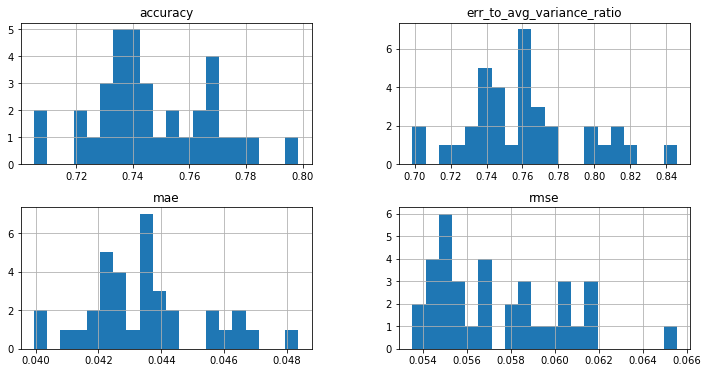

In [13]:
rmse_details_df.sort_values('rmse').hist(bins = 20, figsize = (12, 6));

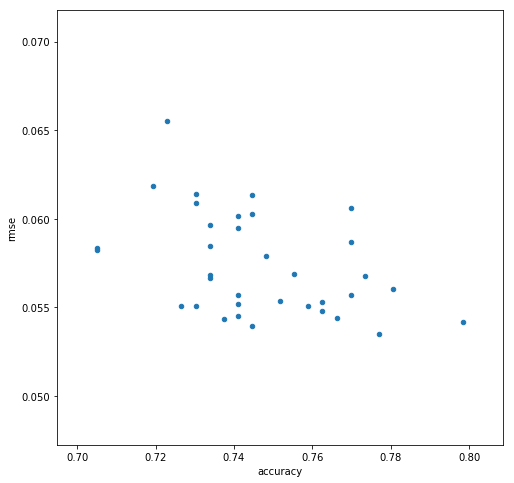

In [14]:
rmse_details_df.plot('accuracy', 'rmse', kind = 'scatter', figsize = (8, 8));

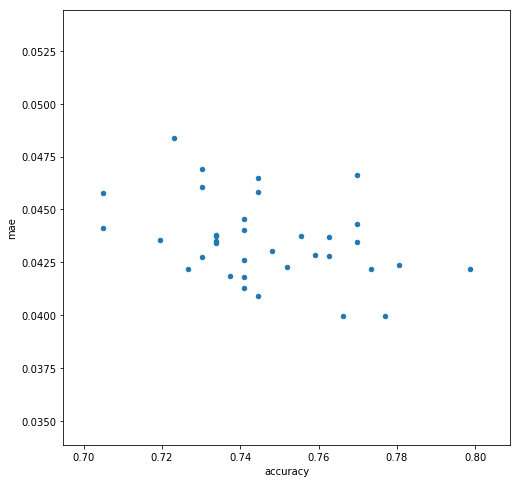

In [15]:
rmse_details_df.plot('accuracy', 'mae', kind = 'scatter', figsize = (8, 8));

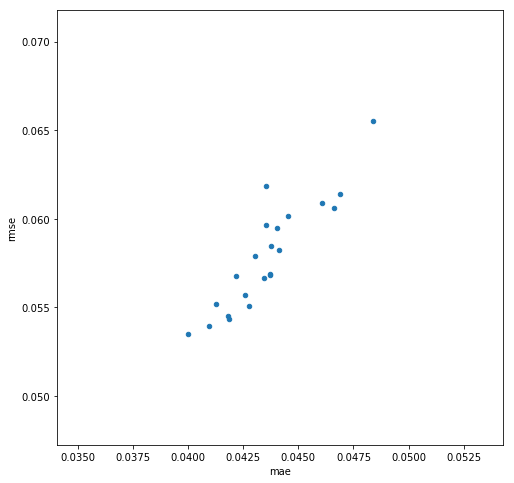

In [12]:
rmse_details_df.plot('mae', 'rmse', kind = 'scatter', figsize = (8, 8));

## RMSE Analysis

#### Features
As it stands, **the 40 feature models are currently performoing better** in regards to error. We don't have as many 80 feature models though so more data is neeeded.

In [16]:
rmse_details_df.groupby('features').mean().sort_values('accuracy', ascending = False)

,accuracy,err_to_avg_variance_ratio,mae,rmse
features,,,,
80,0.751079,0.771461,0.044105,0.057039
40,0.744604,0.756974,0.043277,0.057520


#### Layers
There doesn't seem to be any difference in error using 1 or 2 layers.

In [17]:
print('\n== 40 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '40'].groupby('layers').mean().sort_values('accuracy', ascending = False))

print('\n== 80 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '80'].groupby('layers').mean().sort_values('accuracy', ascending = False))


== 40 Features ==

        accuracy  err_to_avg_variance_ratio       mae      rmse
layers                                                         
2       0.758993                   0.753162  0.043059  0.056676
1       0.736511                   0.759119  0.043399  0.057994

== 80 Features ==

        accuracy  err_to_avg_variance_ratio       mae      rmse
layers                                                         
2       0.761391                   0.749631  0.042857  0.055272
1       0.746660                   0.780816  0.044640  0.057796


#### LSTM Units
There is a clear preference for **less LSTM units**.

In [18]:
print('\n== 40 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '40'].groupby('units').mean().sort_values('accuracy', ascending = False))

print('\n== 80 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '80'].groupby('units').mean().sort_values('accuracy', ascending = False))


== 40 Features ==

       accuracy  err_to_avg_variance_ratio       mae      rmse
units                                                         
96     0.749550                   0.751524  0.042965  0.056783
128    0.745632                   0.754259  0.043121  0.057868
64     0.742035                   0.767948  0.043904  0.057520
52     0.735012                   0.752239  0.043006  0.058673

== 80 Features ==

       accuracy  err_to_avg_variance_ratio       mae      rmse
units                                                         
128    0.766187                   0.772106  0.044142  0.056592
52     0.746403                   0.757298  0.043295  0.055949
64     0.741007                   0.780176  0.044603  0.058383
96     0.735612                   0.775619  0.044342  0.057678


#### Dropout
Overall, it seems **the lower the dropout the better -- except 0, that performs worst in both 40 and 80 feature models**. There is no *logical* trend for the 80 feature models, need more data before we can say anything conclusive. **For the 40 feature models, dropouts of 0.1 and 0.2 are best**.

In [19]:
print('\n== Overall ==\n')
print(rmse_details_df.groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 40 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '40'].groupby('dropout').mean().sort_values('accuracy', ascending = False))

print('\n== 80 Features ==\n')
print(rmse_details_df[rmse_details_df.features == '80'].groupby('dropout').mean().sort_values('accuracy', ascending = False))


== Overall ==

         accuracy  err_to_avg_variance_ratio       mae      rmse
dropout                                                         
0.2      0.753237                   0.768762  0.043950  0.058447
0.1      0.748855                   0.771025  0.044080  0.058805
0.3      0.748201                   0.754093  0.043112  0.056836
0        0.744604                   0.801451  0.045819  0.061360
0.4      0.741727                   0.749480  0.042848  0.055612
0.6      0.735612                   0.746536  0.042680  0.055398

== 40 Features ==

         accuracy  err_to_avg_variance_ratio       mae      rmse
dropout                                                         
0.2      0.755396                   0.757660  0.043316  0.057987
0.1      0.746660                   0.765104  0.043741  0.059201
0.3      0.745324                   0.755216  0.043176  0.057244
0        0.744604                   0.801451  0.045819  0.061360
0.4      0.737410                   0.744564  0.042567

# Find Optimal Ensemble

## Define Iterables

In [ ]:
#summary.model.tolist()
#rmse_details_df[(rmse_details_df.rmse <= 0.055) & (rmse_details_df.accuracy >= 0.72)].model.tolist()

In [20]:
# only apart of the ensembles
all_models = {
    
    0: '6hrs_4steps_300bidir_40features_1layers_300epochs_1timesteps_0.2dropout_32units',
    1: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.4dropout_80units',
    2: '6hrs_4steps_400bidir_40features_1layers_300epochs_1timesteps_0.3dropout_48units',
    3: '6hrs_4steps_300bidir_80features_1layers_300epochs_1timesteps_0.3dropout_32units',
    4: '6hrs_4steps_300bidir_80features_1layers_300epochs_1timesteps_0.4dropout_64units',
    5: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.3dropout_48units',
    6: '6hrs_4steps_250bidir_40features_1layers_300epochs_1timesteps_0.1dropout_32units',
    7: '6hrs_4steps_400bidir_40features_1layers_300epochs_1timesteps_0.4dropout_80units',
    8: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.4dropout_48units',
    9: '6hrs_4steps_400bidir_40features_1layers_300epochs_1timesteps_0.3dropout_64units',
    10: '6hrs_4steps_300bidir_80features_1layers_300epochs_1timesteps_0.3dropout_64units',
    11: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.4dropout_64units',
    12: '6hrs_4steps_300bidir_40features_1layers_300epochs_1timesteps_0.4dropout_64units',
    13: '6hrs_4steps_300bidir_80features_1layers_300epochs_1timesteps_0.2dropout_32units',
    14: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.2dropout_32units',
    15: '6hrs_4steps_250bidir_80features_1layers_300epochs_1timesteps_0.3dropout_64units',
    16: '6hrs_4steps_250bidir_40features_1layers_300epochs_1timesteps_0.2dropout_48units',
    17: '6hrs_4steps_400bidir_40features_1layers_300epochs_1timesteps_0.2dropout_48units'
}

## Get Ensemble Combinations

In [21]:
'''
DON'T FORGET TO SET THIS
'''''''''

max_models_per_ensemble = 5

''''''''''''

''

In [22]:
# create a range for iteration
iter_models = np.arange(len(all_models))

subsets = []

iter_model_sum = int(len(iter_models))
iter_model_list = list(iter_models)

for L in range(0, max_models_per_ensemble + 1):
    print('starting iteration:', L)
    for subset in combinations(iter_model_list, L):
        subsets.append(subset)

# get rid of first item (empty)
subsets = list(subsets[1:])

print('\nThere are %s possible ensembles total!' % len(subsets))

starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5

There are 12615 possible ensembles total!


## Get Accuracy & Error for Each Ensemble

In [23]:
counter = 0

ens_coms = []
ens_accs = []
ens_mae_tar = []
ens_rmse_tar = []

for subset in subsets:

    # get all model combos based off of subset index
    model_combo = [all_models[sub] for sub in subset]

    model_predicted = {}
    model_error = {}

    for m in model_combo:
        model_predicted[m] = [p[0][1] for p in results[m]]
        model_error[m] = [p[1] for p in results[m]]

    match_count = 0
    match_list_plot_ps = []

    # create a series of the actual and predicted values
    y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
    y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
    
    # create a zip using the true and predicted values
    ensemble_zip_acc = zip(y_true, y_pred)

    # get the RMSE of only the target (the fourth time period, or next day)
    rmse_target = mse(y_true, y_pred) ** (0.5)
    
    # get Mean Absolute Error
    mae_target = mae(y_true, y_pred)
    
    # get the sign accuracy count of the predictions
    for a, p in ensemble_zip_acc:

        if np.sign(p) == np.sign(a): match_count += 1

        if np.sign(p) == np.sign(a):
            match_list_plot_ps.append(0.1)
        else:
            match_list_plot_ps.append(-0.1)

    # calculate the overall accuracy
    ensemble_acc = match_count / len(pd.DataFrame(model_predicted).mean(1).tolist())

    ens_coms.append(str(model_combo))
    ens_accs.append(ensemble_acc)
    ens_mae_tar.append(mae_target.mean())
    ens_rmse_tar.append(rmse_target)

    counter += 1

    if counter % 10000 == 0: print('%s done' % counter)

10000 done


## General Ensemble Analysis

In [24]:
combo_results_df = pd.DataFrame({'combo': ens_coms,
                                 'accuracy': ens_accs,
                                 'mae_tar': ens_mae_tar,
                                 'rmse_tar': ens_rmse_tar}).drop_duplicates('combo').sort_values('accuracy',
                                                                                                  ascending = False
                                                                                                 ).reset_index(drop = True)

combo_results_df['error_ratio'] = (combo_results_df['mae_tar'] * (len(y_true) ** 0.5)) / combo_results_df['rmse_tar']

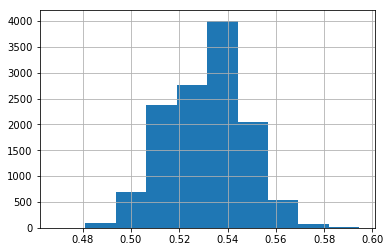

In [36]:
combo_results_df.accuracy.hist()

In [43]:
high_acc_ens = combo_results_df[combo_results_df.accuracy >= .82].combo.tolist()

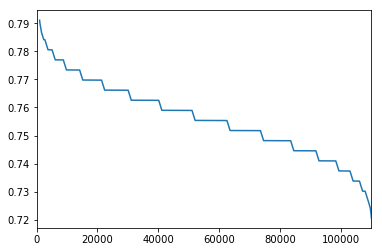

In [34]:
# rolling average of ensemble accuracy
combo_results_df.accuracy.reset_index(drop = True).rolling(center = False, window = 1000).mean().plot();

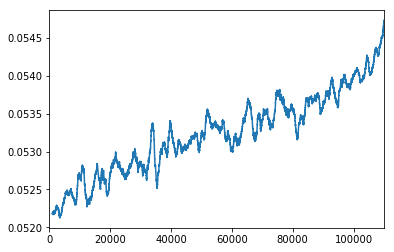

In [33]:
combo_results_df.rmse_tar.reset_index(drop = True).rolling(center = False, window = 1000).mean().plot();

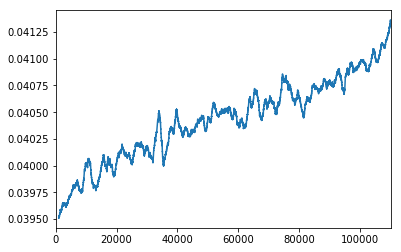

In [32]:
# rolling average of ensemble error
combo_results_df.mae_tar.reset_index(drop = True).rolling(center = False, window = 1000).mean().plot();

In [27]:
'''
CURRENT WINNERS
'''

# accuracy: 77.3% | target mae: 3.81159% | target rmse: 5.04174%
top_ens_1 = ['6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_128units',
             '6hrs_4steps_40features_2layers_300epochs_1timesteps_0.1dropout_96units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_52units'
            ]

# accuracy: X% | target rmse: X% | trend rmse: X%
top_ens_2 = ['6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.6dropout_96units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.1dropout_96units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_128units',
             '6hrs_4steps_80features_1layers_300epochs_1timesteps_0.1dropout_128units',
             '6hrs_4steps_80features_1layers_300epochs_1timesteps_0.4dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.6dropout_128units'
            ]

# accuracy: X% | target rmse: X% | trend rmse: X%
top_ens_3 = ['6hrs_4steps_40features_1layers_300epochs_1timesteps_0.1dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.3dropout_96units',
             '6hrs_4steps_80features_1layers_300epochs_1timesteps_0.4dropout_52units'
            ]

# accuracy: X% | target rmse: X% | trend rmse: X%
top_ens_4 = ['6hrs_4steps_40features_1layers_300epochs_1timesteps_0.1dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_52units',
             '6hrs_4steps_40features_1layers_300epochs_1timesteps_0.3dropout_96units',
             '6hrs_4steps_80features_1layers_300epochs_1timesteps_0.4dropout_52units',
             '6hrs_4steps_80features_1layers_300epochs_1timesteps_0.4dropout_52units'
            ]

print('\n=== UNIQUES MODELS ===\n')
for m in set(top_ens_1 + top_ens_2 + top_ens_3): print(m)


=== UNIQUES MODELS ===

6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_128units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.6dropout_96units
6hrs_4steps_80features_1layers_300epochs_1timesteps_0.1dropout_128units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.4dropout_52units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.1dropout_52units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.3dropout_96units
6hrs_4steps_80features_1layers_300epochs_1timesteps_0.4dropout_52units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.6dropout_128units
6hrs_4steps_40features_1layers_300epochs_1timesteps_0.1dropout_96units
6hrs_4steps_40features_2layers_300epochs_1timesteps_0.1dropout_96units


In [63]:
for m in top_ens_2:
    model_predicted[m] = [p[0][1] for p in results[m]]

y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
y_true = [i[0][0] for i in results[model_combo[0]]]

In [64]:
'''

HAVEN'T RUN THE BELOW SCRIPT AGAIN WITH LAG ACCURACY YET, DO IT!!!!!!

'''

"\n\nHAVEN'T RUN THE BELOW SCRIPT AGAIN WITH LAG ACCURACY YET, DO IT!!!!!!\n\n"

# Find Best Trading Strategy for Top Ensembles

In [19]:
# set trading strategies
trading_strategies = ['static_target_threshold',
                      'static_target_always',
                      'variable_target_threshold',
                      'variable_target_always',
                      'no_target_threshold',
                      'no_target_always'
                     ]

In [47]:
high_acc_ens =  [['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.2dropout_52units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.3dropout_96units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0dropout_96units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.2dropout_52units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0dropout_96units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.2dropout_52units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0dropout_96units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_128units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_128units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.2dropout_52units', '40features_1layers_300epochs_1timesteps_0.3dropout_64units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_1layers_300epochs_1timesteps_0.6dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units'],
                 ['40features_1layers_300epochs_1timesteps_0.1dropout_96units', '40features_1layers_300epochs_1timesteps_0.4dropout_52units', '40features_2layers_300epochs_1timesteps_0dropout_64units', '80features_2layers_300epochs_1timesteps_0.1dropout_128units', '80features_2layers_300epochs_1timesteps_0.2dropout_64units', '80features_2layers_300epochs_1timesteps_0.4dropout_64units']
                ]

In [1]:
'''
FIND THE MOST PROFITABLE THRESHOLD USING THE TOP MODELS
'''

all_accs = {}
all_laac = {}
all_prfs = {}
all_marg = {}
all_prtr = {}
all_lotr = {}
all_rmse = {}

#####
# SET MIN & MAX
##

min_target = 0
max_target = 0.175
target_step = 0.005

for strat_type in trading_strategies:
    
    print('starting', strat_type)
    
    for trade_target in np.arange(min_target, max_target, target_step):
        
        strategy_id = '%s_%s' % (strat_type, trade_target)
        
        ens_coms = []
        ens_accs = []
        ens_laac = []
        ens_prfs = []
        ens_marg = []
        ens_prtr = []
        ens_lotr = []
        ens_rmse = []
        
        print(strategy_id)

        for model_combo in high_acc_ens:

            if len(model_combo) > 0:

                model_predicted = {}
                model_error = {}

                for m in model_combo:
                    model_predicted[m] = [p[0][1] for p in results[m]]
                    model_error[m] = [p[1] for p in results[m]]

                match_count = 0
                match_list_plot_ps = []

                # create a series of the actual and predicted values
                y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
                y_pred = pd.DataFrame(model_predicted).mean(1).tolist()

                # create a series of the RMSE
                m_rmse = pd.DataFrame(model_error).mean(1)

                # create a zip using the true and predicted values, there needs to be two
                # because for some reason, a zip can only be used once
                ensemble_zip_acc = zip(y_true, y_pred)
                ensemble_zip_cap = zip(y_true, y_pred)

                # get the sign accuracy count of the predictions
                for a, p in ensemble_zip_acc:

                    if np.sign(p) == np.sign(a): match_count += 1

                    if np.sign(p) == np.sign(a):
                        match_list_plot_ps.append(0.1)
                    else:
                        match_list_plot_ps.append(-0.1)

                # calculate the overall accuracy
                ensemble_acc = match_count / len(pd.DataFrame(model_predicted).mean(1).tolist())
                
                # calculate the lag accuracy
                ensemble_lag_acc = get_lag_accuracy(y_true, y_pred)
                
                # run the predictions through a trade simulation
                ensemble_cap = target_trading_simulation(ensemble_zip_cap, strat_type, 1000, trade_target)

                ens_coms.append(str(model_combo))
                ens_accs.append(ensemble_acc)
                ens_laac.append(ensemble_lag_acc)
                ens_prfs.append(ensemble_cap[0])
                ens_marg.append(ensemble_cap[1])
                ens_prtr.append(ensemble_cap[2])
                ens_lotr.append(ensemble_cap[3])
                ens_rmse.append(m_rmse.mean())
         
        # add performance to list to judge target threshold
        all_accs[strategy_id] = list(ens_accs)
        all_laac[strategy_id] = list(ens_laac)
        all_prfs[strategy_id] = list(ens_prfs)
        all_marg[strategy_id] = list(ens_marg)
        all_prtr[strategy_id] = list(ens_prtr)
        all_lotr[strategy_id] = list(ens_lotr)
        all_rmse[strategy_id] = list(ens_rmse)

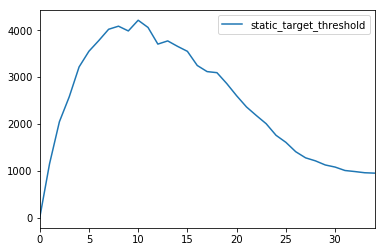

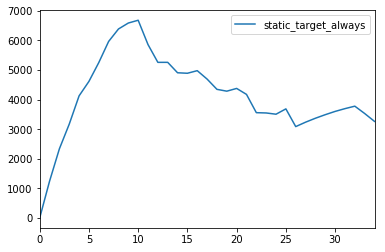

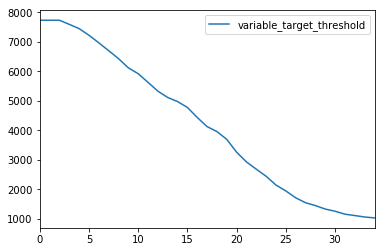

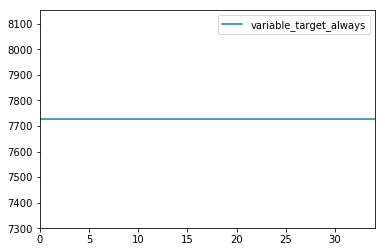

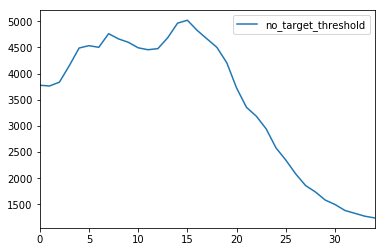

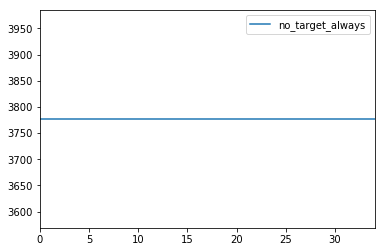

In [52]:
for strat_type in trading_strategies:
    
    sids = []
    
    for trade_target in np.arange(min_target, max_target, target_step):
        strategy_id = '%s_%s' % (strat_type, trade_target)
        sids.append(strategy_id)
    
    pd.DataFrame({strat_type: pd.DataFrame([all_marg[sid] for sid in sids]).T.mean().values}).plot(legend = True)

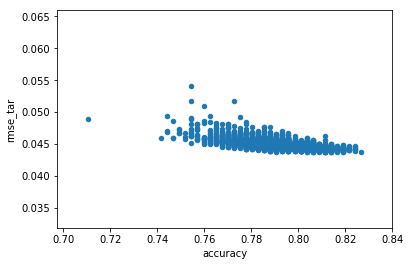

In [56]:
# ONCE TRADE STRATEGY IS DECIDED, DO A SCATTER BETWEEN ACCURACY AND PROFIT

combo_results_df.plot('accuracy', 'rmse_tar', kind = 'scatter');

# TRENDED VOLATALITY

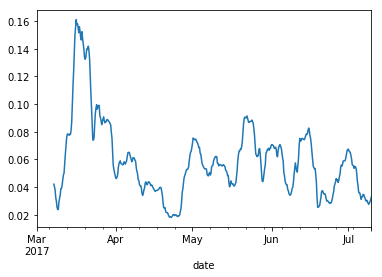

In [23]:
'''
GET TRENDED VOLATALITY SINCE TRAINING DATA START
'''

# get all attributes for the 6hr candle
candle_time = '6H'
df = ta.get_all_attributes('BTC_ETH', candle_time)

# extract only close price
close = pd.DataFrame({'close': df.close})

# get the next day price and drop null values
close['next_day_close'] = close.shift(-4)
close.dropna(inplace = True)

# set RoC
close['roc'] = (close['next_day_close'] - close['close']) / close['close']

# drop any data before March
tp = close[close.index >= '2017-03-01']

# get absolute value for a better volatality measure
tp['abs_roc'] = abs(tp['roc'])

# plot the ema, with a 28 period (1 wk) window
tp.abs_roc.rolling(window = 28).mean().plot();

# PREDICTION THRESHOLD ACCURACY

In [19]:
'''
GET TRENDED VOLATALITY SINCE TRAINING DATA START
'''

y_pred_dict = {}

for m in results:
    
    y_pred_dict[m] = [r[0][1] for r in results[m]]
    y_true_list = [r[0][0] for r in results[m]]

ens_y_pred = pd.DataFrame(y_pred_dict)[ens_model_list].mean(1).tolist()

ens_results = pd.DataFrame({'ens_y_pred': ens_y_pred, 'ens_y_true': y_true_list})

ens_results['accurate'] = np.sign(ens_results['ens_y_pred']) == np.sign(ens_results['ens_y_true'])

In [25]:
ens_results.groupby('accurate').mean()

,ens_y_pred,ens_y_true
accurate,,
False,0.003618,0.002202
True,0.017902,0.028005


In [24]:
ens_results.groupby('accurate').median()

,ens_y_pred,ens_y_true
accurate,,
False,0.004036,-0.003147
True,0.007719,0.021392


In [55]:
# helper to get volatality threshold / category
def get_volatality(row):
    
    # get absolute values
    v = abs(row['ens_y_pred'])
    
    # categorize the level of volatality
    for level in np.arange(0.01, .3, 0.005).tolist():
        if v < level:
            return level

# calculate volatality level
ens_results['volatality_level'] = ens_results.apply(lambda x: get_volatality(x), axis = 1)

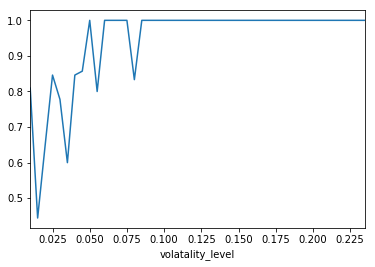

In [57]:
ens_results.groupby('volatality_level').mean().accurate.plot();

In [58]:
ens_results.groupby('volatality_level').mean()

,ens_y_pred,ens_y_true,accurate
volatality_level,,,
0.010,0.002606,0.010498,0.809524
0.015,-0.002998,-0.009029,0.444444
0.020,0.000936,0.019837,0.647059
0.025,-0.004445,0.004728,0.846154
0.030,0.006150,0.016796,0.777778
0.035,-0.006984,-0.015291,0.600000
0.040,0.008618,0.024640,0.846154
0.045,-0.006575,-0.004635,0.857143
0.050,-0.015062,0.012013,1.000000


# Period Lag Predictions

In [26]:
print('MOST ACCURATE\n')
print(top_ens_1)

print('\nLOWEST ERROR\n')
print(top_ens_2)

In [65]:
sample = results['80features_2layers_300epochs_1timesteps_0dropout_96units']

In [66]:
y_true = [s[0][0] for s in sample]
y_pred = [s[0][1] for s in sample]

# FIND THE MOST PROFITABLE TRADING STRATEGY

In [95]:
df = pd.read_csv('btceth_export_2017-07-16.csv')

# filter down to new df with only the needed cols and dates
df.index = df.date
ema_cols = [col for col in df if 'ema' in col and 'roc' in col]
df = df[ema_cols + ['close', 'close_target']]

# the start date of the predicted data is:
df = df[df.index >= '2017-04-11 12:00:00']

# ending after 379 samples
df = df.ix[:379,:]

trend_df = pd.DataFrame()

# create new df with the sign of each dimension
for col in df.columns.tolist():
    
    # get the sign of each roc
    trend_df[col] = np.sign(df[col])

# add y values to the cycle / sign df
trend_df['y_true'] = np.array(y_true[:379])
trend_df['y_pred'] = np.array(y_pred[:379])

# add a filler col for no trend for easier iteration in analysis
trend_df['no_trend'] = 0

In [2]:
'''
FIND THE MOST PROFITABLE TRADING STRATEGY
'''

all_prfs = {}
all_marg = {}
all_prtr = {}
all_lotr = {}

#####
# SET MIN & MAX
##

min_target = 0
max_target = 0.18
target_step = 0.0025

# all n period RoC ema and a 'no trend' option
trend_cols = [col for col in trend_df if 'ema' in col] + ['no_trend']

for strat_type in trading_strategies:
    
    print('starting', strat_type)
    
    for trade_target in np.arange(min_target, max_target, target_step):
        
        for trend in trend_cols:
            
            strategy_id = '%s|%s|%s' % (strat_type, trade_target, trend)
            print(strategy_id)
            
            ens_coms = []
            ens_prfs = []
            ens_marg = []
            ens_prtr = []
            ens_lotr = []
            
            # get the list of trend lists for the trading simulation
            trend_class = trend_df[trend].tolist()
            
            counter = 0
            
            for model_combo in high_acc_ens:
                
                if len(model_combo) > 0:
                    
                    model_predicted = {}
                    
                    for m in model_combo:
                        model_predicted[m] = [p[0][1] for p in results[m]]
                    
                    match_count = 0
                    match_list_plot_ps = []
                    
                    # create a series of the actual and predicted values
                    y_true = pd.Series([i[0][0] for i in results[model_combo[0]]])
                    y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
                    
                    # create a zip using the true and predicted values, there needs to be two
                    # because for some reason, a zip can only be used once
                    ensemble_zip_cap = zip(y_true, y_pred)
                    
                    if trend != 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = trend_trading_simulation(ensemble_zip_cap,
                                                                strat_type,
                                                                1000,
                                                                trade_target,
                                                                trend_class
                                                               )
                    
                    elif trend == 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = target_trading_simulation(ensemble_zip_cap,
                                                                 strat_type,
                                                                 1000,
                                                                 trade_target
                                                                )
                    
                    else: print('\n\n\nSOMETHING IS WRONG!!!\n\n\n')
                        
                    # add results to each ensemble's kpi list
                    ens_coms.append(str(model_combo))
                    ens_prfs.append(ensemble_cap[0])
                    ens_marg.append(ensemble_cap[1])
                    ens_prtr.append(ensemble_cap[2])
                    ens_lotr.append(ensemble_cap[3])

            # add performance to list to judge target threshold
            all_prfs[strategy_id] = list(ens_prfs)
            all_marg[strategy_id] = list(ens_marg)
            all_prtr[strategy_id] = list(ens_prtr)
            all_lotr[strategy_id] = list(ens_lotr)

In [107]:
avg_perf = []

for k in all_prfs:
    
    avg_perf.append({'zid': k,
                     'trading_strategy': k.split('|')[0],
                     'target_threshold': k.split('|')[1],
                     'market_trend': k.split('|')[2],
                     'profit': np.array(all_prfs[k]).mean(),
                     'marg_return': np.array(all_marg[k]).mean(),
                     'profitable_trade_count': np.array(all_prtr[k]).mean(),
                     'loss_trade_count': np.array(all_lotr[k]).mean()
                    }
                   )

avg_perf_df = pd.DataFrame(avg_perf).sort_values('marg_return', ascending = False).reset_index(drop = True)

In [112]:
avg_perf_df.head(10)

,loss_trade_count,marg_return,market_trend,profit,profitable_trade_count,target_threshold,trading_strategy,zid
0,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1425,no_target_always,no_target_always|0.1425|roc_ema_180_5
1,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.01,no_target_always,no_target_always|0.01|roc_ema_180_5
2,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1075,no_target_always,no_target_always|0.1075|roc_ema_180_5
3,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.0825,no_target_always,no_target_always|0.0825|roc_ema_180_5
4,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1675,no_target_always,no_target_always|0.1675|roc_ema_180_5
5,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1275,no_target_always,no_target_always|0.1275|roc_ema_180_5
6,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.1725,no_target_always,no_target_always|0.1725|roc_ema_180_5
7,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.035,no_target_always,no_target_always|0.035|roc_ema_180_5
8,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.14,no_target_always,no_target_always|0.14|roc_ema_180_5
9,35.153846,10008.062278,roc_ema_180_5,1.161214e+07,162.769231,0.145,no_target_always,no_target_always|0.145|roc_ema_180_5


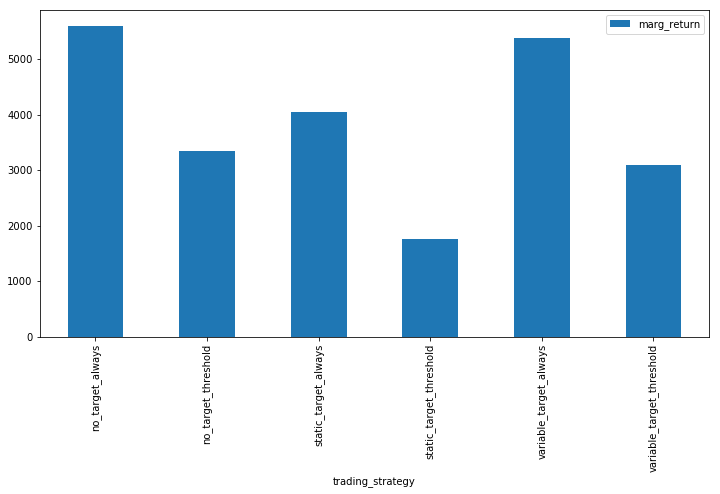

In [132]:
avg_perf_df[['market_trend',
             'trading_strategy',
             'marg_return']].groupby(['trading_strategy']).mean().plot(kind = 'bar',
                                                                   figsize = (12, 6)
                                                                  );

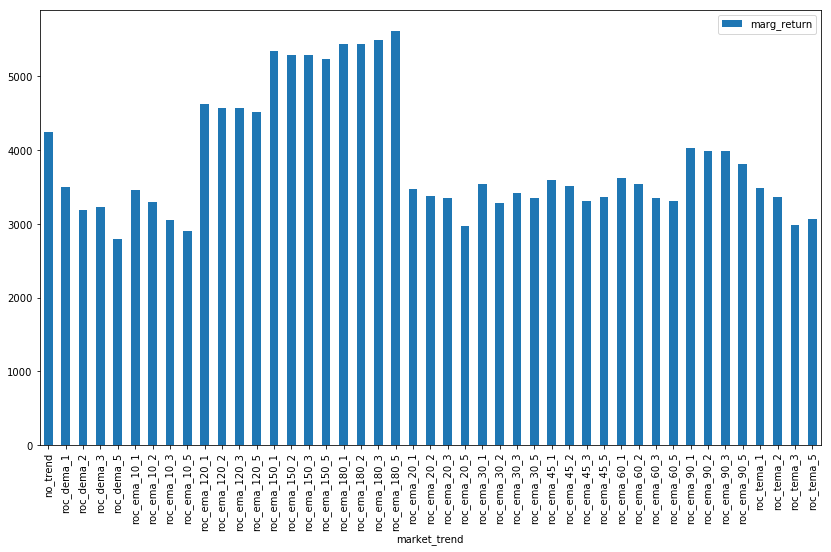

In [129]:
avg_perf_df[['market_trend',
             'trading_strategy',
             'marg_return']].groupby(['market_trend']).mean().plot(kind = 'bar',
                                                                   figsize = (14, 8)
                                                                  );

static_target_threshold
variable_target_threshold
no_target_always
no_target_threshold
static_target_always
variable_target_always


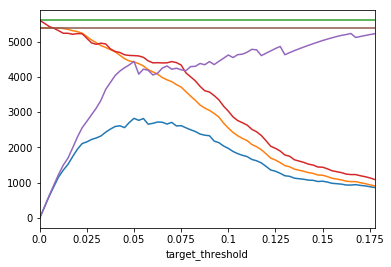

In [109]:
for s in set(avg_perf_df.trading_strategy.tolist()):
    
    print(s)
    
    select_ts = avg_perf_df.trading_strategy == s
    #select_mt = avg_perf_df.market_trend == 'roc_ema_150_1'
    
    sdf = avg_perf_df[select_ts].sort_values('target_threshold')
    #sdf = avg_perf_df[(select_ts) & (select_mt)].sort_values('target_threshold')
    
    sdf.groupby('target_threshold').mean().marg_return.plot()

## Trading Strategy Notes

Basically, the best strategy is to open a position in the direction of the trend any time the model predicts that's the way it will go. Which is probably the easiest strategy to follow, well kinda. Mentally it will be tough. But it leaves little room for compromise, so that's good.

**Next steps are**:
 - run the final iteration of the enemble finder with the remainding models
 - get the predictions for the period of time since i started testing and run the best models
 - see if the trading strategy holds
 - finish up with the lag accuracy stuff
 - go back to following Trello

# TRENDED MARGIN RETURN

In [130]:
# set trading strategies
trading_strategies = [
    
    'static_target_threshold',
    'static_target_always',
    'variable_target_threshold',
    'variable_target_always',
    'no_target_threshold',
    'no_target_always'

]

# set trend strategies

trend_strategies = [
    
    'roc_ema_180_5',
    'no_trend'
]

In [131]:
for m in top_ens_1:
    model_predicted[m] = [p[0][1] for p in results[m]]

y_pred = pd.DataFrame(model_predicted).mean(1).tolist()
y_true = model_y_true[list(results.keys())[0]]

ema_180_5_trend_class = trend_df.roc_ema_180_5.tolist()

In [135]:
# set per len
per_step = 14

# set min, max, step
min_target = 0.0001
max_target = 0.15
target_step = 0.0001

# all n period RoC ema and a 'no trend' option
#trend_cols = [col for col in trend_df if 'ema' in col] + ['no_trend']

strat_trended = {}
per_range = np.arange(0, len(y_pred), per_step)

for trend in trend_strategies:
    
    # get the list of trend lists for the trading simulation
    trend_class = trend_df[trend].tolist()

    for strat_type in trading_strategies:
        
        strat_id = strat_type + '_' + trend

        print('starting', strat_id)

        target_return = {}

        for trade_target in np.arange(min_target, max_target, target_step):

            start_index = 0
            end_index = 1

            trended_return = []

            for _ in per_range:

                try:

                    start_slice = per_range[start_index]
                    end_slice = per_range[end_index]

                    # (re)zip y values
                    ensemble_zip_cap = zip(y_true[start_slice:end_slice],
                                           y_pred[start_slice:end_slice]
                                          )

                    # add to indices for next iteration
                    start_index += 1
                    end_index += 1
                    
                    if trend == 'no_trend':
                    
                        # run the predictions through a trade simulation
                        ensemble_cap = target_trading_simulation(ensemble_zip_cap,
                                                                 strat_type,
                                                                 1000,
                                                                 trade_target
                                                                )
                        
                    elif trend != 'no_trend':
                        
                        # run the predictions through a trade simulation
                        ensemble_cap = trend_trading_simulation(ensemble_zip_cap,
                                                                strat_type,
                                                                1000,
                                                                trade_target,
                                                                trend_class
                                                               )
                        
                    # add the return to the list for this target
                    trended_return.append(ensemble_cap[1])

                except IndexError: pass

            target_return[trade_target] = trended_return

        strat_trended[strat_id] = pd.DataFrame(target_return).mean(1).tolist()

starting static_target_threshold_roc_ema_180_5
starting static_target_always_roc_ema_180_5
starting variable_target_threshold_roc_ema_180_5
starting variable_target_always_roc_ema_180_5
starting no_target_threshold_roc_ema_180_5
starting no_target_always_roc_ema_180_5
starting static_target_threshold_no_trend
starting static_target_always_no_trend
starting variable_target_threshold_no_trend
starting variable_target_always_no_trend
starting no_target_threshold_no_trend
starting no_target_always_no_trend


In [136]:
trended_return_df = pd.DataFrame(strat_trended)
trended_return_df['baseline'] = 0

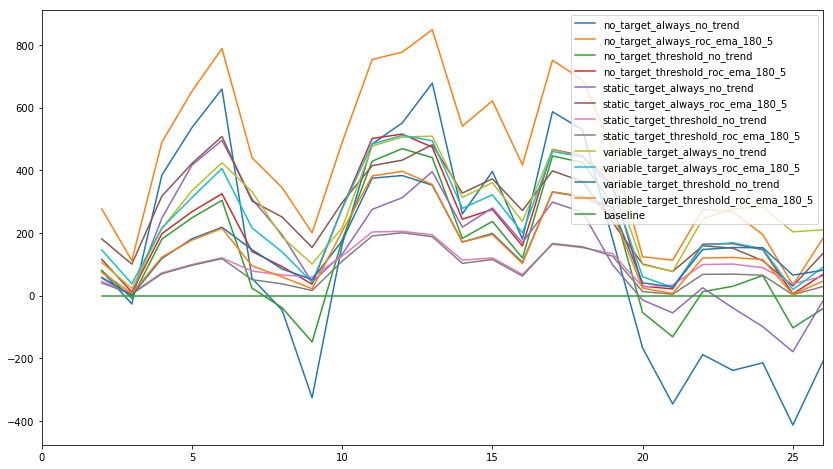

In [137]:
trended_return_df.rolling(3).mean().plot(figsize = (14, 8));

In [138]:
# what percentage of the most recent time periods
recent_percentage = 0.2

print('\n===== TOP PERFORMING STRATEGIES, RECENTLY =====')
trended_return_df[trended_return_df.index >= (len(trended_return_df.index) * (1 - recent_percentage))].sum().sort_values(ascending = False)


===== TOP PERFORMING STRATEGIES, RECENTLY =====


variable_target_always_no_trend            1330.689387
no_target_always_roc_ema_180_5             1108.624004
static_target_always_roc_ema_180_5          714.458517
variable_target_always_roc_ema_180_5        706.939543
variable_target_threshold_no_trend          668.507574
no_target_threshold_roc_ema_180_5           640.397619
variable_target_threshold_roc_ema_180_5     481.006811
static_target_threshold_no_trend            430.997994
static_target_threshold_roc_ema_180_5       279.889364
no_target_threshold_no_trend                129.204719
baseline                                      0.000000
static_target_always_no_trend              -155.168806
no_target_always_no_trend                  -914.313530
dtype: float64